This file contains a basic squeme for training and test of a Convolutional Neural Network (CNN) using RNA sequence of the ribosomal subunit 16 (16s rRNA) for species classification. The code is adapted to work with GPU using Pytroch CUDA

NOTE : The use of cuda depends on the GPU available, modern versions of cuda doesn't work with old GPUs and some old versions of cuda doesn't work with modern versions of pytorch and numpy. Check the dependencies before running.

In [1]:
#Import the mecessary libraries
import sys 
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn #To define the NN
from sklearn.preprocessing import OneHotEncoder #For training
import torch #For training
import torch.optim as optim #For training
import copy #For training
import tqdm #For training
from Bio import AlignIO

# Define architectures

## Standard MLP

In [2]:
class MLP(nn.Module):
    def __init__(self, X_train, y_train, layers_dim = [512,256], dropout = 0.2, layer_or_batchnorm="layer"):
        super().__init__()
        in_neuron = X_train.shape[1] # The first neurons are the dimension of the sample
        layers = []
        for out_neuron in layers_dim:
            layers.append(nn.Linear(in_neuron, out_neuron))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            layers.append(
                nn.LayerNorm(out_neuron) if layer_or_batchnorm == "layer" else nn.BatchNorm1d(out_neuron)
            ) # Specify if the normalization if layer or batch
            in_neuron = out_neuron
        out_neuron = len(np.unique(y_train)) # The last neurons are the number of labels
        layers.append(nn.Linear(in_neuron, out_neuron)) 
        self.net = nn.Sequential(*layers) # nn.Sequential use several inputs as parameters of several hidden layers

    def forward(self, x):
        return self.net(x) #If nn.Sequential is use then the model needs to be moved to the gpu

## Different CNN options

In [3]:
# For a CNN we can have three parts, a residual block (residual connection to avoid vanish gradient), 
#a backbone (main structure) and classifier (last step to flater the values)
class CNN(nn.Module):
    def __init__(self, seq_X_train, seq_y_train, num_N, k_n ): # Note: For the sake of sequence conservation, use kernels of odd numbers
        super().__init__()
        #Start the convolution
        self.conv1 = nn.Conv1d(5, 32, kernel_size= k_n, stride= 1, padding= (k_n-1)//2) # For the training al numbers need to be on tensor, stride=1, padding=0, dilation=1, groups=1
        #Maybe add an residual block?
        self.actc1 = nn.ReLU()
        #Maybe add an batch normalization?
        self.dropc1 = nn.Dropout(0.2)
        #self.poolx = nn.MaxPool1d(kernel_size= k_n, stride=1, padding= (k_n-1)/2) #Remember that also reduce the size of the imput
        #self.actpx = nn.ReLU()
        #self.droppx = nn.Dropout(0.2)
        # The convolutions and maxpoolings can be repeat as many times as wanted

        self.flat = nn.Flatten() 
        #Start the mlp
        self.hidden1 = nn.Linear(32 * seq_X_train.shape[2], num_N) #The imput is the number of channels * sequence lenght, as is the size of the matrix 
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.2)
        # You can add as many layers as wanted

        self.output = nn.Linear(num_N, len(np.unique(seq_y_train)))
 
    def forward(self, x):
        #Perform convolution
        x = self.dropc1(self.actc1(self.conv1(x)))
        #Flat the data
        x = self.flat(x)
        #Do the mlp
        x = self.drop1(self.act1(self.hidden1(x)))
        x = self.output(x)
        return x


In [3]:
class CNNZ(nn.Module):
    def __init__(self, seq_X_train, seq_y_train, k_n, out_channel = [32], layers_dim = [512], 
                 MP = False, PD = True, dropout = 0.2, layer_or_batchnorm="layer"): # Note: For the sake of sequence conservation, use kernels of odd numbers
        super().__init__()
        #Start the convolution
        convs = []
        in_channel = 5
        pad = 0
        if PD : pad = (k_n-1)//2 #To control de padding
        seq_lenght = seq_X_train.shape[2] #Keep track for the data size
        for i in range(len(out_channel)): #Use i in case you want to use differet kernell sizes on each step
            convs.append(nn.Conv1d(in_channel, out_channel[i], kernel_size= k_n, padding = pad)) #The number of channels is fixed
            if not PD : seq_lenght += (1-k_n)
            convs.append(nn.ReLU())
            convs.append(nn.Dropout(dropout))
            if MP:
                convs.append(nn.MaxPool1d(kernel_size= k_n))
                seq_lenght = seq_lenght//k_n
                convs.append(nn.ReLU())
                convs.append(nn.Dropout(dropout))
            in_channel = out_channel[i]       
        self.conv = nn.Sequential(*convs)
        self.flat = nn.Flatten() #Flat the data
        
        #implement the MLP using the previous one
        flat_conv_seq_X_train = np.zeros((1, out_channel[-1]*seq_lenght)) #Representation of the flated convoluted sequence for the MLP input
        self.mlp = MLP(X_train=flat_conv_seq_X_train, y_train=seq_y_train, layers_dim=layers_dim, dropout=dropout, layer_or_batchnorm=layer_or_batchnorm)

    def forward(self, x):
        x = self.conv(x) #Perform convolution
        x = self.flat(x) #Flat the data
        #Do the mlp
        x = self.mlp(x) #The mlp has the output included
        return x

In [ ]:
class CNNZ(nn.Module):
    def __init__(self, seq_X_train, seq_y_train, k_n, out_channel = [32], layers_dim = [512], 
                 MP = False, PD = True, dropout = 0.2, layer_or_batchnorm="layer"): # Note: For the sake of sequence conservation, use kernels of odd numbers
        super().__init__()
        #Start the convolution
        convs = []
        in_channel = 5
        pad = 0
        if PD : pad = (k_n-1)//2 #To control de padding
        seq_lenght = seq_X_train.shape[2] #Keep track for the data size
        for i in range(len(out_channel)): #Use i in case you want to use differet kernell sizes on each step
            convs.append(nn.Conv1d(in_channel, out_channel[i], kernel_size= k_n, padding = pad)) #The number of channels is fixed
            if not PD : seq_lenght += (1-k_n)
            convs.append(nn.ReLU())
            convs.append(nn.Dropout(dropout))
            if MP:
                convs.append(nn.MaxPool1d(kernel_size= k_n))
                seq_lenght = seq_lenght//k_n
                convs.append(nn.ReLU())
                convs.append(nn.Dropout(dropout))
            in_channel = out_channel[i]       
        self.conv = nn.Sequential(*convs)
        self.flat = nn.Flatten() #Flat the data
        
        #implement the MLP using the previous one
        flat_conv_seq_X_train = np.zeros((1, out_channel[-1]*seq_lenght)) #Representation of the flated convoluted sequence for the MLP input
        self.mlp = MLP(X_train=flat_conv_seq_X_train, y_train=seq_y_train, layers_dim=layers_dim, dropout=dropout, layer_or_batchnorm=layer_or_batchnorm)

    def forward(self, x):
        x = self.conv(x) #Perform convolution
        x = self.flat(x) #Flat the data
        #Do the mlp
        x = self.mlp(x) #The mlp has the output included
        return x

In [ ]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, 10)
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x
    def forward(self,x):
        return x

# Functions

## For seq pre processing

In [4]:
def DNAonehotencoder (sequence):
    """
    One hot encoder for DNA/RNA sequences. 
    A first col
    C second col
    G third col
    T/U fourth col
    Others fifth col
    """
    ohe_seq = []
    mapping = {"A": [1,0,0,0,0], "C": [0,1,0,0,0], "G": [0,0,1,0,0], "T": [0,0,0,1,0], "U": [0,0,0,1,0]}
    for i in sequence:
        ohe_seq.append(mapping[i] if i in mapping.keys() else [0,0,0,0,1])
    return np.array(ohe_seq).T #Use the transpose to change the OHE format

In [6]:
def speciesDNA_encoder (align_file, species_dict):
    """
    Use an align file and a dictionary with the species labels.
    Get the X and y data in format for the implementation of NN.
    """
    seq_X_val, seq_y_val = [], []
    for record in align_file:
        id_info = str(record.id).split("_")
        bacteria = f"{id_info[0]} {id_info[1]}" 
        if bacteria in list(species_dict.keys()) :
            seq_X_val.append(DNAonehotencoder(str(record.seq))) # Do the one hot encoding
            seq_y_val.append(species_dict[bacteria]) #There are some bacterias wrong parced
    seq_X_val = np.array(seq_X_val)
    seq_y_val = np.array(seq_y_val)
    return seq_X_val, seq_y_val

## To train the models

In [7]:
def NN_train(model, X_train, X_val, y_train, y_val, batch_size, learning_rate, device) : #Function to train and validate the NN MLP
  
  #Reshape the data to encode
  y_train = y_train.reshape(-1,1)
  y_val = y_val.reshape(-1,1)

  #Encode the variables into a one shoot vector
  ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_train) #Create the coding
  y_train = ohe.transform(y_train) #Here you modiffy y, be aware of not running this twice, a ohe of an already ohe can create a multyclass problem that is not suited for CrossEntropy
  y_val = ohe.transform(y_val)

  #Convert numpy array into PyTorch tensors and move to the corresponding devide
  model = model.to(device)

  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
  X_val = torch.tensor(X_val, dtype=torch.float32).to(device)

  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
  y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

  #Define the loss function and optimization for training
  loss_fn = nn.CrossEntropyLoss() #In this case is Cross Entropy
  optimizer = optim.Adam(model.parameters(), lr=learning_rate) #The Loss Function optimization use done using Adam

  #Prepare model and training parameters
  n_epochs = 200 #epoch is a round of trainnig (with the optimization of each paramether)
  batches_per_epoch = len(X_train) // batch_size

  #We need to keep track of the optmizations results
  best_acc = - np.inf   # init to negative infinity
  best_weights = None
  train_loss_hist = []
  train_acc_hist = []
  val_loss_hist = []
  val_acc_hist = []

  #Training loop with the trainning set

  # training loop
  for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
      bar.set_description(f"Epoch {epoch}")
      for i in bar:
        # take a batch
        start = i * batch_size
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        # forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # compute and store metrics, important to change it from a pytorch tensor to a python float
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
        epoch_loss.append(float(loss))
        epoch_acc.append(float(acc))
        bar.set_postfix(
          loss=float(loss),
          acc=float(acc)
        )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_val)
    ce = loss_fn(y_pred, y_val)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    val_loss_hist.append(ce)
    val_acc_hist.append(acc)
    if acc > best_acc:
      best_acc = acc
      best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%") #Note sometimes it get stuck, maybe can not find the minimum on one step

  #Restore best model
  model.load_state_dict(best_weights)

  #Visualize the accuracy during the trainning process
  plt.plot(train_loss_hist, label="train")
  plt.plot(val_loss_hist, label="validation")
  plt.xlabel("epochs")
  plt.ylabel("cross entropy")
  plt.legend()
  plt.show()

  plt.plot(train_acc_hist, label="train")
  plt.plot(val_acc_hist, label="validation")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend()
  plt.show()

  return model, best_weights, y_pred

In [8]:
def CNN_train(model, X_train, X_val, y_train, y_val, batch_size, learning_rate, device) : #Function to train and validate the NN MLP
  
  #Reshape the data to encode
  y_train = y_train.reshape(-1,1)
  y_val = y_val.reshape(-1,1)

  #Encode the variables into a one shoot vector
  ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_train) #Create the coding
  y_train = ohe.transform(y_train) #Here you modiffy y, be aware of not running this twice, a ohe of an already ohe can create a multyclass problem that is not suited for CrossEntropy
  y_val = ohe.transform(y_val)

  #Convert numpy array into PyTorch tensors and move to the corresponding devide
  model = model.to(device)

  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
  print(X_train.shape)
  X_val = torch.tensor(X_val, dtype=torch.float32).to(device)

  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
  y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

  #Define the loss function and optimization for training
  loss_fn = nn.CrossEntropyLoss() #In this case is Cross Entropy
  optimizer = optim.Adam(model.parameters(), lr=learning_rate) #The Loss Function optimization use done using Adam

  #Prepare model and training parameters
  n_epochs = 200 #epoch is a round of trainnig (with the optimization of each paramether)
  batches_per_epoch = len(X_train) // batch_size
  print("batches_per_epoch",batches_per_epoch)

  #We need to keep track of the optmizations results
  best_acc = - np.inf   # init to negative infinity
  best_weights = None
  train_loss_hist = []
  train_acc_hist = []
  val_loss_hist = []
  val_acc_hist = []

  #Training loop with the trainning set

  # training loop
  for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
      bar.set_description(f"Epoch {epoch}")
      for i in bar:
        # take a batch
        start = i * batch_size
        X_batch = X_train[start:start+batch_size] #Is the data in the right dim? Maybe need to be flatted?
        y_batch = y_train[start:start+batch_size]
        # forward pass
        y_pred = model(X_batch) 
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # compute and store metrics, important to change it from a pytorch tensor to a python float
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
        epoch_loss.append(float(loss))
        epoch_acc.append(float(acc))
        bar.set_postfix(
          loss=float(loss),
          acc=float(acc)
        )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_val)
    ce = loss_fn(y_pred, y_val)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    val_loss_hist.append(ce)
    val_acc_hist.append(acc)
    if acc > best_acc:
      best_acc = acc
      best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%") #Note sometimes it get stuck, maybe can not find the minimum on one step

  #Restore best model
  model.load_state_dict(best_weights)

  #Visualize the accuracy during the trainning process
  plt.plot(train_loss_hist, label="train")
  plt.plot(val_loss_hist, label="validation")
  plt.xlabel("epochs")
  plt.ylabel("cross entropy")
  plt.legend()
  plt.show()

  plt.plot(train_acc_hist, label="train")
  plt.plot(val_acc_hist, label="validation")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend()
  plt.show()

  return model, best_weights, y_pred

# Prepare sequences for training

In [9]:
#Check if the GPU is available
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
	
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

#In case the GPU is not available you can create a flexible code that turns to cuda only when is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce GTX 1080 Ti


/home/jorge/anaconda3/envs/Thesis/lib/python3.11/site-packages/torch/cuda/__init__.py:190: UserWarning: 
    Found GPU2 NVIDIA Tesla K40c which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(


Initial dimensions of the maldi data

In [10]:
# Load the files
X_train = np.load(os.path.join(sys.path[0],"Data/X_train.npy"))
X_val = np.load(os.path.join(sys.path[0],"Data/X_val.npy"))
X_test = np.load(os.path.join(sys.path[0],"Data/X_test.npy"))

y_train = np.load(os.path.join(sys.path[0],"Data/y_train.npy"))
y_val = np.load(os.path.join(sys.path[0],"Data/y_val.npy"))
y_test = np.load(os.path.join(sys.path[0],"Data/y_test.npy"))


X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((8442, 6000), (1350, 6000), (1263, 6000), (8442,), (1350,), (1263,))

In [11]:
#Store the id of each species on a dictionary
labelnames = np.load(os.path.join(sys.path[0],"Data/labelnames.npy"))
species_id = {}
for i in range(len(labelnames)):
    species_id[labelnames[i]] = i

Final dimensions of the 16s seq data for the training

In [12]:
# Get the seq info on the correct format (one shoot encoded)
seq_train_data = AlignIO.read(os.path.join(sys.path[0],"Data/Aligns/General_consensus1_alignment.fasta"),"fasta")
seq_X_train, seq_y_train = [], []
for record in seq_train_data:
    seq_X_train.append(DNAonehotencoder(str(record.seq))) # Do the one hot encoding
    bacteria = str(record.id).replace("_consensus","").replace("_"," ")
    seq_y_train.append(species_id[bacteria])

seq_val_data = AlignIO.read(os.path.join(sys.path[0],"Data/Replicates/Validation_extended.fasta"),"fasta")
seq_X_val, seq_y_val = [], []
for record in seq_val_data:
    seq_X_val.append(DNAonehotencoder(str(record.seq))) # Do the one hot encoding
    id_info = str(record.id).split("_")
    bacteria = f"{id_info[0]} {id_info[1]}"
    seq_y_val.append(species_id[bacteria])

#Get a numpy format
seq_X_train = np.array(seq_X_train)
seq_y_train = np.array(seq_y_train)
seq_X_val = np.array(seq_X_val)
seq_y_val = np.array(seq_y_val)

seq_X_train.shape, seq_X_val.shape, seq_y_train.shape, seq_y_val.shape

((224, 5, 2793), (224, 5, 2793), (224,), (224,))

Example of a MALDI Spectra

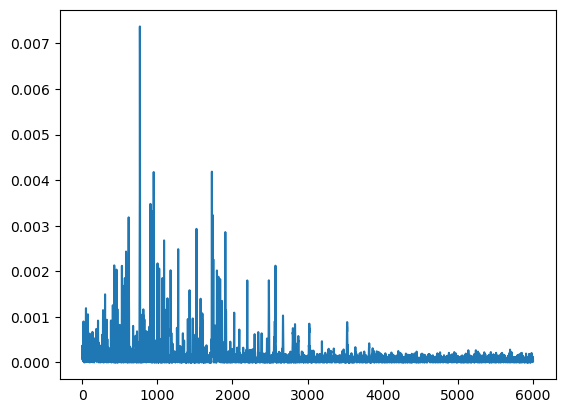

In [37]:
plt.plot(np.arange(6000), X_train[0]) # change the 0 to whatever you want to see another spectrum

# Training

Epoch 0: 100%|██████████| 263/263 [00:01<00:00, 185.32batch/s, acc=0, loss=4.63]     


Epoch 0 validation: Cross-entropy=6.27, Accuracy=2.4%


Epoch 1: 100%|██████████| 263/263 [00:01<00:00, 235.69batch/s, acc=0, loss=3.08]     


Epoch 1 validation: Cross-entropy=8.26, Accuracy=2.4%


Epoch 2: 100%|██████████| 263/263 [00:01<00:00, 215.73batch/s, acc=0, loss=2.89]     


Epoch 2 validation: Cross-entropy=8.72, Accuracy=1.9%


Epoch 3: 100%|██████████| 263/263 [00:01<00:00, 203.47batch/s, acc=0, loss=4.16]     


Epoch 3 validation: Cross-entropy=8.00, Accuracy=2.4%


Epoch 4: 100%|██████████| 263/263 [00:01<00:00, 212.69batch/s, acc=0, loss=3.63]     


Epoch 4 validation: Cross-entropy=7.80, Accuracy=2.4%


Epoch 5: 100%|██████████| 263/263 [00:01<00:00, 215.75batch/s, acc=0.125, loss=2.63] 


Epoch 5 validation: Cross-entropy=10.62, Accuracy=1.9%


Epoch 6: 100%|██████████| 263/263 [00:01<00:00, 224.79batch/s, acc=0, loss=3.42]     


Epoch 6 validation: Cross-entropy=7.13, Accuracy=2.4%


Epoch 7: 100%|██████████| 263/263 [00:01<00:00, 212.63batch/s, acc=0, loss=3.53]     


Epoch 7 validation: Cross-entropy=7.43, Accuracy=6.1%


Epoch 8: 100%|██████████| 263/263 [00:01<00:00, 207.55batch/s, acc=0, loss=3.09]     


Epoch 8 validation: Cross-entropy=7.39, Accuracy=6.1%


Epoch 9: 100%|██████████| 263/263 [00:01<00:00, 210.85batch/s, acc=0.281, loss=2.37]  


Epoch 9 validation: Cross-entropy=8.28, Accuracy=5.6%


Epoch 10: 100%|██████████| 263/263 [00:01<00:00, 221.58batch/s, acc=0.594, loss=2.26]  


Epoch 10 validation: Cross-entropy=11.16, Accuracy=5.6%


Epoch 11: 100%|██████████| 263/263 [00:01<00:00, 236.21batch/s, acc=0, loss=3.18]      


Epoch 11 validation: Cross-entropy=8.47, Accuracy=6.1%


Epoch 12: 100%|██████████| 263/263 [00:01<00:00, 235.95batch/s, acc=0, loss=3.19]     


Epoch 12 validation: Cross-entropy=7.46, Accuracy=6.1%


Epoch 13: 100%|██████████| 263/263 [00:01<00:00, 234.04batch/s, acc=0, loss=2.83]      


Epoch 13 validation: Cross-entropy=7.55, Accuracy=6.1%


Epoch 14: 100%|██████████| 263/263 [00:01<00:00, 236.24batch/s, acc=0.0625, loss=2.5] 


Epoch 14 validation: Cross-entropy=8.07, Accuracy=6.7%


Epoch 15: 100%|██████████| 263/263 [00:01<00:00, 240.40batch/s, acc=0.719, loss=2.32]  


Epoch 15 validation: Cross-entropy=9.06, Accuracy=5.5%


Epoch 16: 100%|██████████| 263/263 [00:01<00:00, 243.94batch/s, acc=0.562, loss=2.39] 


Epoch 16 validation: Cross-entropy=8.95, Accuracy=6.8%


Epoch 17: 100%|██████████| 263/263 [00:01<00:00, 237.26batch/s, acc=0.719, loss=2.07] 


Epoch 17 validation: Cross-entropy=9.72, Accuracy=5.6%


Epoch 18: 100%|██████████| 263/263 [00:01<00:00, 236.91batch/s, acc=0.719, loss=1.98] 


Epoch 18 validation: Cross-entropy=9.96, Accuracy=7.6%


Epoch 19: 100%|██████████| 263/263 [00:01<00:00, 234.82batch/s, acc=0.719, loss=1.91] 


Epoch 19 validation: Cross-entropy=10.97, Accuracy=10.6%


Epoch 20: 100%|██████████| 263/263 [00:01<00:00, 238.06batch/s, acc=0.719, loss=1.81]  


Epoch 20 validation: Cross-entropy=11.44, Accuracy=9.6%


Epoch 21: 100%|██████████| 263/263 [00:01<00:00, 209.45batch/s, acc=0.719, loss=1.62]  


Epoch 21 validation: Cross-entropy=12.18, Accuracy=7.6%


Epoch 22: 100%|██████████| 263/263 [00:01<00:00, 206.41batch/s, acc=0.719, loss=1.86]  


Epoch 22 validation: Cross-entropy=11.70, Accuracy=7.7%


Epoch 23: 100%|██████████| 263/263 [00:01<00:00, 204.33batch/s, acc=0.688, loss=1.75]  


Epoch 23 validation: Cross-entropy=11.48, Accuracy=3.9%


Epoch 24: 100%|██████████| 263/263 [00:01<00:00, 208.47batch/s, acc=0.719, loss=1.65]  


Epoch 24 validation: Cross-entropy=11.79, Accuracy=9.4%


Epoch 25: 100%|██████████| 263/263 [00:01<00:00, 204.50batch/s, acc=0.688, loss=1.48] 


Epoch 25 validation: Cross-entropy=11.60, Accuracy=8.4%


Epoch 26: 100%|██████████| 263/263 [00:01<00:00, 201.21batch/s, acc=0.719, loss=1.45] 


Epoch 26 validation: Cross-entropy=11.81, Accuracy=9.3%


Epoch 27: 100%|██████████| 263/263 [00:01<00:00, 223.46batch/s, acc=0.688, loss=1.59]  


Epoch 27 validation: Cross-entropy=12.93, Accuracy=12.8%


Epoch 28: 100%|██████████| 263/263 [00:01<00:00, 207.33batch/s, acc=0.688, loss=1.53] 


Epoch 28 validation: Cross-entropy=13.91, Accuracy=12.9%


Epoch 29: 100%|██████████| 263/263 [00:01<00:00, 210.43batch/s, acc=0.688, loss=1.8]  


Epoch 29 validation: Cross-entropy=15.29, Accuracy=13.1%


Epoch 30: 100%|██████████| 263/263 [00:01<00:00, 203.72batch/s, acc=0.688, loss=2.05]  


Epoch 30 validation: Cross-entropy=14.55, Accuracy=12.1%


Epoch 31: 100%|██████████| 263/263 [00:01<00:00, 212.57batch/s, acc=0.688, loss=1.78]  


Epoch 31 validation: Cross-entropy=13.94, Accuracy=13.0%


Epoch 32: 100%|██████████| 263/263 [00:01<00:00, 204.74batch/s, acc=0.688, loss=1.6]   


Epoch 32 validation: Cross-entropy=13.26, Accuracy=17.2%


Epoch 33: 100%|██████████| 263/263 [00:01<00:00, 208.71batch/s, acc=0.688, loss=1.68] 


Epoch 33 validation: Cross-entropy=12.13, Accuracy=17.9%


Epoch 34: 100%|██████████| 263/263 [00:01<00:00, 201.79batch/s, acc=0.688, loss=1.73]  


Epoch 34 validation: Cross-entropy=12.25, Accuracy=17.9%


Epoch 35: 100%|██████████| 263/263 [00:01<00:00, 203.97batch/s, acc=0.719, loss=1.54] 


Epoch 35 validation: Cross-entropy=12.72, Accuracy=17.3%


Epoch 36: 100%|██████████| 263/263 [00:01<00:00, 205.23batch/s, acc=0.719, loss=1.53]  


Epoch 36 validation: Cross-entropy=12.92, Accuracy=15.0%


Epoch 37: 100%|██████████| 263/263 [00:01<00:00, 205.82batch/s, acc=0.719, loss=1.26]  


Epoch 37 validation: Cross-entropy=13.18, Accuracy=12.7%


Epoch 38: 100%|██████████| 263/263 [00:01<00:00, 212.53batch/s, acc=0.719, loss=1.6]   


Epoch 38 validation: Cross-entropy=13.29, Accuracy=13.6%


Epoch 39: 100%|██████████| 263/263 [00:01<00:00, 199.47batch/s, acc=0.719, loss=1.46]  


Epoch 39 validation: Cross-entropy=13.04, Accuracy=13.6%


Epoch 40: 100%|██████████| 263/263 [00:01<00:00, 205.39batch/s, acc=0.719, loss=1.48]  


Epoch 40 validation: Cross-entropy=13.31, Accuracy=15.4%


Epoch 41: 100%|██████████| 263/263 [00:01<00:00, 207.01batch/s, acc=0.719, loss=1.38]  


Epoch 41 validation: Cross-entropy=13.23, Accuracy=17.1%


Epoch 42: 100%|██████████| 263/263 [00:01<00:00, 202.50batch/s, acc=0.719, loss=2.07]  


Epoch 42 validation: Cross-entropy=12.45, Accuracy=17.4%


Epoch 43: 100%|██████████| 263/263 [00:01<00:00, 206.05batch/s, acc=0.719, loss=1.57] 


Epoch 43 validation: Cross-entropy=12.65, Accuracy=15.2%


Epoch 44: 100%|██████████| 263/263 [00:01<00:00, 209.37batch/s, acc=0.719, loss=1.92]  


Epoch 44 validation: Cross-entropy=13.45, Accuracy=18.7%


Epoch 45: 100%|██████████| 263/263 [00:01<00:00, 235.29batch/s, acc=0.719, loss=1.19]  


Epoch 45 validation: Cross-entropy=12.01, Accuracy=20.4%


Epoch 46: 100%|██████████| 263/263 [00:01<00:00, 202.74batch/s, acc=0.719, loss=1.37]  


Epoch 46 validation: Cross-entropy=13.95, Accuracy=17.6%


Epoch 47: 100%|██████████| 263/263 [00:01<00:00, 200.49batch/s, acc=0.719, loss=1.6]   


Epoch 47 validation: Cross-entropy=17.88, Accuracy=19.5%


Epoch 48: 100%|██████████| 263/263 [00:01<00:00, 203.69batch/s, acc=0.688, loss=1.57]  


Epoch 48 validation: Cross-entropy=15.36, Accuracy=20.7%


Epoch 49: 100%|██████████| 263/263 [00:01<00:00, 203.93batch/s, acc=0.781, loss=0.967] 


Epoch 49 validation: Cross-entropy=12.58, Accuracy=23.6%


Epoch 50: 100%|██████████| 263/263 [00:01<00:00, 201.95batch/s, acc=0.812, loss=0.648] 


Epoch 50 validation: Cross-entropy=11.21, Accuracy=24.7%


Epoch 51: 100%|██████████| 263/263 [00:01<00:00, 206.62batch/s, acc=0.969, loss=0.0842]


Epoch 51 validation: Cross-entropy=8.49, Accuracy=31.7%


Epoch 52: 100%|██████████| 263/263 [00:01<00:00, 204.40batch/s, acc=0.938, loss=0.197] 


Epoch 52 validation: Cross-entropy=8.87, Accuracy=33.2%


Epoch 53: 100%|██████████| 263/263 [00:01<00:00, 205.24batch/s, acc=0.938, loss=0.121] 


Epoch 53 validation: Cross-entropy=8.87, Accuracy=32.4%


Epoch 54: 100%|██████████| 263/263 [00:01<00:00, 207.13batch/s, acc=0.875, loss=0.378] 


Epoch 54 validation: Cross-entropy=6.98, Accuracy=38.4%


Epoch 55: 100%|██████████| 263/263 [00:01<00:00, 208.27batch/s, acc=0.938, loss=0.139] 


Epoch 55 validation: Cross-entropy=7.78, Accuracy=37.3%


Epoch 56: 100%|██████████| 263/263 [00:01<00:00, 206.18batch/s, acc=0.969, loss=0.11]  


Epoch 56 validation: Cross-entropy=7.86, Accuracy=38.5%


Epoch 57: 100%|██████████| 263/263 [00:01<00:00, 203.13batch/s, acc=0.938, loss=0.206] 


Epoch 57 validation: Cross-entropy=7.72, Accuracy=37.5%


Epoch 58: 100%|██████████| 263/263 [00:01<00:00, 203.65batch/s, acc=1, loss=0.0375]    


Epoch 58 validation: Cross-entropy=8.02, Accuracy=30.0%


Epoch 59: 100%|██████████| 263/263 [00:01<00:00, 205.15batch/s, acc=0.906, loss=0.304] 


Epoch 59 validation: Cross-entropy=7.52, Accuracy=33.1%


Epoch 60: 100%|██████████| 263/263 [00:01<00:00, 207.18batch/s, acc=0.875, loss=0.535] 


Epoch 60 validation: Cross-entropy=7.97, Accuracy=34.3%


Epoch 61: 100%|██████████| 263/263 [00:01<00:00, 228.30batch/s, acc=0.938, loss=0.217] 


Epoch 61 validation: Cross-entropy=7.70, Accuracy=36.2%


Epoch 62: 100%|██████████| 263/263 [00:01<00:00, 206.63batch/s, acc=1, loss=0.0295]    


Epoch 62 validation: Cross-entropy=6.38, Accuracy=38.7%


Epoch 63: 100%|██████████| 263/263 [00:01<00:00, 199.65batch/s, acc=1, loss=0.0677]    


Epoch 63 validation: Cross-entropy=5.92, Accuracy=43.7%


Epoch 64: 100%|██████████| 263/263 [00:01<00:00, 206.94batch/s, acc=0.938, loss=0.0835]


Epoch 64 validation: Cross-entropy=4.25, Accuracy=51.0%


Epoch 65: 100%|██████████| 263/263 [00:01<00:00, 204.03batch/s, acc=0.938, loss=0.0981]


Epoch 65 validation: Cross-entropy=5.12, Accuracy=46.4%


Epoch 66: 100%|██████████| 263/263 [00:01<00:00, 204.65batch/s, acc=0.969, loss=0.04]  


Epoch 66 validation: Cross-entropy=4.31, Accuracy=51.0%


Epoch 67: 100%|██████████| 263/263 [00:01<00:00, 207.24batch/s, acc=1, loss=0.0284]    


Epoch 67 validation: Cross-entropy=4.39, Accuracy=51.9%


Epoch 68: 100%|██████████| 263/263 [00:01<00:00, 207.78batch/s, acc=0.938, loss=0.107] 


Epoch 68 validation: Cross-entropy=4.12, Accuracy=52.1%


Epoch 69: 100%|██████████| 263/263 [00:01<00:00, 202.66batch/s, acc=0.844, loss=0.292] 


Epoch 69 validation: Cross-entropy=4.16, Accuracy=53.2%


Epoch 70: 100%|██████████| 263/263 [00:01<00:00, 204.82batch/s, acc=1, loss=0.0151]    


Epoch 70 validation: Cross-entropy=3.78, Accuracy=57.0%


Epoch 71: 100%|██████████| 263/263 [00:01<00:00, 210.11batch/s, acc=1, loss=0.0204]    


Epoch 71 validation: Cross-entropy=4.10, Accuracy=56.4%


Epoch 72: 100%|██████████| 263/263 [00:01<00:00, 204.89batch/s, acc=1, loss=0.0171]    


Epoch 72 validation: Cross-entropy=3.53, Accuracy=59.3%


Epoch 73: 100%|██████████| 263/263 [00:01<00:00, 206.57batch/s, acc=0.906, loss=0.283] 


Epoch 73 validation: Cross-entropy=3.61, Accuracy=58.1%


Epoch 74: 100%|██████████| 263/263 [00:01<00:00, 211.82batch/s, acc=1, loss=0.000417]  


Epoch 74 validation: Cross-entropy=3.68, Accuracy=56.8%


Epoch 75: 100%|██████████| 263/263 [00:01<00:00, 218.89batch/s, acc=1, loss=0.0213]    


Epoch 75 validation: Cross-entropy=2.55, Accuracy=65.3%


Epoch 76: 100%|██████████| 263/263 [00:01<00:00, 219.01batch/s, acc=1, loss=0.0437]    


Epoch 76 validation: Cross-entropy=2.53, Accuracy=66.6%


Epoch 77: 100%|██████████| 263/263 [00:01<00:00, 204.96batch/s, acc=0.812, loss=0.232] 


Epoch 77 validation: Cross-entropy=2.18, Accuracy=70.7%


Epoch 78: 100%|██████████| 263/263 [00:01<00:00, 201.52batch/s, acc=1, loss=0.00283]   


Epoch 78 validation: Cross-entropy=1.77, Accuracy=73.0%


Epoch 79: 100%|██████████| 263/263 [00:01<00:00, 205.67batch/s, acc=1, loss=0.000351]  


Epoch 79 validation: Cross-entropy=1.79, Accuracy=74.3%


Epoch 80: 100%|██████████| 263/263 [00:01<00:00, 205.03batch/s, acc=1, loss=0.00412]   


Epoch 80 validation: Cross-entropy=1.80, Accuracy=73.3%


Epoch 81: 100%|██████████| 263/263 [00:01<00:00, 204.71batch/s, acc=1, loss=0.00197]   


Epoch 81 validation: Cross-entropy=1.85, Accuracy=73.9%


Epoch 82: 100%|██████████| 263/263 [00:01<00:00, 205.23batch/s, acc=1, loss=0.00198]   


Epoch 82 validation: Cross-entropy=1.71, Accuracy=77.4%


Epoch 83: 100%|██████████| 263/263 [00:01<00:00, 210.75batch/s, acc=1, loss=0.021]     


Epoch 83 validation: Cross-entropy=1.77, Accuracy=77.8%


Epoch 84: 100%|██████████| 263/263 [00:01<00:00, 218.45batch/s, acc=1, loss=0.00524]   


Epoch 84 validation: Cross-entropy=1.53, Accuracy=78.8%


Epoch 85: 100%|██████████| 263/263 [00:01<00:00, 210.13batch/s, acc=1, loss=0.0174]    


Epoch 85 validation: Cross-entropy=2.05, Accuracy=73.3%


Epoch 86: 100%|██████████| 263/263 [00:01<00:00, 211.17batch/s, acc=1, loss=0.0217]    


Epoch 86 validation: Cross-entropy=1.73, Accuracy=79.0%


Epoch 87: 100%|██████████| 263/263 [00:01<00:00, 208.05batch/s, acc=1, loss=0.00159]   


Epoch 87 validation: Cross-entropy=1.69, Accuracy=81.3%


Epoch 88: 100%|██████████| 263/263 [00:01<00:00, 205.36batch/s, acc=1, loss=0.00558]   


Epoch 88 validation: Cross-entropy=2.17, Accuracy=78.5%


Epoch 89: 100%|██████████| 263/263 [00:01<00:00, 205.75batch/s, acc=1, loss=0.00146]   


Epoch 89 validation: Cross-entropy=1.68, Accuracy=81.9%


Epoch 90: 100%|██████████| 263/263 [00:01<00:00, 200.00batch/s, acc=1, loss=0.000312]  


Epoch 90 validation: Cross-entropy=1.90, Accuracy=78.2%


Epoch 91: 100%|██████████| 263/263 [00:01<00:00, 206.92batch/s, acc=1, loss=0.00691]   


Epoch 91 validation: Cross-entropy=1.71, Accuracy=81.3%


Epoch 92: 100%|██████████| 263/263 [00:01<00:00, 211.07batch/s, acc=1, loss=0.0161]    


Epoch 92 validation: Cross-entropy=1.78, Accuracy=81.3%


Epoch 93: 100%|██████████| 263/263 [00:01<00:00, 223.85batch/s, acc=1, loss=0.00682]   


Epoch 93 validation: Cross-entropy=1.80, Accuracy=80.6%


Epoch 94: 100%|██████████| 263/263 [00:01<00:00, 225.05batch/s, acc=1, loss=0.0291]    


Epoch 94 validation: Cross-entropy=1.97, Accuracy=82.6%


Epoch 95: 100%|██████████| 263/263 [00:01<00:00, 211.45batch/s, acc=1, loss=5.04e-5]   


Epoch 95 validation: Cross-entropy=2.08, Accuracy=82.2%


Epoch 96: 100%|██████████| 263/263 [00:01<00:00, 216.92batch/s, acc=1, loss=0.00299]   


Epoch 96 validation: Cross-entropy=1.99, Accuracy=80.7%


Epoch 97: 100%|██████████| 263/263 [00:01<00:00, 214.71batch/s, acc=1, loss=0.000677]  


Epoch 97 validation: Cross-entropy=1.93, Accuracy=81.9%


Epoch 98: 100%|██████████| 263/263 [00:01<00:00, 211.26batch/s, acc=1, loss=0.000137]  


Epoch 98 validation: Cross-entropy=1.82, Accuracy=81.9%


Epoch 99: 100%|██████████| 263/263 [00:01<00:00, 226.13batch/s, acc=1, loss=0.000548]  


Epoch 99 validation: Cross-entropy=2.14, Accuracy=80.4%


Epoch 100: 100%|██████████| 263/263 [00:01<00:00, 214.12batch/s, acc=1, loss=8.69e-5]   


Epoch 100 validation: Cross-entropy=1.92, Accuracy=81.8%


Epoch 101: 100%|██████████| 263/263 [00:01<00:00, 215.64batch/s, acc=1, loss=0.000536]  


Epoch 101 validation: Cross-entropy=2.06, Accuracy=82.1%


Epoch 102: 100%|██████████| 263/263 [00:01<00:00, 210.04batch/s, acc=1, loss=0.000605]  


Epoch 102 validation: Cross-entropy=2.67, Accuracy=79.9%


Epoch 103: 100%|██████████| 263/263 [00:01<00:00, 207.72batch/s, acc=1, loss=0.0181]    


Epoch 103 validation: Cross-entropy=2.54, Accuracy=77.8%


Epoch 104: 100%|██████████| 263/263 [00:01<00:00, 214.65batch/s, acc=1, loss=0.00286]   


Epoch 104 validation: Cross-entropy=2.62, Accuracy=80.6%


Epoch 105: 100%|██████████| 263/263 [00:01<00:00, 238.31batch/s, acc=0.969, loss=0.122] 


Epoch 105 validation: Cross-entropy=2.56, Accuracy=78.4%


Epoch 106: 100%|██████████| 263/263 [00:01<00:00, 217.10batch/s, acc=1, loss=7.42e-5]   


Epoch 106 validation: Cross-entropy=2.02, Accuracy=83.2%


Epoch 107: 100%|██████████| 263/263 [00:01<00:00, 208.39batch/s, acc=1, loss=0.00161]   


Epoch 107 validation: Cross-entropy=2.06, Accuracy=81.8%


Epoch 108: 100%|██████████| 263/263 [00:01<00:00, 238.02batch/s, acc=1, loss=3.96e-5]   


Epoch 108 validation: Cross-entropy=2.08, Accuracy=83.8%


Epoch 109: 100%|██████████| 263/263 [00:01<00:00, 212.19batch/s, acc=1, loss=4.58e-5]   


Epoch 109 validation: Cross-entropy=2.09, Accuracy=83.6%


Epoch 110: 100%|██████████| 263/263 [00:01<00:00, 223.75batch/s, acc=1, loss=0.00321]   


Epoch 110 validation: Cross-entropy=2.97, Accuracy=76.7%


Epoch 111: 100%|██████████| 263/263 [00:01<00:00, 204.89batch/s, acc=1, loss=7.88e-6]   


Epoch 111 validation: Cross-entropy=2.21, Accuracy=81.4%


Epoch 112: 100%|██████████| 263/263 [00:01<00:00, 215.98batch/s, acc=1, loss=1.89e-6]   


Epoch 112 validation: Cross-entropy=2.28, Accuracy=82.6%


Epoch 113: 100%|██████████| 263/263 [00:01<00:00, 223.11batch/s, acc=1, loss=3.81e-6]   


Epoch 113 validation: Cross-entropy=2.04, Accuracy=84.1%


Epoch 114: 100%|██████████| 263/263 [00:01<00:00, 231.80batch/s, acc=1, loss=6.93e-6]   


Epoch 114 validation: Cross-entropy=1.76, Accuracy=84.1%


Epoch 115: 100%|██████████| 263/263 [00:01<00:00, 225.70batch/s, acc=1, loss=0.00133]   


Epoch 115 validation: Cross-entropy=1.97, Accuracy=82.7%


Epoch 116: 100%|██████████| 263/263 [00:01<00:00, 220.48batch/s, acc=1, loss=4.09e-5]   


Epoch 116 validation: Cross-entropy=2.24, Accuracy=83.6%


Epoch 117: 100%|██████████| 263/263 [00:01<00:00, 208.69batch/s, acc=1, loss=0.00314]   


Epoch 117 validation: Cross-entropy=2.12, Accuracy=81.1%


Epoch 118: 100%|██████████| 263/263 [00:01<00:00, 206.59batch/s, acc=0.938, loss=0.23]  


Epoch 118 validation: Cross-entropy=2.65, Accuracy=79.3%


Epoch 119: 100%|██████████| 263/263 [00:01<00:00, 206.54batch/s, acc=1, loss=8.04e-5]   


Epoch 119 validation: Cross-entropy=2.04, Accuracy=83.4%


Epoch 120: 100%|██████████| 263/263 [00:01<00:00, 205.30batch/s, acc=1, loss=0.000163]  


Epoch 120 validation: Cross-entropy=1.85, Accuracy=85.3%


Epoch 121: 100%|██████████| 263/263 [00:01<00:00, 207.79batch/s, acc=1, loss=8.76e-6]   


Epoch 121 validation: Cross-entropy=1.98, Accuracy=84.9%


Epoch 122: 100%|██████████| 263/263 [00:01<00:00, 208.44batch/s, acc=1, loss=3.99e-6]   


Epoch 122 validation: Cross-entropy=1.96, Accuracy=86.1%


Epoch 123: 100%|██████████| 263/263 [00:01<00:00, 208.00batch/s, acc=1, loss=6.89e-5]   


Epoch 123 validation: Cross-entropy=2.03, Accuracy=85.0%


Epoch 124: 100%|██████████| 263/263 [00:01<00:00, 205.83batch/s, acc=1, loss=0.000102]  


Epoch 124 validation: Cross-entropy=1.98, Accuracy=84.6%


Epoch 125: 100%|██████████| 263/263 [00:01<00:00, 209.62batch/s, acc=1, loss=3.28e-5]   


Epoch 125 validation: Cross-entropy=1.79, Accuracy=85.9%


Epoch 126: 100%|██████████| 263/263 [00:01<00:00, 214.68batch/s, acc=1, loss=0.0113]    


Epoch 126 validation: Cross-entropy=1.89, Accuracy=84.1%


Epoch 127: 100%|██████████| 263/263 [00:01<00:00, 226.74batch/s, acc=1, loss=0.000159]  


Epoch 127 validation: Cross-entropy=2.28, Accuracy=80.8%


Epoch 128: 100%|██████████| 263/263 [00:01<00:00, 208.12batch/s, acc=1, loss=7.47e-5]   


Epoch 128 validation: Cross-entropy=1.79, Accuracy=83.7%


Epoch 129: 100%|██████████| 263/263 [00:01<00:00, 204.89batch/s, acc=1, loss=6.62e-6]   


Epoch 129 validation: Cross-entropy=2.07, Accuracy=87.0%


Epoch 130: 100%|██████████| 263/263 [00:01<00:00, 201.49batch/s, acc=1, loss=0.000154]  


Epoch 130 validation: Cross-entropy=2.13, Accuracy=84.6%


Epoch 131: 100%|██████████| 263/263 [00:01<00:00, 202.47batch/s, acc=1, loss=5.81e-5]   


Epoch 131 validation: Cross-entropy=2.05, Accuracy=85.7%


Epoch 132: 100%|██████████| 263/263 [00:01<00:00, 205.77batch/s, acc=1, loss=3.73e-6]   


Epoch 132 validation: Cross-entropy=2.27, Accuracy=84.1%


Epoch 133: 100%|██████████| 263/263 [00:01<00:00, 206.08batch/s, acc=1, loss=7.62e-6]   


Epoch 133 validation: Cross-entropy=1.96, Accuracy=85.4%


Epoch 134: 100%|██████████| 263/263 [00:01<00:00, 208.35batch/s, acc=1, loss=4.82e-6]   


Epoch 134 validation: Cross-entropy=2.15, Accuracy=85.2%


Epoch 135: 100%|██████████| 263/263 [00:01<00:00, 205.46batch/s, acc=1, loss=0.000139]  


Epoch 135 validation: Cross-entropy=2.25, Accuracy=84.3%


Epoch 136: 100%|██████████| 263/263 [00:01<00:00, 210.30batch/s, acc=1, loss=0.0016]    


Epoch 136 validation: Cross-entropy=2.56, Accuracy=81.3%


Epoch 137: 100%|██████████| 263/263 [00:01<00:00, 219.18batch/s, acc=0.938, loss=0.121] 


Epoch 137 validation: Cross-entropy=2.78, Accuracy=82.4%


Epoch 138: 100%|██████████| 263/263 [00:01<00:00, 211.67batch/s, acc=1, loss=0.0066]    


Epoch 138 validation: Cross-entropy=2.08, Accuracy=85.6%


Epoch 139: 100%|██████████| 263/263 [00:01<00:00, 205.05batch/s, acc=1, loss=2.35e-5]   


Epoch 139 validation: Cross-entropy=2.43, Accuracy=79.9%


Epoch 140: 100%|██████████| 263/263 [00:01<00:00, 205.78batch/s, acc=1, loss=5.35e-6]   


Epoch 140 validation: Cross-entropy=2.51, Accuracy=84.3%


Epoch 141: 100%|██████████| 263/263 [00:01<00:00, 206.91batch/s, acc=1, loss=1.54e-6]   


Epoch 141 validation: Cross-entropy=2.08, Accuracy=86.5%


Epoch 142: 100%|██████████| 263/263 [00:01<00:00, 209.10batch/s, acc=1, loss=7.45e-8]   


Epoch 142 validation: Cross-entropy=2.26, Accuracy=85.0%


Epoch 143: 100%|██████████| 263/263 [00:01<00:00, 218.83batch/s, acc=1, loss=5.47e-6]   


Epoch 143 validation: Cross-entropy=2.20, Accuracy=85.6%


Epoch 144: 100%|██████████| 263/263 [00:01<00:00, 207.90batch/s, acc=1, loss=8.79e-6]   


Epoch 144 validation: Cross-entropy=2.35, Accuracy=85.7%


Epoch 145: 100%|██████████| 263/263 [00:01<00:00, 214.51batch/s, acc=1, loss=4.91e-5]   


Epoch 145 validation: Cross-entropy=2.92, Accuracy=82.4%


Epoch 146: 100%|██████████| 263/263 [00:01<00:00, 237.16batch/s, acc=1, loss=2.16e-5]   


Epoch 146 validation: Cross-entropy=2.00, Accuracy=87.3%


Epoch 147: 100%|██████████| 263/263 [00:01<00:00, 209.13batch/s, acc=1, loss=2.83e-7]   


Epoch 147 validation: Cross-entropy=2.05, Accuracy=87.6%


Epoch 148: 100%|██████████| 263/263 [00:01<00:00, 204.56batch/s, acc=1, loss=2.27e-5]   


Epoch 148 validation: Cross-entropy=2.26, Accuracy=86.4%


Epoch 149: 100%|██████████| 263/263 [00:01<00:00, 207.39batch/s, acc=1, loss=0.000732]  


Epoch 149 validation: Cross-entropy=2.79, Accuracy=81.3%


Epoch 150: 100%|██████████| 263/263 [00:01<00:00, 204.44batch/s, acc=1, loss=0.000515]  


Epoch 150 validation: Cross-entropy=2.64, Accuracy=85.4%


Epoch 151: 100%|██████████| 263/263 [00:01<00:00, 203.56batch/s, acc=1, loss=0.000121]  


Epoch 151 validation: Cross-entropy=2.46, Accuracy=83.6%


Epoch 152: 100%|██████████| 263/263 [00:01<00:00, 220.47batch/s, acc=1, loss=1.78e-5]   


Epoch 152 validation: Cross-entropy=2.49, Accuracy=86.5%


Epoch 153: 100%|██████████| 263/263 [00:01<00:00, 222.26batch/s, acc=1, loss=7.53e-5]   


Epoch 153 validation: Cross-entropy=2.39, Accuracy=86.0%


Epoch 154: 100%|██████████| 263/263 [00:01<00:00, 210.63batch/s, acc=1, loss=7.85e-5]   


Epoch 154 validation: Cross-entropy=2.64, Accuracy=83.7%


Epoch 155: 100%|██████████| 263/263 [00:01<00:00, 205.65batch/s, acc=1, loss=0.00221]   


Epoch 155 validation: Cross-entropy=2.62, Accuracy=86.0%


Epoch 156: 100%|██████████| 263/263 [00:01<00:00, 208.81batch/s, acc=1, loss=2.51e-6]   


Epoch 156 validation: Cross-entropy=2.30, Accuracy=87.3%


Epoch 157: 100%|██████████| 263/263 [00:01<00:00, 205.29batch/s, acc=1, loss=5.6e-6]    


Epoch 157 validation: Cross-entropy=2.60, Accuracy=85.5%


Epoch 158: 100%|██████████| 263/263 [00:01<00:00, 204.20batch/s, acc=1, loss=5.76e-5]   


Epoch 158 validation: Cross-entropy=3.22, Accuracy=80.0%


Epoch 159: 100%|██████████| 263/263 [00:01<00:00, 217.30batch/s, acc=1, loss=2.3e-5]    


Epoch 159 validation: Cross-entropy=2.94, Accuracy=84.1%


Epoch 160: 100%|██████████| 263/263 [00:01<00:00, 202.53batch/s, acc=1, loss=0.0124]    


Epoch 160 validation: Cross-entropy=3.34, Accuracy=75.3%


Epoch 161: 100%|██████████| 263/263 [00:01<00:00, 206.50batch/s, acc=1, loss=2.77e-6]   


Epoch 161 validation: Cross-entropy=3.13, Accuracy=80.7%


Epoch 162: 100%|██████████| 263/263 [00:01<00:00, 204.22batch/s, acc=1, loss=3.25e-6]   


Epoch 162 validation: Cross-entropy=3.16, Accuracy=79.9%


Epoch 163: 100%|██████████| 263/263 [00:01<00:00, 215.41batch/s, acc=1, loss=5.81e-7]   


Epoch 163 validation: Cross-entropy=2.65, Accuracy=85.0%


Epoch 164: 100%|██████████| 263/263 [00:01<00:00, 202.89batch/s, acc=1, loss=8.65e-6]   


Epoch 164 validation: Cross-entropy=2.80, Accuracy=82.4%


Epoch 165: 100%|██████████| 263/263 [00:01<00:00, 217.49batch/s, acc=1, loss=0.00427]   


Epoch 165 validation: Cross-entropy=2.61, Accuracy=84.9%


Epoch 166: 100%|██████████| 263/263 [00:01<00:00, 206.77batch/s, acc=1, loss=9.2e-7]    


Epoch 166 validation: Cross-entropy=2.82, Accuracy=83.3%


Epoch 167: 100%|██████████| 263/263 [00:01<00:00, 205.53batch/s, acc=1, loss=0.0002]    


Epoch 167 validation: Cross-entropy=2.73, Accuracy=84.4%


Epoch 168: 100%|██████████| 263/263 [00:01<00:00, 203.03batch/s, acc=1, loss=7.13e-6]  


Epoch 168 validation: Cross-entropy=2.79, Accuracy=84.4%


Epoch 169: 100%|██████████| 263/263 [00:01<00:00, 203.21batch/s, acc=1, loss=1.08e-7]   


Epoch 169 validation: Cross-entropy=2.65, Accuracy=86.1%


Epoch 170: 100%|██████████| 263/263 [00:01<00:00, 204.20batch/s, acc=1, loss=0.000325]  


Epoch 170 validation: Cross-entropy=2.76, Accuracy=85.3%


Epoch 171: 100%|██████████| 263/263 [00:01<00:00, 201.77batch/s, acc=1, loss=7.3e-7]    


Epoch 171 validation: Cross-entropy=3.02, Accuracy=83.0%


Epoch 172: 100%|██████████| 263/263 [00:01<00:00, 203.01batch/s, acc=1, loss=5.79e-6]   


Epoch 172 validation: Cross-entropy=4.05, Accuracy=78.1%


Epoch 173: 100%|██████████| 263/263 [00:01<00:00, 204.65batch/s, acc=1, loss=9.34e-5]   


Epoch 173 validation: Cross-entropy=4.82, Accuracy=78.4%


Epoch 174: 100%|██████████| 263/263 [00:01<00:00, 241.04batch/s, acc=0.969, loss=0.0887]


Epoch 174 validation: Cross-entropy=3.43, Accuracy=82.4%


Epoch 175: 100%|██████████| 263/263 [00:01<00:00, 227.15batch/s, acc=1, loss=4.47e-8]   


Epoch 175 validation: Cross-entropy=2.54, Accuracy=84.7%


Epoch 176: 100%|██████████| 263/263 [00:01<00:00, 223.45batch/s, acc=1, loss=3.73e-9]   


Epoch 176 validation: Cross-entropy=2.73, Accuracy=83.6%


Epoch 177: 100%|██████████| 263/263 [00:01<00:00, 221.10batch/s, acc=1, loss=9.31e-8]   


Epoch 177 validation: Cross-entropy=2.97, Accuracy=84.1%


Epoch 178: 100%|██████████| 263/263 [00:01<00:00, 218.49batch/s, acc=1, loss=3.73e-9]   


Epoch 178 validation: Cross-entropy=2.54, Accuracy=86.1%


Epoch 179: 100%|██████████| 263/263 [00:01<00:00, 207.42batch/s, acc=1, loss=1.75e-7]  


Epoch 179 validation: Cross-entropy=2.84, Accuracy=84.4%


Epoch 180: 100%|██████████| 263/263 [00:01<00:00, 200.99batch/s, acc=1, loss=3.35e-8]   


Epoch 180 validation: Cross-entropy=2.64, Accuracy=85.8%


Epoch 181: 100%|██████████| 263/263 [00:01<00:00, 203.00batch/s, acc=1, loss=3.2e-7]    


Epoch 181 validation: Cross-entropy=2.76, Accuracy=86.0%


Epoch 182: 100%|██████████| 263/263 [00:01<00:00, 205.58batch/s, acc=1, loss=4.99e-7]  


Epoch 182 validation: Cross-entropy=2.67, Accuracy=86.7%


Epoch 183: 100%|██████████| 263/263 [00:01<00:00, 205.16batch/s, acc=1, loss=1.34e-7]  


Epoch 183 validation: Cross-entropy=2.63, Accuracy=86.7%


Epoch 184: 100%|██████████| 263/263 [00:01<00:00, 203.82batch/s, acc=1, loss=5.03e-6]   


Epoch 184 validation: Cross-entropy=2.59, Accuracy=86.7%


Epoch 185: 100%|██████████| 263/263 [00:01<00:00, 201.78batch/s, acc=1, loss=1.08e-7]   


Epoch 185 validation: Cross-entropy=2.47, Accuracy=85.7%


Epoch 186: 100%|██████████| 263/263 [00:01<00:00, 203.74batch/s, acc=1, loss=5.03e-5]   


Epoch 186 validation: Cross-entropy=4.66, Accuracy=78.7%


Epoch 187: 100%|██████████| 263/263 [00:01<00:00, 205.74batch/s, acc=1, loss=1.49e-8]   


Epoch 187 validation: Cross-entropy=3.93, Accuracy=82.0%


Epoch 188: 100%|██████████| 263/263 [00:01<00:00, 203.22batch/s, acc=1, loss=4.4e-7]    


Epoch 188 validation: Cross-entropy=2.91, Accuracy=85.9%


Epoch 189: 100%|██████████| 263/263 [00:01<00:00, 202.36batch/s, acc=1, loss=7.01e-5]   


Epoch 189 validation: Cross-entropy=2.89, Accuracy=86.6%


Epoch 190: 100%|██████████| 263/263 [00:01<00:00, 202.31batch/s, acc=1, loss=2.24e-8]  


Epoch 190 validation: Cross-entropy=3.14, Accuracy=84.5%


Epoch 191: 100%|██████████| 263/263 [00:01<00:00, 207.41batch/s, acc=1, loss=0.00103]   


Epoch 191 validation: Cross-entropy=2.82, Accuracy=86.8%


Epoch 192: 100%|██████████| 263/263 [00:01<00:00, 207.39batch/s, acc=1, loss=6.68e-5]   


Epoch 192 validation: Cross-entropy=2.48, Accuracy=87.9%


Epoch 193: 100%|██████████| 263/263 [00:01<00:00, 206.20batch/s, acc=1, loss=7.81e-5]   


Epoch 193 validation: Cross-entropy=2.67, Accuracy=86.2%


Epoch 194: 100%|██████████| 263/263 [00:01<00:00, 205.96batch/s, acc=1, loss=5.22e-8]   


Epoch 194 validation: Cross-entropy=2.45, Accuracy=87.9%


Epoch 195: 100%|██████████| 263/263 [00:01<00:00, 210.86batch/s, acc=1, loss=1.04e-7]   


Epoch 195 validation: Cross-entropy=2.71, Accuracy=86.8%


Epoch 196: 100%|██████████| 263/263 [00:01<00:00, 207.78batch/s, acc=1, loss=1.52e-6]   


Epoch 196 validation: Cross-entropy=3.02, Accuracy=86.7%


Epoch 197: 100%|██████████| 263/263 [00:01<00:00, 204.89batch/s, acc=1, loss=5.59e-8] 


Epoch 197 validation: Cross-entropy=2.88, Accuracy=87.6%


Epoch 198: 100%|██████████| 263/263 [00:01<00:00, 205.61batch/s, acc=1, loss=1.21e-6]   


Epoch 198 validation: Cross-entropy=2.68, Accuracy=86.4%


Epoch 199: 100%|██████████| 263/263 [00:01<00:00, 223.39batch/s, acc=1, loss=7.62e-6]   


Epoch 199 validation: Cross-entropy=3.08, Accuracy=84.8%


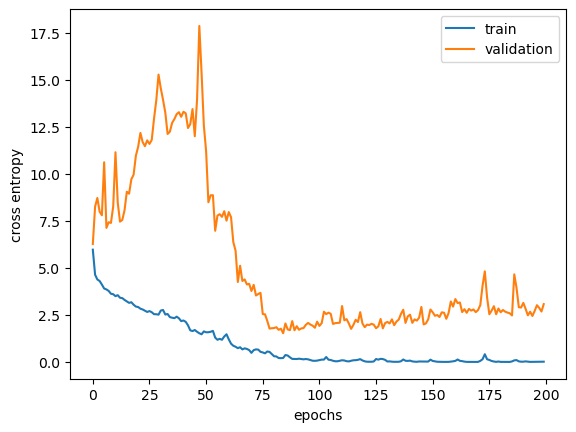

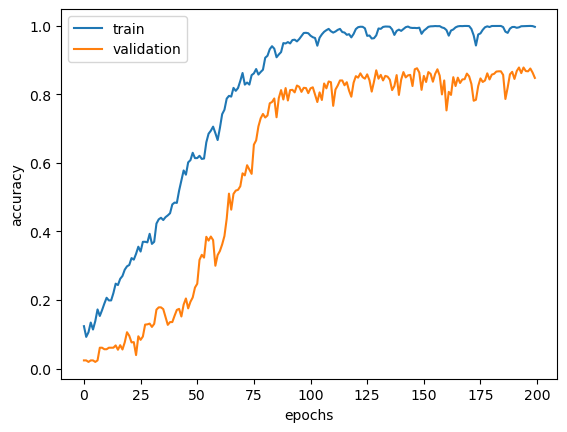

In [12]:
model = MLP(X_train, y_train) 
test = NN_train(model, X_train, X_val, y_train, y_val, 32, 0.005, device) # Almost 9 min if run on cpu vs 4 min if run on cpu

torch.Size([224, 5, 2793])
batches_per_epoch 7


Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 59.69batch/s, acc=0, loss=30.2]


Epoch 0 validation: Cross-entropy=11.12, Accuracy=0.9%


Epoch 1: 100%|██████████| 7/7 [00:00<00:00, 60.03batch/s, acc=0, loss=5.45]     


Epoch 1 validation: Cross-entropy=5.24, Accuracy=7.6%


Epoch 2: 100%|██████████| 7/7 [00:00<00:00, 60.20batch/s, acc=0, loss=5.47]    


Epoch 2 validation: Cross-entropy=5.16, Accuracy=10.3%


Epoch 3: 100%|██████████| 7/7 [00:00<00:00, 60.23batch/s, acc=0, loss=5.44]     


Epoch 3 validation: Cross-entropy=5.03, Accuracy=12.1%


Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 60.37batch/s, acc=0, loss=5.39]     


Epoch 4 validation: Cross-entropy=4.83, Accuracy=13.4%


Epoch 5: 100%|██████████| 7/7 [00:00<00:00, 60.39batch/s, acc=0, loss=5.48]     


Epoch 5 validation: Cross-entropy=4.48, Accuracy=16.5%


Epoch 6: 100%|██████████| 7/7 [00:00<00:00, 60.46batch/s, acc=0, loss=5.38]    


Epoch 6 validation: Cross-entropy=4.07, Accuracy=25.0%


Epoch 7: 100%|██████████| 7/7 [00:00<00:00, 60.20batch/s, acc=0.0312, loss=5.3] 


Epoch 7 validation: Cross-entropy=3.59, Accuracy=31.2%


Epoch 8: 100%|██████████| 7/7 [00:00<00:00, 60.42batch/s, acc=0.0625, loss=4.92]


Epoch 8 validation: Cross-entropy=3.11, Accuracy=42.4%


Epoch 9: 100%|██████████| 7/7 [00:00<00:00, 60.91batch/s, acc=0.0312, loss=4.71]


Epoch 9 validation: Cross-entropy=2.65, Accuracy=45.1%


Epoch 10: 100%|██████████| 7/7 [00:00<00:00, 61.35batch/s, acc=0.125, loss=3.84] 


Epoch 10 validation: Cross-entropy=2.35, Accuracy=46.0%


Epoch 11: 100%|██████████| 7/7 [00:00<00:00, 61.46batch/s, acc=0.0938, loss=3.52]


Epoch 11 validation: Cross-entropy=2.11, Accuracy=53.1%


Epoch 12: 100%|██████████| 7/7 [00:00<00:00, 61.41batch/s, acc=0.188, loss=3.49] 


Epoch 12 validation: Cross-entropy=2.01, Accuracy=53.6%


Epoch 13: 100%|██████████| 7/7 [00:00<00:00, 61.40batch/s, acc=0.156, loss=3.45] 


Epoch 13 validation: Cross-entropy=1.90, Accuracy=57.1%


Epoch 14: 100%|██████████| 7/7 [00:00<00:00, 61.28batch/s, acc=0.188, loss=2.95] 


Epoch 14 validation: Cross-entropy=1.71, Accuracy=59.8%


Epoch 15: 100%|██████████| 7/7 [00:00<00:00, 61.46batch/s, acc=0.344, loss=2.84] 


Epoch 15 validation: Cross-entropy=1.60, Accuracy=62.5%


Epoch 16: 100%|██████████| 7/7 [00:00<00:00, 61.45batch/s, acc=0.281, loss=2.65] 


Epoch 16 validation: Cross-entropy=1.44, Accuracy=63.8%


Epoch 17: 100%|██████████| 7/7 [00:00<00:00, 61.46batch/s, acc=0.312, loss=2.39] 


Epoch 17 validation: Cross-entropy=1.30, Accuracy=70.5%


Epoch 18: 100%|██████████| 7/7 [00:00<00:00, 61.46batch/s, acc=0.312, loss=2.49]  


Epoch 18 validation: Cross-entropy=1.20, Accuracy=69.6%


Epoch 19: 100%|██████████| 7/7 [00:00<00:00, 61.29batch/s, acc=0.375, loss=2.51]  


Epoch 19 validation: Cross-entropy=1.17, Accuracy=68.8%


Epoch 20: 100%|██████████| 7/7 [00:00<00:00, 61.40batch/s, acc=0.375, loss=2.27] 


Epoch 20 validation: Cross-entropy=1.16, Accuracy=70.1%


Epoch 21: 100%|██████████| 7/7 [00:00<00:00, 61.36batch/s, acc=0.406, loss=2.19]  


Epoch 21 validation: Cross-entropy=1.16, Accuracy=71.9%


Epoch 22: 100%|██████████| 7/7 [00:00<00:00, 61.47batch/s, acc=0.5, loss=2.12]   


Epoch 22 validation: Cross-entropy=1.12, Accuracy=72.3%


Epoch 23: 100%|██████████| 7/7 [00:00<00:00, 61.18batch/s, acc=0.438, loss=2.19] 


Epoch 23 validation: Cross-entropy=1.05, Accuracy=72.8%


Epoch 24: 100%|██████████| 7/7 [00:00<00:00, 61.29batch/s, acc=0.406, loss=2]    


Epoch 24 validation: Cross-entropy=1.01, Accuracy=75.4%


Epoch 25: 100%|██████████| 7/7 [00:00<00:00, 61.25batch/s, acc=0.438, loss=1.82] 


Epoch 25 validation: Cross-entropy=1.02, Accuracy=73.2%


Epoch 26: 100%|██████████| 7/7 [00:00<00:00, 59.63batch/s, acc=0.375, loss=2.04] 


Epoch 26 validation: Cross-entropy=0.97, Accuracy=75.0%


Epoch 27: 100%|██████████| 7/7 [00:00<00:00, 60.02batch/s, acc=0.469, loss=1.8]   


Epoch 27 validation: Cross-entropy=0.92, Accuracy=77.7%


Epoch 28: 100%|██████████| 7/7 [00:00<00:00, 60.34batch/s, acc=0.594, loss=1.4]  


Epoch 28 validation: Cross-entropy=0.82, Accuracy=78.6%


Epoch 29: 100%|██████████| 7/7 [00:00<00:00, 60.89batch/s, acc=0.562, loss=1.39] 


Epoch 29 validation: Cross-entropy=0.76, Accuracy=79.5%


Epoch 30: 100%|██████████| 7/7 [00:00<00:00, 61.04batch/s, acc=0.5, loss=1.46]    


Epoch 30 validation: Cross-entropy=0.81, Accuracy=79.0%


Epoch 31: 100%|██████████| 7/7 [00:00<00:00, 61.32batch/s, acc=0.5, loss=1.88]    


Epoch 31 validation: Cross-entropy=0.83, Accuracy=78.1%


Epoch 32: 100%|██████████| 7/7 [00:00<00:00, 60.80batch/s, acc=0.5, loss=1.73]   


Epoch 32 validation: Cross-entropy=0.93, Accuracy=76.3%


Epoch 33: 100%|██████████| 7/7 [00:00<00:00, 60.92batch/s, acc=0.656, loss=1.27] 


Epoch 33 validation: Cross-entropy=0.81, Accuracy=79.5%


Epoch 34: 100%|██████████| 7/7 [00:00<00:00, 60.88batch/s, acc=0.594, loss=1.26] 


Epoch 34 validation: Cross-entropy=0.80, Accuracy=78.6%


Epoch 35: 100%|██████████| 7/7 [00:00<00:00, 60.99batch/s, acc=0.594, loss=1.26] 


Epoch 35 validation: Cross-entropy=0.72, Accuracy=82.6%


Epoch 36: 100%|██████████| 7/7 [00:00<00:00, 61.30batch/s, acc=0.719, loss=0.933] 


Epoch 36 validation: Cross-entropy=0.68, Accuracy=83.0%


Epoch 37: 100%|██████████| 7/7 [00:00<00:00, 61.41batch/s, acc=0.656, loss=1.29]  


Epoch 37 validation: Cross-entropy=0.68, Accuracy=83.0%


Epoch 38: 100%|██████████| 7/7 [00:00<00:00, 61.21batch/s, acc=0.688, loss=1.03]  


Epoch 38 validation: Cross-entropy=0.66, Accuracy=82.6%


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 60.92batch/s, acc=0.531, loss=1.67]  


Epoch 39 validation: Cross-entropy=0.70, Accuracy=81.7%


Epoch 40: 100%|██████████| 7/7 [00:00<00:00, 60.94batch/s, acc=0.719, loss=1.14] 


Epoch 40 validation: Cross-entropy=0.73, Accuracy=80.4%


Epoch 41: 100%|██████████| 7/7 [00:00<00:00, 61.09batch/s, acc=0.656, loss=1.18] 


Epoch 41 validation: Cross-entropy=0.76, Accuracy=79.9%


Epoch 42: 100%|██████████| 7/7 [00:00<00:00, 61.26batch/s, acc=0.781, loss=0.678] 


Epoch 42 validation: Cross-entropy=0.76, Accuracy=80.8%


Epoch 43: 100%|██████████| 7/7 [00:00<00:00, 61.31batch/s, acc=0.812, loss=0.795]


Epoch 43 validation: Cross-entropy=0.66, Accuracy=86.6%


Epoch 44: 100%|██████████| 7/7 [00:00<00:00, 61.49batch/s, acc=0.781, loss=0.738]


Epoch 44 validation: Cross-entropy=0.62, Accuracy=86.2%


Epoch 45: 100%|██████████| 7/7 [00:00<00:00, 61.46batch/s, acc=0.844, loss=0.681] 


Epoch 45 validation: Cross-entropy=0.58, Accuracy=85.7%


Epoch 46: 100%|██████████| 7/7 [00:00<00:00, 61.53batch/s, acc=0.781, loss=0.784]


Epoch 46 validation: Cross-entropy=0.54, Accuracy=85.7%


Epoch 47: 100%|██████████| 7/7 [00:00<00:00, 61.43batch/s, acc=0.844, loss=0.525] 


Epoch 47 validation: Cross-entropy=0.56, Accuracy=83.0%


Epoch 48: 100%|██████████| 7/7 [00:00<00:00, 61.38batch/s, acc=0.719, loss=0.747] 


Epoch 48 validation: Cross-entropy=0.50, Accuracy=88.4%


Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 61.50batch/s, acc=0.688, loss=0.934]


Epoch 49 validation: Cross-entropy=0.61, Accuracy=82.1%


Epoch 50: 100%|██████████| 7/7 [00:00<00:00, 61.43batch/s, acc=0.781, loss=0.63]  


Epoch 50 validation: Cross-entropy=0.57, Accuracy=85.7%


Epoch 51: 100%|██████████| 7/7 [00:00<00:00, 61.36batch/s, acc=0.719, loss=1.11] 


Epoch 51 validation: Cross-entropy=0.60, Accuracy=84.8%


Epoch 52: 100%|██████████| 7/7 [00:00<00:00, 61.51batch/s, acc=0.688, loss=0.896]


Epoch 52 validation: Cross-entropy=0.67, Accuracy=81.3%


Epoch 53: 100%|██████████| 7/7 [00:00<00:00, 61.44batch/s, acc=0.75, loss=0.742] 


Epoch 53 validation: Cross-entropy=0.75, Accuracy=81.7%


Epoch 54: 100%|██████████| 7/7 [00:00<00:00, 61.48batch/s, acc=0.75, loss=0.666] 


Epoch 54 validation: Cross-entropy=0.64, Accuracy=82.6%


Epoch 55: 100%|██████████| 7/7 [00:00<00:00, 61.26batch/s, acc=0.875, loss=0.469] 


Epoch 55 validation: Cross-entropy=0.57, Accuracy=84.8%


Epoch 56: 100%|██████████| 7/7 [00:00<00:00, 61.81batch/s, acc=0.75, loss=0.766] 


Epoch 56 validation: Cross-entropy=0.52, Accuracy=84.8%


Epoch 57: 100%|██████████| 7/7 [00:00<00:00, 62.96batch/s, acc=0.688, loss=0.768]


Epoch 57 validation: Cross-entropy=0.58, Accuracy=85.7%


Epoch 58: 100%|██████████| 7/7 [00:00<00:00, 62.68batch/s, acc=0.844, loss=0.835] 


Epoch 58 validation: Cross-entropy=0.61, Accuracy=83.0%


Epoch 59: 100%|██████████| 7/7 [00:00<00:00, 61.83batch/s, acc=0.875, loss=0.607] 


Epoch 59 validation: Cross-entropy=0.54, Accuracy=86.2%


Epoch 60: 100%|██████████| 7/7 [00:00<00:00, 62.32batch/s, acc=0.75, loss=0.862] 


Epoch 60 validation: Cross-entropy=0.49, Accuracy=86.6%


Epoch 61: 100%|██████████| 7/7 [00:00<00:00, 62.18batch/s, acc=0.781, loss=0.608]


Epoch 61 validation: Cross-entropy=0.51, Accuracy=86.6%


Epoch 62: 100%|██████████| 7/7 [00:00<00:00, 62.30batch/s, acc=0.719, loss=0.752] 


Epoch 62 validation: Cross-entropy=0.51, Accuracy=88.4%


Epoch 63: 100%|██████████| 7/7 [00:00<00:00, 62.30batch/s, acc=0.812, loss=0.534]


Epoch 63 validation: Cross-entropy=0.46, Accuracy=88.8%


Epoch 64: 100%|██████████| 7/7 [00:00<00:00, 61.98batch/s, acc=0.875, loss=0.36]  


Epoch 64 validation: Cross-entropy=0.50, Accuracy=86.6%


Epoch 65: 100%|██████████| 7/7 [00:00<00:00, 61.54batch/s, acc=0.875, loss=0.512] 


Epoch 65 validation: Cross-entropy=0.51, Accuracy=86.6%


Epoch 66: 100%|██████████| 7/7 [00:00<00:00, 61.61batch/s, acc=0.781, loss=0.552] 


Epoch 66 validation: Cross-entropy=0.46, Accuracy=88.8%


Epoch 67: 100%|██████████| 7/7 [00:00<00:00, 61.34batch/s, acc=0.844, loss=0.507]


Epoch 67 validation: Cross-entropy=0.43, Accuracy=88.4%


Epoch 68: 100%|██████████| 7/7 [00:00<00:00, 61.27batch/s, acc=0.781, loss=0.636] 


Epoch 68 validation: Cross-entropy=0.47, Accuracy=87.5%


Epoch 69: 100%|██████████| 7/7 [00:00<00:00, 61.44batch/s, acc=0.875, loss=0.405] 


Epoch 69 validation: Cross-entropy=0.46, Accuracy=87.5%


Epoch 70: 100%|██████████| 7/7 [00:00<00:00, 61.26batch/s, acc=0.812, loss=0.401]


Epoch 70 validation: Cross-entropy=0.49, Accuracy=86.6%


Epoch 71: 100%|██████████| 7/7 [00:00<00:00, 61.34batch/s, acc=0.906, loss=0.393]


Epoch 71 validation: Cross-entropy=0.52, Accuracy=86.6%


Epoch 72: 100%|██████████| 7/7 [00:00<00:00, 61.40batch/s, acc=0.812, loss=0.551] 


Epoch 72 validation: Cross-entropy=0.46, Accuracy=88.4%


Epoch 73: 100%|██████████| 7/7 [00:00<00:00, 61.39batch/s, acc=0.906, loss=0.232] 


Epoch 73 validation: Cross-entropy=0.50, Accuracy=84.8%


Epoch 74: 100%|██████████| 7/7 [00:00<00:00, 61.37batch/s, acc=0.812, loss=0.494] 


Epoch 74 validation: Cross-entropy=0.54, Accuracy=84.4%


Epoch 75: 100%|██████████| 7/7 [00:00<00:00, 61.26batch/s, acc=0.875, loss=0.422]


Epoch 75 validation: Cross-entropy=0.60, Accuracy=83.0%


Epoch 76: 100%|██████████| 7/7 [00:00<00:00, 61.40batch/s, acc=0.844, loss=0.447] 


Epoch 76 validation: Cross-entropy=0.63, Accuracy=83.9%


Epoch 77: 100%|██████████| 7/7 [00:00<00:00, 61.35batch/s, acc=0.875, loss=0.377] 


Epoch 77 validation: Cross-entropy=0.44, Accuracy=88.4%


Epoch 78: 100%|██████████| 7/7 [00:00<00:00, 61.38batch/s, acc=0.938, loss=0.233] 


Epoch 78 validation: Cross-entropy=0.49, Accuracy=87.1%


Epoch 79: 100%|██████████| 7/7 [00:00<00:00, 61.30batch/s, acc=0.781, loss=0.546] 


Epoch 79 validation: Cross-entropy=0.47, Accuracy=88.4%


Epoch 80: 100%|██████████| 7/7 [00:00<00:00, 61.21batch/s, acc=0.938, loss=0.234]


Epoch 80 validation: Cross-entropy=0.47, Accuracy=86.6%


Epoch 81: 100%|██████████| 7/7 [00:00<00:00, 61.32batch/s, acc=0.906, loss=0.262] 


Epoch 81 validation: Cross-entropy=0.46, Accuracy=88.4%


Epoch 82: 100%|██████████| 7/7 [00:00<00:00, 61.39batch/s, acc=0.875, loss=0.488] 


Epoch 82 validation: Cross-entropy=0.48, Accuracy=87.9%


Epoch 83: 100%|██████████| 7/7 [00:00<00:00, 61.14batch/s, acc=0.969, loss=0.171] 


Epoch 83 validation: Cross-entropy=0.46, Accuracy=87.9%


Epoch 84: 100%|██████████| 7/7 [00:00<00:00, 62.47batch/s, acc=0.875, loss=0.257] 


Epoch 84 validation: Cross-entropy=0.42, Accuracy=88.4%


Epoch 85: 100%|██████████| 7/7 [00:00<00:00, 62.53batch/s, acc=0.906, loss=0.367] 


Epoch 85 validation: Cross-entropy=0.42, Accuracy=87.9%


Epoch 86: 100%|██████████| 7/7 [00:00<00:00, 61.16batch/s, acc=1, loss=0.146]     


Epoch 86 validation: Cross-entropy=0.39, Accuracy=88.8%


Epoch 87: 100%|██████████| 7/7 [00:00<00:00, 60.87batch/s, acc=0.906, loss=0.346] 


Epoch 87 validation: Cross-entropy=0.40, Accuracy=88.8%


Epoch 88: 100%|██████████| 7/7 [00:00<00:00, 60.63batch/s, acc=0.875, loss=0.225]


Epoch 88 validation: Cross-entropy=0.40, Accuracy=88.4%


Epoch 89: 100%|██████████| 7/7 [00:00<00:00, 61.10batch/s, acc=0.938, loss=0.216]


Epoch 89 validation: Cross-entropy=0.40, Accuracy=88.4%


Epoch 90: 100%|██████████| 7/7 [00:00<00:00, 61.04batch/s, acc=0.938, loss=0.115] 


Epoch 90 validation: Cross-entropy=0.45, Accuracy=88.8%


Epoch 91: 100%|██████████| 7/7 [00:00<00:00, 61.27batch/s, acc=0.844, loss=0.504] 


Epoch 91 validation: Cross-entropy=0.44, Accuracy=88.4%


Epoch 92: 100%|██████████| 7/7 [00:00<00:00, 61.65batch/s, acc=0.875, loss=0.479] 


Epoch 92 validation: Cross-entropy=0.45, Accuracy=87.5%


Epoch 93: 100%|██████████| 7/7 [00:00<00:00, 62.18batch/s, acc=0.844, loss=0.409]


Epoch 93 validation: Cross-entropy=0.48, Accuracy=87.9%


Epoch 94: 100%|██████████| 7/7 [00:00<00:00, 61.68batch/s, acc=0.844, loss=0.376] 


Epoch 94 validation: Cross-entropy=0.46, Accuracy=87.1%


Epoch 95: 100%|██████████| 7/7 [00:00<00:00, 61.35batch/s, acc=0.969, loss=0.19]


Epoch 95 validation: Cross-entropy=0.47, Accuracy=86.2%


Epoch 96: 100%|██████████| 7/7 [00:00<00:00, 61.40batch/s, acc=0.906, loss=0.279]


Epoch 96 validation: Cross-entropy=0.49, Accuracy=86.6%


Epoch 97: 100%|██████████| 7/7 [00:00<00:00, 61.53batch/s, acc=0.906, loss=0.204] 


Epoch 97 validation: Cross-entropy=0.42, Accuracy=87.1%


Epoch 98: 100%|██████████| 7/7 [00:00<00:00, 61.33batch/s, acc=0.844, loss=0.343]


Epoch 98 validation: Cross-entropy=0.38, Accuracy=89.3%


Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 60.92batch/s, acc=0.906, loss=0.332] 


Epoch 99 validation: Cross-entropy=0.43, Accuracy=88.4%


Epoch 100: 100%|██████████| 7/7 [00:00<00:00, 61.17batch/s, acc=0.906, loss=0.337] 


Epoch 100 validation: Cross-entropy=0.39, Accuracy=87.9%


Epoch 101: 100%|██████████| 7/7 [00:00<00:00, 61.26batch/s, acc=0.938, loss=0.233]


Epoch 101 validation: Cross-entropy=0.44, Accuracy=88.8%


Epoch 102: 100%|██████████| 7/7 [00:00<00:00, 61.21batch/s, acc=0.906, loss=0.251]


Epoch 102 validation: Cross-entropy=0.44, Accuracy=87.9%


Epoch 103: 100%|██████████| 7/7 [00:00<00:00, 61.17batch/s, acc=0.938, loss=0.222] 


Epoch 103 validation: Cross-entropy=0.46, Accuracy=86.6%


Epoch 104: 100%|██████████| 7/7 [00:00<00:00, 61.17batch/s, acc=0.844, loss=0.493] 


Epoch 104 validation: Cross-entropy=0.48, Accuracy=87.1%


Epoch 105: 100%|██████████| 7/7 [00:00<00:00, 61.20batch/s, acc=0.969, loss=0.202]


Epoch 105 validation: Cross-entropy=0.51, Accuracy=85.3%


Epoch 106: 100%|██████████| 7/7 [00:00<00:00, 61.21batch/s, acc=0.875, loss=0.46] 


Epoch 106 validation: Cross-entropy=0.40, Accuracy=87.9%


Epoch 107: 100%|██████████| 7/7 [00:00<00:00, 61.05batch/s, acc=0.812, loss=0.475]


Epoch 107 validation: Cross-entropy=0.41, Accuracy=89.7%


Epoch 108: 100%|██████████| 7/7 [00:00<00:00, 60.91batch/s, acc=0.906, loss=0.276] 


Epoch 108 validation: Cross-entropy=0.46, Accuracy=88.4%


Epoch 109: 100%|██████████| 7/7 [00:00<00:00, 61.21batch/s, acc=0.812, loss=0.454]


Epoch 109 validation: Cross-entropy=0.43, Accuracy=87.9%


Epoch 110: 100%|██████████| 7/7 [00:00<00:00, 61.36batch/s, acc=0.938, loss=0.229]


Epoch 110 validation: Cross-entropy=0.40, Accuracy=89.3%


Epoch 111: 100%|██████████| 7/7 [00:00<00:00, 61.21batch/s, acc=0.969, loss=0.137] 


Epoch 111 validation: Cross-entropy=0.40, Accuracy=87.9%


Epoch 112: 100%|██████████| 7/7 [00:00<00:00, 61.03batch/s, acc=1, loss=0.117]     


Epoch 112 validation: Cross-entropy=0.41, Accuracy=88.4%


Epoch 113: 100%|██████████| 7/7 [00:00<00:00, 61.14batch/s, acc=0.938, loss=0.148] 


Epoch 113 validation: Cross-entropy=0.37, Accuracy=91.5%


Epoch 114: 100%|██████████| 7/7 [00:00<00:00, 61.00batch/s, acc=0.938, loss=0.272]


Epoch 114 validation: Cross-entropy=0.41, Accuracy=89.3%


Epoch 115: 100%|██████████| 7/7 [00:00<00:00, 60.68batch/s, acc=1, loss=0.0543]    


Epoch 115 validation: Cross-entropy=0.42, Accuracy=86.6%


Epoch 116: 100%|██████████| 7/7 [00:00<00:00, 60.97batch/s, acc=0.938, loss=0.192]


Epoch 116 validation: Cross-entropy=0.39, Accuracy=87.9%


Epoch 117: 100%|██████████| 7/7 [00:00<00:00, 61.21batch/s, acc=0.969, loss=0.109]


Epoch 117 validation: Cross-entropy=0.43, Accuracy=87.1%


Epoch 118: 100%|██████████| 7/7 [00:00<00:00, 61.29batch/s, acc=0.969, loss=0.118] 


Epoch 118 validation: Cross-entropy=0.48, Accuracy=86.2%


Epoch 119: 100%|██████████| 7/7 [00:00<00:00, 61.30batch/s, acc=0.906, loss=0.242] 


Epoch 119 validation: Cross-entropy=0.38, Accuracy=89.7%


Epoch 120: 100%|██████████| 7/7 [00:00<00:00, 61.17batch/s, acc=0.969, loss=0.132]


Epoch 120 validation: Cross-entropy=0.40, Accuracy=90.2%


Epoch 121: 100%|██████████| 7/7 [00:00<00:00, 61.02batch/s, acc=0.938, loss=0.231]


Epoch 121 validation: Cross-entropy=0.43, Accuracy=89.7%


Epoch 122: 100%|██████████| 7/7 [00:00<00:00, 60.98batch/s, acc=0.938, loss=0.15] 


Epoch 122 validation: Cross-entropy=0.41, Accuracy=91.1%


Epoch 123: 100%|██████████| 7/7 [00:00<00:00, 61.07batch/s, acc=0.938, loss=0.34]  


Epoch 123 validation: Cross-entropy=0.42, Accuracy=90.2%


Epoch 124: 100%|██████████| 7/7 [00:00<00:00, 60.99batch/s, acc=0.875, loss=0.277] 


Epoch 124 validation: Cross-entropy=0.44, Accuracy=88.4%


Epoch 125: 100%|██████████| 7/7 [00:00<00:00, 62.36batch/s, acc=0.906, loss=0.15]  


Epoch 125 validation: Cross-entropy=0.43, Accuracy=90.6%


Epoch 126: 100%|██████████| 7/7 [00:00<00:00, 61.31batch/s, acc=0.969, loss=0.0875]


Epoch 126 validation: Cross-entropy=0.40, Accuracy=89.3%


Epoch 127: 100%|██████████| 7/7 [00:00<00:00, 60.82batch/s, acc=0.938, loss=0.245]


Epoch 127 validation: Cross-entropy=0.44, Accuracy=88.4%


Epoch 128: 100%|██████████| 7/7 [00:00<00:00, 59.95batch/s, acc=0.906, loss=0.365] 


Epoch 128 validation: Cross-entropy=0.43, Accuracy=87.9%


Epoch 129: 100%|██████████| 7/7 [00:00<00:00, 60.32batch/s, acc=1, loss=0.0424]   


Epoch 129 validation: Cross-entropy=0.42, Accuracy=88.4%


Epoch 130: 100%|██████████| 7/7 [00:00<00:00, 60.62batch/s, acc=0.906, loss=0.386]


Epoch 130 validation: Cross-entropy=0.46, Accuracy=87.9%


Epoch 131: 100%|██████████| 7/7 [00:00<00:00, 59.65batch/s, acc=0.938, loss=0.257]


Epoch 131 validation: Cross-entropy=0.48, Accuracy=89.3%


Epoch 132: 100%|██████████| 7/7 [00:00<00:00, 61.43batch/s, acc=0.844, loss=0.368] 


Epoch 132 validation: Cross-entropy=0.48, Accuracy=88.8%


Epoch 133: 100%|██████████| 7/7 [00:00<00:00, 61.11batch/s, acc=0.938, loss=0.303] 


Epoch 133 validation: Cross-entropy=0.46, Accuracy=87.9%


Epoch 134: 100%|██████████| 7/7 [00:00<00:00, 61.12batch/s, acc=0.812, loss=0.578]


Epoch 134 validation: Cross-entropy=0.43, Accuracy=87.9%


Epoch 135: 100%|██████████| 7/7 [00:00<00:00, 61.39batch/s, acc=0.844, loss=0.287]


Epoch 135 validation: Cross-entropy=0.43, Accuracy=88.4%


Epoch 136: 100%|██████████| 7/7 [00:00<00:00, 60.93batch/s, acc=0.938, loss=0.186]


Epoch 136 validation: Cross-entropy=0.42, Accuracy=88.8%


Epoch 137: 100%|██████████| 7/7 [00:00<00:00, 61.11batch/s, acc=0.906, loss=0.184]


Epoch 137 validation: Cross-entropy=0.37, Accuracy=91.5%


Epoch 138: 100%|██████████| 7/7 [00:00<00:00, 61.08batch/s, acc=0.906, loss=0.334] 


Epoch 138 validation: Cross-entropy=0.34, Accuracy=91.5%


Epoch 139: 100%|██████████| 7/7 [00:00<00:00, 61.10batch/s, acc=0.938, loss=0.207] 


Epoch 139 validation: Cross-entropy=0.39, Accuracy=90.2%


Epoch 140: 100%|██████████| 7/7 [00:00<00:00, 61.15batch/s, acc=0.969, loss=0.132] 


Epoch 140 validation: Cross-entropy=0.42, Accuracy=87.5%


Epoch 141: 100%|██████████| 7/7 [00:00<00:00, 60.51batch/s, acc=0.906, loss=0.215] 


Epoch 141 validation: Cross-entropy=0.37, Accuracy=90.6%


Epoch 142: 100%|██████████| 7/7 [00:00<00:00, 60.73batch/s, acc=0.938, loss=0.209] 


Epoch 142 validation: Cross-entropy=0.30, Accuracy=92.0%


Epoch 143: 100%|██████████| 7/7 [00:00<00:00, 60.84batch/s, acc=1, loss=0.0511]    


Epoch 143 validation: Cross-entropy=0.33, Accuracy=89.7%


Epoch 144: 100%|██████████| 7/7 [00:00<00:00, 60.91batch/s, acc=0.969, loss=0.108]


Epoch 144 validation: Cross-entropy=0.35, Accuracy=90.2%


Epoch 145: 100%|██████████| 7/7 [00:00<00:00, 61.00batch/s, acc=0.969, loss=0.0712]


Epoch 145 validation: Cross-entropy=0.34, Accuracy=89.7%


Epoch 146: 100%|██████████| 7/7 [00:00<00:00, 60.97batch/s, acc=0.969, loss=0.0731]


Epoch 146 validation: Cross-entropy=0.36, Accuracy=90.2%


Epoch 147: 100%|██████████| 7/7 [00:00<00:00, 61.10batch/s, acc=0.969, loss=0.138]


Epoch 147 validation: Cross-entropy=0.40, Accuracy=89.7%


Epoch 148: 100%|██████████| 7/7 [00:00<00:00, 61.12batch/s, acc=0.969, loss=0.114]


Epoch 148 validation: Cross-entropy=0.38, Accuracy=89.7%


Epoch 149: 100%|██████████| 7/7 [00:00<00:00, 61.19batch/s, acc=1, loss=0.0355]   


Epoch 149 validation: Cross-entropy=0.37, Accuracy=90.2%


Epoch 150: 100%|██████████| 7/7 [00:00<00:00, 61.18batch/s, acc=0.938, loss=0.24]  


Epoch 150 validation: Cross-entropy=0.41, Accuracy=89.7%


Epoch 151: 100%|██████████| 7/7 [00:00<00:00, 61.25batch/s, acc=0.938, loss=0.0853]


Epoch 151 validation: Cross-entropy=0.45, Accuracy=88.4%


Epoch 152: 100%|██████████| 7/7 [00:00<00:00, 61.07batch/s, acc=0.938, loss=0.141] 


Epoch 152 validation: Cross-entropy=0.40, Accuracy=91.5%


Epoch 153: 100%|██████████| 7/7 [00:00<00:00, 61.12batch/s, acc=0.906, loss=0.205] 


Epoch 153 validation: Cross-entropy=0.41, Accuracy=90.6%


Epoch 154: 100%|██████████| 7/7 [00:00<00:00, 61.12batch/s, acc=0.906, loss=0.253]


Epoch 154 validation: Cross-entropy=0.38, Accuracy=91.1%


Epoch 155: 100%|██████████| 7/7 [00:00<00:00, 61.12batch/s, acc=0.938, loss=0.316] 


Epoch 155 validation: Cross-entropy=0.49, Accuracy=87.9%


Epoch 156: 100%|██████████| 7/7 [00:00<00:00, 61.09batch/s, acc=0.969, loss=0.179]


Epoch 156 validation: Cross-entropy=0.50, Accuracy=88.4%


Epoch 157: 100%|██████████| 7/7 [00:00<00:00, 61.04batch/s, acc=0.969, loss=0.145] 


Epoch 157 validation: Cross-entropy=0.46, Accuracy=88.8%


Epoch 158: 100%|██████████| 7/7 [00:00<00:00, 61.14batch/s, acc=0.938, loss=0.115]


Epoch 158 validation: Cross-entropy=0.45, Accuracy=89.3%


Epoch 159: 100%|██████████| 7/7 [00:00<00:00, 61.10batch/s, acc=0.938, loss=0.123] 


Epoch 159 validation: Cross-entropy=0.42, Accuracy=89.3%


Epoch 160: 100%|██████████| 7/7 [00:00<00:00, 61.11batch/s, acc=0.906, loss=0.214] 


Epoch 160 validation: Cross-entropy=0.44, Accuracy=87.9%


Epoch 161: 100%|██████████| 7/7 [00:00<00:00, 60.91batch/s, acc=0.969, loss=0.101] 


Epoch 161 validation: Cross-entropy=0.62, Accuracy=84.4%


Epoch 162: 100%|██████████| 7/7 [00:00<00:00, 61.08batch/s, acc=0.938, loss=0.121]


Epoch 162 validation: Cross-entropy=0.46, Accuracy=87.5%


Epoch 163: 100%|██████████| 7/7 [00:00<00:00, 61.11batch/s, acc=0.969, loss=0.079] 


Epoch 163 validation: Cross-entropy=0.49, Accuracy=87.9%


Epoch 164: 100%|██████████| 7/7 [00:00<00:00, 61.11batch/s, acc=1, loss=0.0455]    


Epoch 164 validation: Cross-entropy=0.44, Accuracy=89.3%


Epoch 165: 100%|██████████| 7/7 [00:00<00:00, 61.14batch/s, acc=0.938, loss=0.186] 


Epoch 165 validation: Cross-entropy=0.44, Accuracy=89.3%


Epoch 166: 100%|██████████| 7/7 [00:00<00:00, 61.04batch/s, acc=0.969, loss=0.0447]


Epoch 166 validation: Cross-entropy=0.59, Accuracy=87.1%


Epoch 167: 100%|██████████| 7/7 [00:00<00:00, 61.02batch/s, acc=1, loss=0.0356]    


Epoch 167 validation: Cross-entropy=0.64, Accuracy=87.1%


Epoch 168: 100%|██████████| 7/7 [00:00<00:00, 60.90batch/s, acc=0.969, loss=0.0953]


Epoch 168 validation: Cross-entropy=0.58, Accuracy=88.4%


Epoch 169: 100%|██████████| 7/7 [00:00<00:00, 60.95batch/s, acc=0.906, loss=0.337]


Epoch 169 validation: Cross-entropy=0.51, Accuracy=89.7%


Epoch 170: 100%|██████████| 7/7 [00:00<00:00, 61.07batch/s, acc=1, loss=0.0312]    


Epoch 170 validation: Cross-entropy=0.40, Accuracy=90.2%


Epoch 171: 100%|██████████| 7/7 [00:00<00:00, 61.00batch/s, acc=0.969, loss=0.0692]


Epoch 171 validation: Cross-entropy=0.34, Accuracy=90.6%


Epoch 172: 100%|██████████| 7/7 [00:00<00:00, 61.05batch/s, acc=0.969, loss=0.12]  


Epoch 172 validation: Cross-entropy=0.34, Accuracy=92.0%


Epoch 173: 100%|██████████| 7/7 [00:00<00:00, 61.00batch/s, acc=1, loss=0.034]     


Epoch 173 validation: Cross-entropy=0.36, Accuracy=90.6%


Epoch 174: 100%|██████████| 7/7 [00:00<00:00, 61.03batch/s, acc=0.938, loss=0.213] 


Epoch 174 validation: Cross-entropy=0.42, Accuracy=91.1%


Epoch 175: 100%|██████████| 7/7 [00:00<00:00, 61.08batch/s, acc=0.938, loss=0.191] 


Epoch 175 validation: Cross-entropy=0.53, Accuracy=88.4%


Epoch 176: 100%|██████████| 7/7 [00:00<00:00, 61.06batch/s, acc=1, loss=0.064]     


Epoch 176 validation: Cross-entropy=0.43, Accuracy=89.3%


Epoch 177: 100%|██████████| 7/7 [00:00<00:00, 61.12batch/s, acc=0.969, loss=0.0894]


Epoch 177 validation: Cross-entropy=0.42, Accuracy=89.3%


Epoch 178: 100%|██████████| 7/7 [00:00<00:00, 60.98batch/s, acc=0.969, loss=0.0901]


Epoch 178 validation: Cross-entropy=0.47, Accuracy=88.8%


Epoch 179: 100%|██████████| 7/7 [00:00<00:00, 60.96batch/s, acc=0.906, loss=0.226]


Epoch 179 validation: Cross-entropy=0.47, Accuracy=88.8%


Epoch 180: 100%|██████████| 7/7 [00:00<00:00, 61.04batch/s, acc=0.844, loss=0.42]  


Epoch 180 validation: Cross-entropy=0.41, Accuracy=91.1%


Epoch 181: 100%|██████████| 7/7 [00:00<00:00, 60.94batch/s, acc=0.875, loss=0.304]


Epoch 181 validation: Cross-entropy=0.40, Accuracy=89.7%


Epoch 182: 100%|██████████| 7/7 [00:00<00:00, 61.16batch/s, acc=0.969, loss=0.14] 


Epoch 182 validation: Cross-entropy=0.54, Accuracy=87.9%


Epoch 183: 100%|██████████| 7/7 [00:00<00:00, 61.07batch/s, acc=0.906, loss=0.128] 


Epoch 183 validation: Cross-entropy=0.52, Accuracy=88.8%


Epoch 184: 100%|██████████| 7/7 [00:00<00:00, 61.13batch/s, acc=1, loss=0.0645]    


Epoch 184 validation: Cross-entropy=0.45, Accuracy=90.2%


Epoch 185: 100%|██████████| 7/7 [00:00<00:00, 60.87batch/s, acc=0.938, loss=0.255]


Epoch 185 validation: Cross-entropy=0.39, Accuracy=91.1%


Epoch 186: 100%|██████████| 7/7 [00:00<00:00, 60.82batch/s, acc=0.938, loss=0.119]


Epoch 186 validation: Cross-entropy=0.43, Accuracy=89.7%


Epoch 187: 100%|██████████| 7/7 [00:00<00:00, 60.45batch/s, acc=0.844, loss=0.366] 


Epoch 187 validation: Cross-entropy=0.43, Accuracy=89.7%


Epoch 188: 100%|██████████| 7/7 [00:00<00:00, 60.80batch/s, acc=0.906, loss=0.23] 


Epoch 188 validation: Cross-entropy=0.39, Accuracy=92.9%


Epoch 189: 100%|██████████| 7/7 [00:00<00:00, 61.07batch/s, acc=0.969, loss=0.107] 


Epoch 189 validation: Cross-entropy=0.35, Accuracy=92.4%


Epoch 190: 100%|██████████| 7/7 [00:00<00:00, 60.59batch/s, acc=0.969, loss=0.109] 


Epoch 190 validation: Cross-entropy=0.36, Accuracy=92.0%


Epoch 191: 100%|██████████| 7/7 [00:00<00:00, 60.83batch/s, acc=1, loss=0.0655]    


Epoch 191 validation: Cross-entropy=0.45, Accuracy=89.7%


Epoch 192: 100%|██████████| 7/7 [00:00<00:00, 60.86batch/s, acc=1, loss=0.0371]   


Epoch 192 validation: Cross-entropy=0.57, Accuracy=88.4%


Epoch 193: 100%|██████████| 7/7 [00:00<00:00, 60.51batch/s, acc=0.969, loss=0.122] 


Epoch 193 validation: Cross-entropy=0.63, Accuracy=85.7%


Epoch 194: 100%|██████████| 7/7 [00:00<00:00, 60.71batch/s, acc=1, loss=0.0459]    


Epoch 194 validation: Cross-entropy=0.44, Accuracy=91.1%


Epoch 195: 100%|██████████| 7/7 [00:00<00:00, 60.80batch/s, acc=0.969, loss=0.08]  


Epoch 195 validation: Cross-entropy=0.37, Accuracy=90.2%


Epoch 196: 100%|██████████| 7/7 [00:00<00:00, 60.86batch/s, acc=0.938, loss=0.195]


Epoch 196 validation: Cross-entropy=0.38, Accuracy=91.1%


Epoch 197: 100%|██████████| 7/7 [00:00<00:00, 60.74batch/s, acc=0.875, loss=0.34]  


Epoch 197 validation: Cross-entropy=0.46, Accuracy=90.6%


Epoch 198: 100%|██████████| 7/7 [00:00<00:00, 60.75batch/s, acc=0.938, loss=0.154]


Epoch 198 validation: Cross-entropy=0.61, Accuracy=87.9%


Epoch 199: 100%|██████████| 7/7 [00:00<00:00, 61.02batch/s, acc=0.969, loss=0.105]


Epoch 199 validation: Cross-entropy=0.57, Accuracy=86.6%


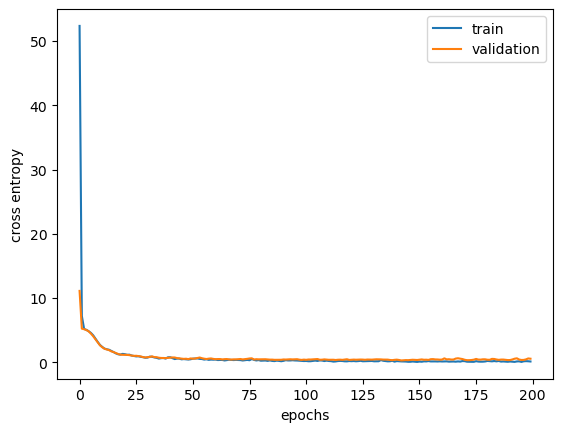

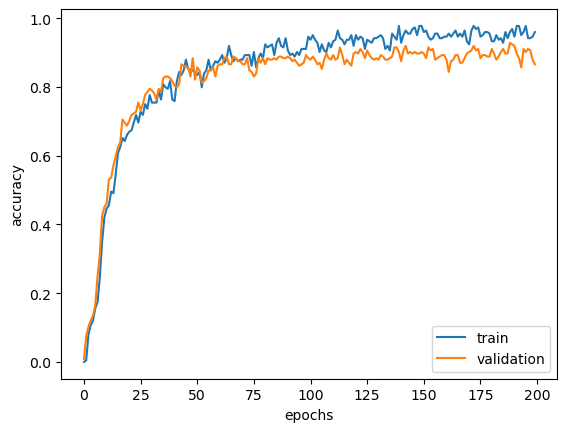

In [24]:
#Normal CNN
seq_model = CNN(seq_X_train, seq_y_train, 512, 5) #Has padding and dont implement maxpools
seq_test = CNN_train(seq_model, seq_X_train, seq_X_val, seq_y_train, seq_y_val, 32, 0.005, device) #Remember that the data is already one shot encoded

torch.Size([224, 5, 2793])
batches_per_epoch 7


Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 58.15batch/s, acc=0, loss=9.17]     


Epoch 0 validation: Cross-entropy=6.33, Accuracy=0.0%


Epoch 1: 100%|██████████| 7/7 [00:00<00:00, 59.05batch/s, acc=0, loss=5.55]


Epoch 1 validation: Cross-entropy=5.63, Accuracy=0.4%


Epoch 2: 100%|██████████| 7/7 [00:00<00:00, 59.12batch/s, acc=0, loss=5.48]


Epoch 2 validation: Cross-entropy=5.39, Accuracy=8.9%


Epoch 3: 100%|██████████| 7/7 [00:00<00:00, 59.37batch/s, acc=0, loss=5.98]    


Epoch 3 validation: Cross-entropy=5.36, Accuracy=1.3%


Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 59.50batch/s, acc=0, loss=5.77]    


Epoch 4 validation: Cross-entropy=5.26, Accuracy=4.0%


Epoch 5: 100%|██████████| 7/7 [00:00<00:00, 58.96batch/s, acc=0, loss=5.37]     


Epoch 5 validation: Cross-entropy=4.80, Accuracy=19.6%


Epoch 6: 100%|██████████| 7/7 [00:00<00:00, 59.99batch/s, acc=0.0312, loss=4.88]


Epoch 6 validation: Cross-entropy=3.64, Accuracy=33.0%


Epoch 7: 100%|██████████| 7/7 [00:00<00:00, 59.97batch/s, acc=0.188, loss=3.83] 


Epoch 7 validation: Cross-entropy=3.11, Accuracy=43.3%


Epoch 8: 100%|██████████| 7/7 [00:00<00:00, 59.84batch/s, acc=0.0938, loss=4.35]


Epoch 8 validation: Cross-entropy=2.86, Accuracy=43.8%


Epoch 9: 100%|██████████| 7/7 [00:00<00:00, 59.61batch/s, acc=0.219, loss=3.73]


Epoch 9 validation: Cross-entropy=2.01, Accuracy=57.1%


Epoch 10: 100%|██████████| 7/7 [00:00<00:00, 59.57batch/s, acc=0.375, loss=2.19] 


Epoch 10 validation: Cross-entropy=1.78, Accuracy=59.4%


Epoch 11: 100%|██████████| 7/7 [00:00<00:00, 59.60batch/s, acc=0.531, loss=2.1]  


Epoch 11 validation: Cross-entropy=2.01, Accuracy=52.2%


Epoch 12: 100%|██████████| 7/7 [00:00<00:00, 59.66batch/s, acc=0.656, loss=1.83]  


Epoch 12 validation: Cross-entropy=1.85, Accuracy=54.5%


Epoch 13: 100%|██████████| 7/7 [00:00<00:00, 59.67batch/s, acc=0.688, loss=1.26]  


Epoch 13 validation: Cross-entropy=2.42, Accuracy=46.9%


Epoch 14: 100%|██████████| 7/7 [00:00<00:00, 59.63batch/s, acc=0.781, loss=0.884] 


Epoch 14 validation: Cross-entropy=2.56, Accuracy=47.8%


Epoch 15: 100%|██████████| 7/7 [00:00<00:00, 59.56batch/s, acc=0.812, loss=0.783]


Epoch 15 validation: Cross-entropy=2.50, Accuracy=50.4%


Epoch 16: 100%|██████████| 7/7 [00:00<00:00, 59.00batch/s, acc=0.875, loss=0.456]


Epoch 16 validation: Cross-entropy=1.28, Accuracy=70.1%


Epoch 17: 100%|██████████| 7/7 [00:00<00:00, 59.38batch/s, acc=0.906, loss=0.417]


Epoch 17 validation: Cross-entropy=2.61, Accuracy=48.7%


Epoch 18: 100%|██████████| 7/7 [00:00<00:00, 59.41batch/s, acc=0.969, loss=0.359] 


Epoch 18 validation: Cross-entropy=2.33, Accuracy=51.8%


Epoch 19: 100%|██████████| 7/7 [00:00<00:00, 59.44batch/s, acc=0.938, loss=0.389] 


Epoch 19 validation: Cross-entropy=2.14, Accuracy=54.5%


Epoch 20: 100%|██████████| 7/7 [00:00<00:00, 59.28batch/s, acc=1, loss=0.13]    


Epoch 20 validation: Cross-entropy=1.54, Accuracy=62.9%


Epoch 21: 100%|██████████| 7/7 [00:00<00:00, 59.19batch/s, acc=0.938, loss=0.189]


Epoch 21 validation: Cross-entropy=2.83, Accuracy=47.8%


Epoch 22: 100%|██████████| 7/7 [00:00<00:00, 59.46batch/s, acc=0.906, loss=0.188]


Epoch 22 validation: Cross-entropy=1.57, Accuracy=62.9%


Epoch 23: 100%|██████████| 7/7 [00:00<00:00, 60.13batch/s, acc=0.875, loss=0.562]


Epoch 23 validation: Cross-entropy=1.15, Accuracy=72.8%


Epoch 24: 100%|██████████| 7/7 [00:00<00:00, 59.67batch/s, acc=0.906, loss=0.443]


Epoch 24 validation: Cross-entropy=3.02, Accuracy=48.2%


Epoch 25: 100%|██████████| 7/7 [00:00<00:00, 59.62batch/s, acc=0.875, loss=0.549]


Epoch 25 validation: Cross-entropy=3.38, Accuracy=46.4%


Epoch 26: 100%|██████████| 7/7 [00:00<00:00, 59.82batch/s, acc=0.938, loss=0.235]


Epoch 26 validation: Cross-entropy=1.99, Accuracy=58.5%


Epoch 27: 100%|██████████| 7/7 [00:00<00:00, 59.73batch/s, acc=0.938, loss=0.319]


Epoch 27 validation: Cross-entropy=1.71, Accuracy=62.5%


Epoch 28: 100%|██████████| 7/7 [00:00<00:00, 59.68batch/s, acc=0.938, loss=0.187]


Epoch 28 validation: Cross-entropy=1.86, Accuracy=54.5%


Epoch 29: 100%|██████████| 7/7 [00:00<00:00, 59.54batch/s, acc=0.938, loss=0.258]


Epoch 29 validation: Cross-entropy=2.75, Accuracy=48.7%


Epoch 30: 100%|██████████| 7/7 [00:00<00:00, 59.69batch/s, acc=0.938, loss=0.139]


Epoch 30 validation: Cross-entropy=1.56, Accuracy=60.7%


Epoch 31: 100%|██████████| 7/7 [00:00<00:00, 59.65batch/s, acc=0.938, loss=0.149]


Epoch 31 validation: Cross-entropy=1.63, Accuracy=60.7%


Epoch 32: 100%|██████████| 7/7 [00:00<00:00, 59.68batch/s, acc=1, loss=0.0268]   


Epoch 32 validation: Cross-entropy=3.32, Accuracy=45.5%


Epoch 33: 100%|██████████| 7/7 [00:00<00:00, 59.59batch/s, acc=0.969, loss=0.0526]


Epoch 33 validation: Cross-entropy=3.15, Accuracy=45.1%


Epoch 34: 100%|██████████| 7/7 [00:00<00:00, 59.70batch/s, acc=0.938, loss=0.279]


Epoch 34 validation: Cross-entropy=2.75, Accuracy=49.1%


Epoch 35: 100%|██████████| 7/7 [00:00<00:00, 59.60batch/s, acc=0.969, loss=0.0979]


Epoch 35 validation: Cross-entropy=1.70, Accuracy=62.9%


Epoch 36: 100%|██████████| 7/7 [00:00<00:00, 59.78batch/s, acc=1, loss=0.0277]   


Epoch 36 validation: Cross-entropy=1.70, Accuracy=60.7%


Epoch 37: 100%|██████████| 7/7 [00:00<00:00, 59.21batch/s, acc=0.969, loss=0.0533]


Epoch 37 validation: Cross-entropy=1.19, Accuracy=71.9%


Epoch 38: 100%|██████████| 7/7 [00:00<00:00, 59.41batch/s, acc=0.938, loss=0.188]


Epoch 38 validation: Cross-entropy=1.35, Accuracy=70.5%


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 59.76batch/s, acc=0.969, loss=0.273]


Epoch 39 validation: Cross-entropy=3.47, Accuracy=47.3%


Epoch 40: 100%|██████████| 7/7 [00:00<00:00, 59.48batch/s, acc=0.969, loss=0.0501]


Epoch 40 validation: Cross-entropy=3.94, Accuracy=42.0%


Epoch 41: 100%|██████████| 7/7 [00:00<00:00, 59.82batch/s, acc=0.906, loss=0.27]  


Epoch 41 validation: Cross-entropy=1.75, Accuracy=62.1%


Epoch 42: 100%|██████████| 7/7 [00:00<00:00, 59.62batch/s, acc=1, loss=0.0244]   


Epoch 42 validation: Cross-entropy=1.24, Accuracy=71.0%


Epoch 43: 100%|██████████| 7/7 [00:00<00:00, 59.58batch/s, acc=0.938, loss=0.0938]


Epoch 43 validation: Cross-entropy=1.61, Accuracy=66.5%


Epoch 44: 100%|██████████| 7/7 [00:00<00:00, 59.74batch/s, acc=1, loss=0.0136]    


Epoch 44 validation: Cross-entropy=1.41, Accuracy=68.8%


Epoch 45: 100%|██████████| 7/7 [00:00<00:00, 59.66batch/s, acc=1, loss=0.0126]   


Epoch 45 validation: Cross-entropy=2.60, Accuracy=48.2%


Epoch 46: 100%|██████████| 7/7 [00:00<00:00, 59.63batch/s, acc=1, loss=0.0187]    


Epoch 46 validation: Cross-entropy=3.70, Accuracy=39.7%


Epoch 47: 100%|██████████| 7/7 [00:00<00:00, 59.63batch/s, acc=1, loss=0.0339]   


Epoch 47 validation: Cross-entropy=3.83, Accuracy=39.7%


Epoch 48: 100%|██████████| 7/7 [00:00<00:00, 59.95batch/s, acc=0.969, loss=0.0441]


Epoch 48 validation: Cross-entropy=3.20, Accuracy=46.4%


Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 60.36batch/s, acc=1, loss=0.011]     


Epoch 49 validation: Cross-entropy=2.73, Accuracy=50.4%


Epoch 50: 100%|██████████| 7/7 [00:00<00:00, 59.85batch/s, acc=1, loss=0.0208]    


Epoch 50 validation: Cross-entropy=2.74, Accuracy=50.9%


Epoch 51: 100%|██████████| 7/7 [00:00<00:00, 59.16batch/s, acc=0.969, loss=0.113]


Epoch 51 validation: Cross-entropy=2.69, Accuracy=51.8%


Epoch 52: 100%|██████████| 7/7 [00:00<00:00, 58.75batch/s, acc=1, loss=0.00663]  


Epoch 52 validation: Cross-entropy=2.53, Accuracy=54.0%


Epoch 53: 100%|██████████| 7/7 [00:00<00:00, 59.28batch/s, acc=0.969, loss=0.0745]


Epoch 53 validation: Cross-entropy=3.17, Accuracy=51.8%


Epoch 54: 100%|██████████| 7/7 [00:00<00:00, 59.04batch/s, acc=1, loss=0.00332]  


Epoch 54 validation: Cross-entropy=3.05, Accuracy=50.0%


Epoch 55: 100%|██████████| 7/7 [00:00<00:00, 59.25batch/s, acc=1, loss=0.00973]  


Epoch 55 validation: Cross-entropy=2.13, Accuracy=59.4%


Epoch 56: 100%|██████████| 7/7 [00:00<00:00, 59.45batch/s, acc=0.969, loss=0.0596]


Epoch 56 validation: Cross-entropy=2.18, Accuracy=57.1%


Epoch 57: 100%|██████████| 7/7 [00:00<00:00, 59.67batch/s, acc=1, loss=0.00731]  


Epoch 57 validation: Cross-entropy=2.07, Accuracy=58.9%


Epoch 58: 100%|██████████| 7/7 [00:00<00:00, 59.74batch/s, acc=1, loss=0.0365]   


Epoch 58 validation: Cross-entropy=2.50, Accuracy=53.6%


Epoch 59: 100%|██████████| 7/7 [00:00<00:00, 59.70batch/s, acc=0.969, loss=0.0643]


Epoch 59 validation: Cross-entropy=3.21, Accuracy=48.2%


Epoch 60: 100%|██████████| 7/7 [00:00<00:00, 59.61batch/s, acc=0.969, loss=0.12] 


Epoch 60 validation: Cross-entropy=1.46, Accuracy=69.2%


Epoch 61: 100%|██████████| 7/7 [00:00<00:00, 59.70batch/s, acc=0.969, loss=0.0339]


Epoch 61 validation: Cross-entropy=1.67, Accuracy=67.9%


Epoch 62: 100%|██████████| 7/7 [00:00<00:00, 59.53batch/s, acc=1, loss=0.0435]    


Epoch 62 validation: Cross-entropy=2.73, Accuracy=49.1%


Epoch 63: 100%|██████████| 7/7 [00:00<00:00, 59.62batch/s, acc=0.969, loss=0.0403]


Epoch 63 validation: Cross-entropy=3.74, Accuracy=46.0%


Epoch 64: 100%|██████████| 7/7 [00:00<00:00, 59.64batch/s, acc=0.938, loss=0.133]


Epoch 64 validation: Cross-entropy=2.47, Accuracy=54.0%


Epoch 65: 100%|██████████| 7/7 [00:00<00:00, 59.78batch/s, acc=1, loss=0.0376]   


Epoch 65 validation: Cross-entropy=2.75, Accuracy=51.3%


Epoch 66: 100%|██████████| 7/7 [00:00<00:00, 59.70batch/s, acc=1, loss=0.0138]   


Epoch 66 validation: Cross-entropy=3.07, Accuracy=48.7%


Epoch 67: 100%|██████████| 7/7 [00:00<00:00, 59.39batch/s, acc=0.938, loss=0.0685]


Epoch 67 validation: Cross-entropy=2.94, Accuracy=46.0%


Epoch 68: 100%|██████████| 7/7 [00:00<00:00, 59.79batch/s, acc=0.969, loss=0.0547]


Epoch 68 validation: Cross-entropy=2.49, Accuracy=51.3%


Epoch 69: 100%|██████████| 7/7 [00:00<00:00, 59.78batch/s, acc=0.938, loss=0.177]


Epoch 69 validation: Cross-entropy=3.33, Accuracy=46.0%


Epoch 70: 100%|██████████| 7/7 [00:00<00:00, 59.60batch/s, acc=1, loss=0.0164]   


Epoch 70 validation: Cross-entropy=1.28, Accuracy=71.0%


Epoch 71: 100%|██████████| 7/7 [00:00<00:00, 59.60batch/s, acc=0.719, loss=1.23] 


Epoch 71 validation: Cross-entropy=1.83, Accuracy=54.9%


Epoch 72: 100%|██████████| 7/7 [00:00<00:00, 59.59batch/s, acc=0.906, loss=0.508]


Epoch 72 validation: Cross-entropy=5.49, Accuracy=33.5%


Epoch 73: 100%|██████████| 7/7 [00:00<00:00, 59.68batch/s, acc=0.938, loss=0.504] 


Epoch 73 validation: Cross-entropy=2.79, Accuracy=51.3%


Epoch 74: 100%|██████████| 7/7 [00:00<00:00, 59.56batch/s, acc=0.812, loss=0.409]


Epoch 74 validation: Cross-entropy=4.57, Accuracy=42.4%


Epoch 75: 100%|██████████| 7/7 [00:00<00:00, 59.57batch/s, acc=0.938, loss=0.321]


Epoch 75 validation: Cross-entropy=3.54, Accuracy=48.7%


Epoch 76: 100%|██████████| 7/7 [00:00<00:00, 59.62batch/s, acc=0.969, loss=0.209]


Epoch 76 validation: Cross-entropy=2.10, Accuracy=59.8%


Epoch 77: 100%|██████████| 7/7 [00:00<00:00, 59.65batch/s, acc=0.906, loss=0.165]


Epoch 77 validation: Cross-entropy=2.57, Accuracy=56.7%


Epoch 78: 100%|██████████| 7/7 [00:00<00:00, 59.69batch/s, acc=0.938, loss=0.226] 


Epoch 78 validation: Cross-entropy=2.78, Accuracy=55.8%


Epoch 79: 100%|██████████| 7/7 [00:00<00:00, 59.69batch/s, acc=0.969, loss=0.0665]


Epoch 79 validation: Cross-entropy=2.99, Accuracy=54.0%


Epoch 80: 100%|██████████| 7/7 [00:00<00:00, 59.93batch/s, acc=0.938, loss=0.17] 


Epoch 80 validation: Cross-entropy=2.81, Accuracy=54.5%


Epoch 81: 100%|██████████| 7/7 [00:00<00:00, 59.79batch/s, acc=0.969, loss=0.0958]


Epoch 81 validation: Cross-entropy=5.21, Accuracy=41.1%


Epoch 82: 100%|██████████| 7/7 [00:00<00:00, 59.45batch/s, acc=1, loss=0.0199]    


Epoch 82 validation: Cross-entropy=3.96, Accuracy=46.4%


Epoch 83: 100%|██████████| 7/7 [00:00<00:00, 59.50batch/s, acc=0.938, loss=0.163] 


Epoch 83 validation: Cross-entropy=3.36, Accuracy=46.4%


Epoch 84: 100%|██████████| 7/7 [00:00<00:00, 59.48batch/s, acc=0.969, loss=0.0607]


Epoch 84 validation: Cross-entropy=3.75, Accuracy=45.5%


Epoch 85: 100%|██████████| 7/7 [00:00<00:00, 59.52batch/s, acc=1, loss=0.0518]   


Epoch 85 validation: Cross-entropy=4.40, Accuracy=43.8%


Epoch 86: 100%|██████████| 7/7 [00:00<00:00, 59.58batch/s, acc=1, loss=0.00268]   


Epoch 86 validation: Cross-entropy=4.00, Accuracy=47.8%


Epoch 87: 100%|██████████| 7/7 [00:00<00:00, 59.61batch/s, acc=1, loss=0.00403]   


Epoch 87 validation: Cross-entropy=4.06, Accuracy=47.3%


Epoch 88: 100%|██████████| 7/7 [00:00<00:00, 59.69batch/s, acc=1, loss=0.0297]   


Epoch 88 validation: Cross-entropy=3.87, Accuracy=49.1%


Epoch 89: 100%|██████████| 7/7 [00:00<00:00, 59.73batch/s, acc=0.969, loss=0.121]


Epoch 89 validation: Cross-entropy=3.13, Accuracy=51.8%


Epoch 90: 100%|██████████| 7/7 [00:00<00:00, 59.51batch/s, acc=1, loss=0.0618]   


Epoch 90 validation: Cross-entropy=2.91, Accuracy=54.9%


Epoch 91: 100%|██████████| 7/7 [00:00<00:00, 59.70batch/s, acc=1, loss=0.0248]   


Epoch 91 validation: Cross-entropy=3.55, Accuracy=50.9%


Epoch 92: 100%|██████████| 7/7 [00:00<00:00, 59.87batch/s, acc=0.938, loss=0.079] 


Epoch 92 validation: Cross-entropy=3.46, Accuracy=51.8%


Epoch 93: 100%|██████████| 7/7 [00:00<00:00, 59.61batch/s, acc=1, loss=0.00134]   


Epoch 93 validation: Cross-entropy=2.49, Accuracy=58.9%


Epoch 94: 100%|██████████| 7/7 [00:00<00:00, 59.67batch/s, acc=1, loss=0.0012]   


Epoch 94 validation: Cross-entropy=2.42, Accuracy=58.5%


Epoch 95: 100%|██████████| 7/7 [00:00<00:00, 59.71batch/s, acc=1, loss=0.000554] 


Epoch 95 validation: Cross-entropy=2.10, Accuracy=63.8%


Epoch 96: 100%|██████████| 7/7 [00:00<00:00, 59.64batch/s, acc=1, loss=0.00603]  


Epoch 96 validation: Cross-entropy=1.86, Accuracy=66.1%


Epoch 97: 100%|██████████| 7/7 [00:00<00:00, 59.61batch/s, acc=1, loss=0.00141]  


Epoch 97 validation: Cross-entropy=2.12, Accuracy=62.9%


Epoch 98: 100%|██████████| 7/7 [00:00<00:00, 59.55batch/s, acc=1, loss=0.000598]  


Epoch 98 validation: Cross-entropy=2.45, Accuracy=60.7%


Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 59.60batch/s, acc=1, loss=0.00331]  


Epoch 99 validation: Cross-entropy=2.71, Accuracy=58.5%


Epoch 100: 100%|██████████| 7/7 [00:00<00:00, 59.47batch/s, acc=1, loss=0.00433]   


Epoch 100 validation: Cross-entropy=2.71, Accuracy=58.5%


Epoch 101: 100%|██████████| 7/7 [00:00<00:00, 59.60batch/s, acc=0.969, loss=0.128]


Epoch 101 validation: Cross-entropy=2.28, Accuracy=60.7%


Epoch 102: 100%|██████████| 7/7 [00:00<00:00, 59.61batch/s, acc=0.969, loss=0.188] 


Epoch 102 validation: Cross-entropy=1.94, Accuracy=64.7%


Epoch 103: 100%|██████████| 7/7 [00:00<00:00, 59.64batch/s, acc=1, loss=0.00764]  


Epoch 103 validation: Cross-entropy=1.92, Accuracy=63.8%


Epoch 104: 100%|██████████| 7/7 [00:00<00:00, 59.52batch/s, acc=1, loss=0.0272]    


Epoch 104 validation: Cross-entropy=2.34, Accuracy=58.0%


Epoch 105: 100%|██████████| 7/7 [00:00<00:00, 59.55batch/s, acc=1, loss=0.00226]  


Epoch 105 validation: Cross-entropy=2.26, Accuracy=59.4%


Epoch 106: 100%|██████████| 7/7 [00:00<00:00, 59.47batch/s, acc=0.969, loss=0.13] 


Epoch 106 validation: Cross-entropy=2.77, Accuracy=56.2%


Epoch 107: 100%|██████████| 7/7 [00:00<00:00, 59.49batch/s, acc=1, loss=0.00306]   


Epoch 107 validation: Cross-entropy=3.12, Accuracy=53.1%


Epoch 108: 100%|██████████| 7/7 [00:00<00:00, 58.13batch/s, acc=1, loss=0.0263]   


Epoch 108 validation: Cross-entropy=2.73, Accuracy=56.7%


Epoch 109: 100%|██████████| 7/7 [00:00<00:00, 59.07batch/s, acc=0.969, loss=0.0514]


Epoch 109 validation: Cross-entropy=3.11, Accuracy=52.2%


Epoch 110: 100%|██████████| 7/7 [00:00<00:00, 59.13batch/s, acc=1, loss=0.0112]   


Epoch 110 validation: Cross-entropy=3.56, Accuracy=50.0%


Epoch 111: 100%|██████████| 7/7 [00:00<00:00, 59.47batch/s, acc=1, loss=0.00226]  


Epoch 111 validation: Cross-entropy=3.63, Accuracy=49.6%


Epoch 112: 100%|██████████| 7/7 [00:00<00:00, 59.42batch/s, acc=1, loss=0.0183]   


Epoch 112 validation: Cross-entropy=3.33, Accuracy=50.9%


Epoch 113: 100%|██████████| 7/7 [00:00<00:00, 59.28batch/s, acc=1, loss=0.00106]   


Epoch 113 validation: Cross-entropy=3.47, Accuracy=50.0%


Epoch 114: 100%|██████████| 7/7 [00:00<00:00, 59.60batch/s, acc=1, loss=0.000515]  


Epoch 114 validation: Cross-entropy=3.88, Accuracy=48.7%


Epoch 115: 100%|██████████| 7/7 [00:00<00:00, 59.44batch/s, acc=1, loss=0.0057]    


Epoch 115 validation: Cross-entropy=3.65, Accuracy=51.3%


Epoch 116: 100%|██████████| 7/7 [00:00<00:00, 59.47batch/s, acc=0.969, loss=0.0562]


Epoch 116 validation: Cross-entropy=3.19, Accuracy=54.9%


Epoch 117: 100%|██████████| 7/7 [00:00<00:00, 59.52batch/s, acc=0.969, loss=0.032] 


Epoch 117 validation: Cross-entropy=3.11, Accuracy=55.8%


Epoch 118: 100%|██████████| 7/7 [00:00<00:00, 59.27batch/s, acc=1, loss=0.00727]  


Epoch 118 validation: Cross-entropy=3.08, Accuracy=55.4%


Epoch 119: 100%|██████████| 7/7 [00:00<00:00, 59.34batch/s, acc=1, loss=0.000284] 


Epoch 119 validation: Cross-entropy=3.78, Accuracy=48.7%


Epoch 120: 100%|██████████| 7/7 [00:00<00:00, 59.46batch/s, acc=1, loss=0.00324]  


Epoch 120 validation: Cross-entropy=4.11, Accuracy=46.9%


Epoch 121: 100%|██████████| 7/7 [00:00<00:00, 59.07batch/s, acc=1, loss=0.00681]  


Epoch 121 validation: Cross-entropy=3.44, Accuracy=50.0%


Epoch 122: 100%|██████████| 7/7 [00:00<00:00, 59.12batch/s, acc=0.969, loss=0.0963]


Epoch 122 validation: Cross-entropy=3.01, Accuracy=54.0%


Epoch 123: 100%|██████████| 7/7 [00:00<00:00, 59.86batch/s, acc=1, loss=0.0024]   


Epoch 123 validation: Cross-entropy=3.56, Accuracy=51.8%


Epoch 124: 100%|██████████| 7/7 [00:00<00:00, 59.08batch/s, acc=1, loss=0.0179]   


Epoch 124 validation: Cross-entropy=3.57, Accuracy=51.3%


Epoch 125: 100%|██████████| 7/7 [00:00<00:00, 59.13batch/s, acc=1, loss=0.00442]  


Epoch 125 validation: Cross-entropy=4.22, Accuracy=44.2%


Epoch 126: 100%|██████████| 7/7 [00:00<00:00, 59.31batch/s, acc=1, loss=0.00449]   


Epoch 126 validation: Cross-entropy=3.74, Accuracy=50.0%


Epoch 127: 100%|██████████| 7/7 [00:00<00:00, 59.18batch/s, acc=0.969, loss=0.0612]


Epoch 127 validation: Cross-entropy=2.99, Accuracy=55.8%


Epoch 128: 100%|██████████| 7/7 [00:00<00:00, 59.41batch/s, acc=0.969, loss=0.0432]


Epoch 128 validation: Cross-entropy=3.45, Accuracy=52.2%


Epoch 129: 100%|██████████| 7/7 [00:00<00:00, 59.47batch/s, acc=1, loss=0.0024]   


Epoch 129 validation: Cross-entropy=4.16, Accuracy=47.3%


Epoch 130: 100%|██████████| 7/7 [00:00<00:00, 59.23batch/s, acc=1, loss=0.00101]  


Epoch 130 validation: Cross-entropy=3.78, Accuracy=48.7%


Epoch 131: 100%|██████████| 7/7 [00:00<00:00, 60.15batch/s, acc=1, loss=0.018]     


Epoch 131 validation: Cross-entropy=4.43, Accuracy=45.1%


Epoch 132: 100%|██████████| 7/7 [00:00<00:00, 59.56batch/s, acc=1, loss=0.0165]   


Epoch 132 validation: Cross-entropy=3.59, Accuracy=48.7%


Epoch 133: 100%|██████████| 7/7 [00:00<00:00, 59.45batch/s, acc=1, loss=0.00136]  


Epoch 133 validation: Cross-entropy=3.49, Accuracy=50.4%


Epoch 134: 100%|██████████| 7/7 [00:00<00:00, 59.32batch/s, acc=0.969, loss=0.0417]


Epoch 134 validation: Cross-entropy=2.86, Accuracy=54.9%


Epoch 135: 100%|██████████| 7/7 [00:00<00:00, 59.44batch/s, acc=0.969, loss=0.235] 


Epoch 135 validation: Cross-entropy=2.44, Accuracy=60.7%


Epoch 136: 100%|██████████| 7/7 [00:00<00:00, 59.23batch/s, acc=0.969, loss=0.041]


Epoch 136 validation: Cross-entropy=3.17, Accuracy=54.9%


Epoch 137: 100%|██████████| 7/7 [00:00<00:00, 59.43batch/s, acc=1, loss=0.0227]    


Epoch 137 validation: Cross-entropy=3.42, Accuracy=55.4%


Epoch 138: 100%|██████████| 7/7 [00:00<00:00, 59.29batch/s, acc=0.938, loss=0.1]  


Epoch 138 validation: Cross-entropy=3.49, Accuracy=55.8%


Epoch 139: 100%|██████████| 7/7 [00:00<00:00, 59.44batch/s, acc=0.969, loss=0.266] 


Epoch 139 validation: Cross-entropy=2.82, Accuracy=59.4%


Epoch 140: 100%|██████████| 7/7 [00:00<00:00, 59.40batch/s, acc=0.969, loss=0.0535]


Epoch 140 validation: Cross-entropy=2.00, Accuracy=66.1%


Epoch 141: 100%|██████████| 7/7 [00:00<00:00, 59.50batch/s, acc=0.969, loss=0.106] 


Epoch 141 validation: Cross-entropy=3.21, Accuracy=52.7%


Epoch 142: 100%|██████████| 7/7 [00:00<00:00, 59.41batch/s, acc=1, loss=0.0107]  


Epoch 142 validation: Cross-entropy=3.57, Accuracy=50.4%


Epoch 143: 100%|██████████| 7/7 [00:00<00:00, 59.46batch/s, acc=0.969, loss=0.106]


Epoch 143 validation: Cross-entropy=2.87, Accuracy=57.1%


Epoch 144: 100%|██████████| 7/7 [00:00<00:00, 59.34batch/s, acc=1, loss=0.00356]  


Epoch 144 validation: Cross-entropy=2.37, Accuracy=58.9%


Epoch 145: 100%|██████████| 7/7 [00:00<00:00, 59.34batch/s, acc=1, loss=0.0234]    


Epoch 145 validation: Cross-entropy=2.59, Accuracy=57.1%


Epoch 146: 100%|██████████| 7/7 [00:00<00:00, 59.43batch/s, acc=1, loss=0.00916]  


Epoch 146 validation: Cross-entropy=2.98, Accuracy=54.5%


Epoch 147: 100%|██████████| 7/7 [00:00<00:00, 59.46batch/s, acc=1, loss=0.000438] 


Epoch 147 validation: Cross-entropy=3.02, Accuracy=54.9%


Epoch 148: 100%|██████████| 7/7 [00:00<00:00, 59.39batch/s, acc=1, loss=0.000387] 


Epoch 148 validation: Cross-entropy=3.10, Accuracy=54.5%


Epoch 149: 100%|██████████| 7/7 [00:00<00:00, 59.35batch/s, acc=1, loss=0.000466] 


Epoch 149 validation: Cross-entropy=3.12, Accuracy=54.5%


Epoch 150: 100%|██████████| 7/7 [00:00<00:00, 59.42batch/s, acc=1, loss=0.00604]  


Epoch 150 validation: Cross-entropy=2.97, Accuracy=55.4%


Epoch 151: 100%|██████████| 7/7 [00:00<00:00, 59.45batch/s, acc=1, loss=0.0239]   


Epoch 151 validation: Cross-entropy=3.19, Accuracy=53.1%


Epoch 152: 100%|██████████| 7/7 [00:00<00:00, 59.51batch/s, acc=1, loss=0.0199]   


Epoch 152 validation: Cross-entropy=4.09, Accuracy=47.3%


Epoch 153: 100%|██████████| 7/7 [00:00<00:00, 59.39batch/s, acc=0.969, loss=0.154] 


Epoch 153 validation: Cross-entropy=2.58, Accuracy=57.1%


Epoch 154: 100%|██████████| 7/7 [00:00<00:00, 59.53batch/s, acc=0.969, loss=0.0397]


Epoch 154 validation: Cross-entropy=1.91, Accuracy=65.6%


Epoch 155: 100%|██████████| 7/7 [00:00<00:00, 59.39batch/s, acc=0.969, loss=0.341] 


Epoch 155 validation: Cross-entropy=2.08, Accuracy=62.5%


Epoch 156: 100%|██████████| 7/7 [00:00<00:00, 59.22batch/s, acc=0.969, loss=0.126]


Epoch 156 validation: Cross-entropy=1.57, Accuracy=70.5%


Epoch 157: 100%|██████████| 7/7 [00:00<00:00, 59.40batch/s, acc=0.969, loss=0.0302]


Epoch 157 validation: Cross-entropy=2.20, Accuracy=62.1%


Epoch 158: 100%|██████████| 7/7 [00:00<00:00, 59.41batch/s, acc=0.969, loss=0.0577]


Epoch 158 validation: Cross-entropy=3.22, Accuracy=54.0%


Epoch 159: 100%|██████████| 7/7 [00:00<00:00, 59.41batch/s, acc=0.969, loss=0.0403]


Epoch 159 validation: Cross-entropy=3.46, Accuracy=51.8%


Epoch 160: 100%|██████████| 7/7 [00:00<00:00, 59.39batch/s, acc=1, loss=0.0131]   


Epoch 160 validation: Cross-entropy=3.54, Accuracy=50.4%


Epoch 161: 100%|██████████| 7/7 [00:00<00:00, 59.35batch/s, acc=1, loss=0.00439]  


Epoch 161 validation: Cross-entropy=3.36, Accuracy=53.1%


Epoch 162: 100%|██████████| 7/7 [00:00<00:00, 59.41batch/s, acc=1, loss=0.00177]   


Epoch 162 validation: Cross-entropy=2.97, Accuracy=56.7%


Epoch 163: 100%|██████████| 7/7 [00:00<00:00, 59.53batch/s, acc=0.969, loss=0.0773]


Epoch 163 validation: Cross-entropy=2.60, Accuracy=58.5%


Epoch 164: 100%|██████████| 7/7 [00:00<00:00, 59.32batch/s, acc=1, loss=0.00173]   


Epoch 164 validation: Cross-entropy=3.83, Accuracy=46.0%


Epoch 165: 100%|██████████| 7/7 [00:00<00:00, 58.98batch/s, acc=1, loss=0.03]     


Epoch 165 validation: Cross-entropy=3.91, Accuracy=43.8%


Epoch 166: 100%|██████████| 7/7 [00:00<00:00, 59.31batch/s, acc=0.969, loss=0.0735]


Epoch 166 validation: Cross-entropy=2.26, Accuracy=60.3%


Epoch 167: 100%|██████████| 7/7 [00:00<00:00, 59.16batch/s, acc=0.938, loss=0.442]


Epoch 167 validation: Cross-entropy=2.19, Accuracy=62.1%


Epoch 168: 100%|██████████| 7/7 [00:00<00:00, 59.25batch/s, acc=1, loss=0.00374]   


Epoch 168 validation: Cross-entropy=2.44, Accuracy=60.3%


Epoch 169: 100%|██████████| 7/7 [00:00<00:00, 59.13batch/s, acc=0.969, loss=0.122]


Epoch 169 validation: Cross-entropy=3.18, Accuracy=58.0%


Epoch 170: 100%|██████████| 7/7 [00:00<00:00, 59.39batch/s, acc=0.938, loss=0.172]


Epoch 170 validation: Cross-entropy=2.43, Accuracy=61.2%


Epoch 171: 100%|██████████| 7/7 [00:00<00:00, 59.32batch/s, acc=0.906, loss=0.75] 


Epoch 171 validation: Cross-entropy=1.52, Accuracy=72.3%


Epoch 172: 100%|██████████| 7/7 [00:00<00:00, 59.49batch/s, acc=0.938, loss=0.115] 


Epoch 172 validation: Cross-entropy=1.74, Accuracy=72.3%


Epoch 173: 100%|██████████| 7/7 [00:00<00:00, 59.36batch/s, acc=1, loss=0.00818]  


Epoch 173 validation: Cross-entropy=1.93, Accuracy=67.9%


Epoch 174: 100%|██████████| 7/7 [00:00<00:00, 59.46batch/s, acc=0.969, loss=0.0911]


Epoch 174 validation: Cross-entropy=2.10, Accuracy=66.5%


Epoch 175: 100%|██████████| 7/7 [00:00<00:00, 59.20batch/s, acc=1, loss=0.00085]  


Epoch 175 validation: Cross-entropy=2.41, Accuracy=64.7%


Epoch 176: 100%|██████████| 7/7 [00:00<00:00, 59.20batch/s, acc=0.969, loss=0.0813]


Epoch 176 validation: Cross-entropy=2.30, Accuracy=65.2%


Epoch 177: 100%|██████████| 7/7 [00:00<00:00, 59.05batch/s, acc=1, loss=0.00445]  


Epoch 177 validation: Cross-entropy=2.17, Accuracy=66.1%


Epoch 178: 100%|██████████| 7/7 [00:00<00:00, 59.03batch/s, acc=0.969, loss=0.179] 


Epoch 178 validation: Cross-entropy=2.18, Accuracy=65.2%


Epoch 179: 100%|██████████| 7/7 [00:00<00:00, 59.01batch/s, acc=0.938, loss=0.101]


Epoch 179 validation: Cross-entropy=1.98, Accuracy=67.9%


Epoch 180: 100%|██████████| 7/7 [00:00<00:00, 59.19batch/s, acc=0.969, loss=0.0773]


Epoch 180 validation: Cross-entropy=2.20, Accuracy=65.6%


Epoch 181: 100%|██████████| 7/7 [00:00<00:00, 59.05batch/s, acc=1, loss=0.00545]   


Epoch 181 validation: Cross-entropy=1.93, Accuracy=67.9%


Epoch 182: 100%|██████████| 7/7 [00:00<00:00, 59.22batch/s, acc=1, loss=0.0112]    


Epoch 182 validation: Cross-entropy=1.79, Accuracy=69.6%


Epoch 183: 100%|██████████| 7/7 [00:00<00:00, 58.92batch/s, acc=0.969, loss=0.372] 


Epoch 183 validation: Cross-entropy=1.89, Accuracy=67.4%


Epoch 184: 100%|██████████| 7/7 [00:00<00:00, 59.79batch/s, acc=1, loss=0.0133]    


Epoch 184 validation: Cross-entropy=2.03, Accuracy=68.3%


Epoch 185: 100%|██████████| 7/7 [00:00<00:00, 59.16batch/s, acc=1, loss=0.00877]  


Epoch 185 validation: Cross-entropy=2.08, Accuracy=68.3%


Epoch 186: 100%|██████████| 7/7 [00:00<00:00, 59.34batch/s, acc=0.969, loss=0.0568]


Epoch 186 validation: Cross-entropy=2.31, Accuracy=64.3%


Epoch 187: 100%|██████████| 7/7 [00:00<00:00, 59.16batch/s, acc=1, loss=0.00619]   


Epoch 187 validation: Cross-entropy=2.09, Accuracy=68.8%


Epoch 188: 100%|██████████| 7/7 [00:00<00:00, 58.45batch/s, acc=1, loss=0.00142]  


Epoch 188 validation: Cross-entropy=1.89, Accuracy=70.1%


Epoch 189: 100%|██████████| 7/7 [00:00<00:00, 59.72batch/s, acc=1, loss=0.0111]    


Epoch 189 validation: Cross-entropy=1.83, Accuracy=71.0%


Epoch 190: 100%|██████████| 7/7 [00:00<00:00, 59.53batch/s, acc=1, loss=0.000559]  


Epoch 190 validation: Cross-entropy=2.01, Accuracy=68.8%


Epoch 191: 100%|██████████| 7/7 [00:00<00:00, 59.31batch/s, acc=1, loss=0.00706]  


Epoch 191 validation: Cross-entropy=2.19, Accuracy=66.5%


Epoch 192: 100%|██████████| 7/7 [00:00<00:00, 59.24batch/s, acc=0.969, loss=0.0415]


Epoch 192 validation: Cross-entropy=2.38, Accuracy=64.3%


Epoch 193: 100%|██████████| 7/7 [00:00<00:00, 58.55batch/s, acc=1, loss=0.0011]    


Epoch 193 validation: Cross-entropy=2.11, Accuracy=68.8%


Epoch 194: 100%|██████████| 7/7 [00:00<00:00, 59.65batch/s, acc=0.969, loss=0.0485]


Epoch 194 validation: Cross-entropy=1.91, Accuracy=71.9%


Epoch 195: 100%|██████████| 7/7 [00:00<00:00, 59.38batch/s, acc=1, loss=0.011]     


Epoch 195 validation: Cross-entropy=2.07, Accuracy=70.5%


Epoch 196: 100%|██████████| 7/7 [00:00<00:00, 59.15batch/s, acc=1, loss=0.00041]   


Epoch 196 validation: Cross-entropy=2.26, Accuracy=67.9%


Epoch 197: 100%|██████████| 7/7 [00:00<00:00, 59.16batch/s, acc=1, loss=0.0036]    


Epoch 197 validation: Cross-entropy=2.29, Accuracy=66.5%


Epoch 198: 100%|██████████| 7/7 [00:00<00:00, 59.27batch/s, acc=1, loss=0.0218]    


Epoch 198 validation: Cross-entropy=2.27, Accuracy=66.1%


Epoch 199: 100%|██████████| 7/7 [00:00<00:00, 59.16batch/s, acc=1, loss=0.0017]    


Epoch 199 validation: Cross-entropy=2.18, Accuracy=64.7%


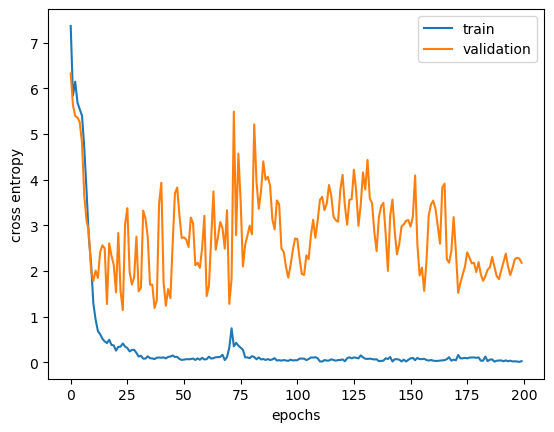

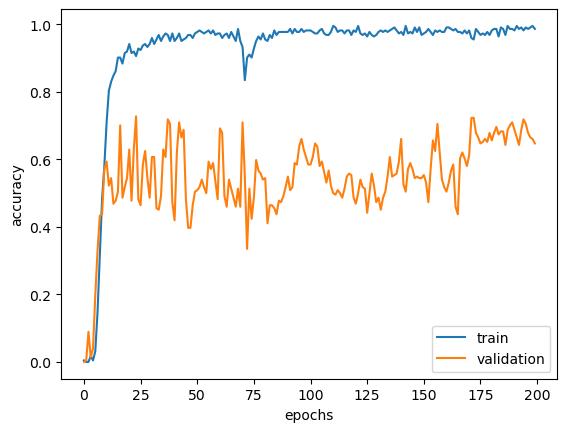

In [35]:
#Improved CNN # 5 = 90% max, 21 = 80% max, 51 = 70% max, the biggest the kernel worst the prediction and less stable
seq_model = CNNZ(seq_X_train, seq_y_train, 75) #Note : Apparently, the padding increase the accuracys
seq_test = CNN_train(seq_model, seq_X_train, seq_X_val, seq_y_train, seq_y_val, 32, 0.005, device) #Remember that the data is already one shot encoded

torch.Size([224, 5, 2793])
batches_per_epoch 7


Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  5.68batch/s, acc=0, loss=9.34]     


Epoch 0 validation: Cross-entropy=6.53, Accuracy=2.3%


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  5.77batch/s, acc=0, loss=5.7]      


Epoch 1 validation: Cross-entropy=5.04, Accuracy=31.2%


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  5.79batch/s, acc=0, loss=5.06]     


Epoch 2 validation: Cross-entropy=4.30, Accuracy=31.3%


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  5.78batch/s, acc=0, loss=6.05]    


Epoch 3 validation: Cross-entropy=3.92, Accuracy=54.0%


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  5.71batch/s, acc=0, loss=5.76]     


Epoch 4 validation: Cross-entropy=2.83, Accuracy=75.7%


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  5.81batch/s, acc=0.0312, loss=5.06]


Epoch 5 validation: Cross-entropy=1.28, Accuracy=87.6%


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=0.156, loss=4.15] 


Epoch 6 validation: Cross-entropy=0.52, Accuracy=91.4%


Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  5.80batch/s, acc=0.281, loss=3.15] 


Epoch 7 validation: Cross-entropy=0.38, Accuracy=95.0%


Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=0.406, loss=2.77] 


Epoch 8 validation: Cross-entropy=0.25, Accuracy=95.8%


Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=0.656, loss=2.16] 


Epoch 9 validation: Cross-entropy=0.16, Accuracy=97.0%


Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  5.70batch/s, acc=0.531, loss=2.02] 


Epoch 10 validation: Cross-entropy=0.18, Accuracy=95.4%


Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=0.531, loss=2.09] 


Epoch 11 validation: Cross-entropy=0.18, Accuracy=96.7%


Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  5.84batch/s, acc=0.5, loss=2.12]   


Epoch 12 validation: Cross-entropy=0.14, Accuracy=96.8%


Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  5.84batch/s, acc=0.5, loss=1.76]   


Epoch 13 validation: Cross-entropy=0.14, Accuracy=97.1%


Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  4.69batch/s, acc=0.594, loss=1.61] 


Epoch 14 validation: Cross-entropy=0.09, Accuracy=97.5%


Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  5.48batch/s, acc=0.625, loss=1.54] 


Epoch 15 validation: Cross-entropy=0.13, Accuracy=97.5%


Epoch 16: 100%|██████████| 7/7 [00:01<00:00,  5.32batch/s, acc=0.719, loss=1.04]


Epoch 16 validation: Cross-entropy=0.10, Accuracy=98.0%


Epoch 17: 100%|██████████| 7/7 [00:01<00:00,  4.51batch/s, acc=0.812, loss=1.03] 


Epoch 17 validation: Cross-entropy=0.11, Accuracy=97.0%


Epoch 18: 100%|██████████| 7/7 [00:01<00:00,  5.13batch/s, acc=0.688, loss=1.14] 


Epoch 18 validation: Cross-entropy=0.08, Accuracy=98.7%


Epoch 19: 100%|██████████| 7/7 [00:01<00:00,  5.33batch/s, acc=0.625, loss=1.36] 


Epoch 19 validation: Cross-entropy=0.11, Accuracy=97.3%


Epoch 20: 100%|██████████| 7/7 [00:01<00:00,  5.57batch/s, acc=0.75, loss=0.956] 


Epoch 20 validation: Cross-entropy=0.09, Accuracy=97.8%


Epoch 21: 100%|██████████| 7/7 [00:01<00:00,  5.61batch/s, acc=0.688, loss=1.18] 


Epoch 21 validation: Cross-entropy=0.07, Accuracy=97.9%


Epoch 22: 100%|██████████| 7/7 [00:01<00:00,  5.85batch/s, acc=0.781, loss=0.934] 


Epoch 22 validation: Cross-entropy=0.09, Accuracy=98.0%


Epoch 23: 100%|██████████| 7/7 [00:01<00:00,  5.83batch/s, acc=0.781, loss=0.821]


Epoch 23 validation: Cross-entropy=0.08, Accuracy=97.6%


Epoch 24: 100%|██████████| 7/7 [00:01<00:00,  5.84batch/s, acc=0.844, loss=0.756]


Epoch 24 validation: Cross-entropy=0.06, Accuracy=99.1%


Epoch 25: 100%|██████████| 7/7 [00:01<00:00,  5.81batch/s, acc=0.875, loss=0.622]


Epoch 25 validation: Cross-entropy=0.08, Accuracy=98.0%


Epoch 26: 100%|██████████| 7/7 [00:01<00:00,  5.83batch/s, acc=0.844, loss=0.638]


Epoch 26 validation: Cross-entropy=0.08, Accuracy=98.0%


Epoch 27: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=0.875, loss=0.62] 


Epoch 27 validation: Cross-entropy=0.06, Accuracy=97.6%


Epoch 28: 100%|██████████| 7/7 [00:01<00:00,  5.79batch/s, acc=0.906, loss=0.615]


Epoch 28 validation: Cross-entropy=0.05, Accuracy=98.1%


Epoch 29: 100%|██████████| 7/7 [00:01<00:00,  5.80batch/s, acc=0.781, loss=0.683]


Epoch 29 validation: Cross-entropy=0.05, Accuracy=98.5%


Epoch 30: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=0.844, loss=0.624]


Epoch 30 validation: Cross-entropy=0.04, Accuracy=99.3%


Epoch 31: 100%|██████████| 7/7 [00:01<00:00,  5.77batch/s, acc=0.875, loss=0.623] 


Epoch 31 validation: Cross-entropy=0.05, Accuracy=98.4%


Epoch 32: 100%|██████████| 7/7 [00:01<00:00,  5.81batch/s, acc=0.906, loss=0.321]


Epoch 32 validation: Cross-entropy=0.04, Accuracy=98.6%


Epoch 33: 100%|██████████| 7/7 [00:01<00:00,  5.80batch/s, acc=0.969, loss=0.151]


Epoch 33 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 34: 100%|██████████| 7/7 [00:01<00:00,  5.68batch/s, acc=0.969, loss=0.157]


Epoch 34 validation: Cross-entropy=0.04, Accuracy=99.4%


Epoch 35: 100%|██████████| 7/7 [00:01<00:00,  5.61batch/s, acc=0.906, loss=0.26] 


Epoch 35 validation: Cross-entropy=0.04, Accuracy=99.3%


Epoch 36: 100%|██████████| 7/7 [00:01<00:00,  5.59batch/s, acc=0.938, loss=0.188] 


Epoch 36 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 37: 100%|██████████| 7/7 [00:01<00:00,  5.81batch/s, acc=0.906, loss=0.372]


Epoch 37 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 38: 100%|██████████| 7/7 [00:01<00:00,  5.81batch/s, acc=0.906, loss=0.344]


Epoch 38 validation: Cross-entropy=0.05, Accuracy=98.5%


Epoch 39: 100%|██████████| 7/7 [00:01<00:00,  4.51batch/s, acc=0.938, loss=0.245]


Epoch 39 validation: Cross-entropy=0.05, Accuracy=98.5%


Epoch 40: 100%|██████████| 7/7 [00:01<00:00,  5.81batch/s, acc=0.938, loss=0.296]


Epoch 40 validation: Cross-entropy=0.04, Accuracy=98.3%


Epoch 41: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=0.969, loss=0.116]


Epoch 41 validation: Cross-entropy=0.03, Accuracy=98.6%


Epoch 42: 100%|██████████| 7/7 [00:01<00:00,  5.83batch/s, acc=0.969, loss=0.071]


Epoch 42 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 43: 100%|██████████| 7/7 [00:01<00:00,  5.84batch/s, acc=0.969, loss=0.077] 


Epoch 43 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 44: 100%|██████████| 7/7 [00:01<00:00,  5.38batch/s, acc=0.969, loss=0.086] 


Epoch 44 validation: Cross-entropy=0.05, Accuracy=98.5%


Epoch 45: 100%|██████████| 7/7 [00:01<00:00,  5.16batch/s, acc=1, loss=0.0543]   


Epoch 45 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 46: 100%|██████████| 7/7 [00:01<00:00,  4.83batch/s, acc=1, loss=0.0117]   


Epoch 46 validation: Cross-entropy=0.04, Accuracy=98.7%


Epoch 47: 100%|██████████| 7/7 [00:01<00:00,  5.74batch/s, acc=1, loss=0.028]    


Epoch 47 validation: Cross-entropy=0.04, Accuracy=98.4%


Epoch 48: 100%|██████████| 7/7 [00:01<00:00,  5.43batch/s, acc=0.969, loss=0.0836]


Epoch 48 validation: Cross-entropy=0.03, Accuracy=98.5%


Epoch 49: 100%|██████████| 7/7 [00:01<00:00,  5.12batch/s, acc=0.969, loss=0.143]


Epoch 49 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 50: 100%|██████████| 7/7 [00:01<00:00,  5.31batch/s, acc=0.938, loss=0.268]


Epoch 50 validation: Cross-entropy=0.04, Accuracy=98.4%


Epoch 51: 100%|██████████| 7/7 [00:01<00:00,  5.67batch/s, acc=0.938, loss=0.305]


Epoch 51 validation: Cross-entropy=0.04, Accuracy=98.4%


Epoch 52: 100%|██████████| 7/7 [00:01<00:00,  5.53batch/s, acc=1, loss=0.0742]   


Epoch 52 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 53: 100%|██████████| 7/7 [00:01<00:00,  5.83batch/s, acc=0.969, loss=0.0564]


Epoch 53 validation: Cross-entropy=0.04, Accuracy=98.6%


Epoch 54: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=0.938, loss=0.161]


Epoch 54 validation: Cross-entropy=0.03, Accuracy=99.6%


Epoch 55: 100%|██████████| 7/7 [00:01<00:00,  5.79batch/s, acc=0.969, loss=0.148]


Epoch 55 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 56: 100%|██████████| 7/7 [00:01<00:00,  5.44batch/s, acc=0.969, loss=0.153]


Epoch 56 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 57: 100%|██████████| 7/7 [00:01<00:00,  5.78batch/s, acc=1, loss=0.047]    


Epoch 57 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 58: 100%|██████████| 7/7 [00:01<00:00,  5.59batch/s, acc=1, loss=0.0187]   


Epoch 58 validation: Cross-entropy=0.04, Accuracy=98.4%


Epoch 59: 100%|██████████| 7/7 [00:01<00:00,  5.83batch/s, acc=1, loss=0.0261]   


Epoch 59 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 60: 100%|██████████| 7/7 [00:01<00:00,  5.81batch/s, acc=1, loss=0.0264]   


Epoch 60 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 61: 100%|██████████| 7/7 [00:01<00:00,  5.80batch/s, acc=1, loss=0.00517]  


Epoch 61 validation: Cross-entropy=0.05, Accuracy=98.6%


Epoch 62: 100%|██████████| 7/7 [00:01<00:00,  5.74batch/s, acc=0.969, loss=0.0388]


Epoch 62 validation: Cross-entropy=0.06, Accuracy=98.5%


Epoch 63: 100%|██████████| 7/7 [00:01<00:00,  5.81batch/s, acc=1, loss=0.00436]   


Epoch 63 validation: Cross-entropy=0.04, Accuracy=98.4%


Epoch 64: 100%|██████████| 7/7 [00:01<00:00,  5.55batch/s, acc=1, loss=0.0274]   


Epoch 64 validation: Cross-entropy=0.05, Accuracy=98.4%


Epoch 65: 100%|██████████| 7/7 [00:01<00:00,  5.84batch/s, acc=1, loss=0.00428]   


Epoch 65 validation: Cross-entropy=0.05, Accuracy=98.4%


Epoch 66: 100%|██████████| 7/7 [00:01<00:00,  5.83batch/s, acc=1, loss=0.0174]   


Epoch 66 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 67: 100%|██████████| 7/7 [00:01<00:00,  5.36batch/s, acc=1, loss=0.00823]  


Epoch 67 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 68: 100%|██████████| 7/7 [00:01<00:00,  4.62batch/s, acc=1, loss=0.0077]   


Epoch 68 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 69: 100%|██████████| 7/7 [00:01<00:00,  5.30batch/s, acc=1, loss=0.00304] 


Epoch 69 validation: Cross-entropy=0.03, Accuracy=99.6%


Epoch 70: 100%|██████████| 7/7 [00:01<00:00,  5.90batch/s, acc=1, loss=0.00367]  


Epoch 70 validation: Cross-entropy=0.03, Accuracy=98.5%


Epoch 71: 100%|██████████| 7/7 [00:01<00:00,  5.92batch/s, acc=1, loss=0.00232] 


Epoch 71 validation: Cross-entropy=0.03, Accuracy=98.5%


Epoch 72: 100%|██████████| 7/7 [00:01<00:00,  5.79batch/s, acc=1, loss=0.00342]  


Epoch 72 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 73: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=1, loss=0.00199]   


Epoch 73 validation: Cross-entropy=0.03, Accuracy=98.5%


Epoch 74: 100%|██████████| 7/7 [00:01<00:00,  5.81batch/s, acc=1, loss=0.00235]   


Epoch 74 validation: Cross-entropy=0.03, Accuracy=98.5%


Epoch 75: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=1, loss=0.00663]  


Epoch 75 validation: Cross-entropy=0.03, Accuracy=98.5%


Epoch 76: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=1, loss=0.00152]  


Epoch 76 validation: Cross-entropy=0.05, Accuracy=98.7%


Epoch 77: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=1, loss=0.00214]  


Epoch 77 validation: Cross-entropy=0.04, Accuracy=98.7%


Epoch 78: 100%|██████████| 7/7 [00:01<00:00,  5.79batch/s, acc=1, loss=0.00549] 


Epoch 78 validation: Cross-entropy=0.03, Accuracy=98.6%


Epoch 79: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=1, loss=0.00228]  


Epoch 79 validation: Cross-entropy=0.04, Accuracy=99.5%


Epoch 80: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=1, loss=0.00142]   


Epoch 80 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 81: 100%|██████████| 7/7 [00:01<00:00,  5.48batch/s, acc=1, loss=0.00369]  


Epoch 81 validation: Cross-entropy=0.05, Accuracy=98.4%


Epoch 82: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=1, loss=0.00615]  


Epoch 82 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 83: 100%|██████████| 7/7 [00:01<00:00,  5.81batch/s, acc=0.969, loss=0.037]


Epoch 83 validation: Cross-entropy=0.03, Accuracy=99.7%


Epoch 84: 100%|██████████| 7/7 [00:01<00:00,  5.79batch/s, acc=0.969, loss=0.188] 


Epoch 84 validation: Cross-entropy=0.03, Accuracy=98.6%


Epoch 85: 100%|██████████| 7/7 [00:01<00:00,  5.83batch/s, acc=0.969, loss=0.113]


Epoch 85 validation: Cross-entropy=0.03, Accuracy=99.6%


Epoch 86: 100%|██████████| 7/7 [00:01<00:00,  5.83batch/s, acc=0.969, loss=0.122]


Epoch 86 validation: Cross-entropy=0.03, Accuracy=98.6%


Epoch 87: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=0.969, loss=0.0665]


Epoch 87 validation: Cross-entropy=0.03, Accuracy=99.6%


Epoch 88: 100%|██████████| 7/7 [00:01<00:00,  5.83batch/s, acc=1, loss=0.0245]   


Epoch 88 validation: Cross-entropy=0.07, Accuracy=98.4%


Epoch 89: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=1, loss=0.0209]  


Epoch 89 validation: Cross-entropy=0.06, Accuracy=98.5%


Epoch 90: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=1, loss=0.00645]   


Epoch 90 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 91: 100%|██████████| 7/7 [00:01<00:00,  5.83batch/s, acc=1, loss=0.0178]    


Epoch 91 validation: Cross-entropy=0.02, Accuracy=99.5%


Epoch 92: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=1, loss=0.0243]   


Epoch 92 validation: Cross-entropy=0.04, Accuracy=98.4%


Epoch 93: 100%|██████████| 7/7 [00:01<00:00,  5.79batch/s, acc=1, loss=0.012]    


Epoch 93 validation: Cross-entropy=0.04, Accuracy=98.4%


Epoch 94: 100%|██████████| 7/7 [00:01<00:00,  5.79batch/s, acc=0.969, loss=0.0531]


Epoch 94 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 95: 100%|██████████| 7/7 [00:01<00:00,  5.72batch/s, acc=0.906, loss=0.239]


Epoch 95 validation: Cross-entropy=0.07, Accuracy=98.5%


Epoch 96: 100%|██████████| 7/7 [00:01<00:00,  5.55batch/s, acc=0.969, loss=0.144]


Epoch 96 validation: Cross-entropy=0.09, Accuracy=98.4%


Epoch 97: 100%|██████████| 7/7 [00:01<00:00,  5.29batch/s, acc=0.969, loss=0.0859]


Epoch 97 validation: Cross-entropy=0.06, Accuracy=98.5%


Epoch 98: 100%|██████████| 7/7 [00:01<00:00,  4.79batch/s, acc=1, loss=0.0108]   


Epoch 98 validation: Cross-entropy=0.02, Accuracy=99.6%


Epoch 99: 100%|██████████| 7/7 [00:01<00:00,  3.99batch/s, acc=0.969, loss=0.13] 


Epoch 99 validation: Cross-entropy=0.03, Accuracy=98.5%


Epoch 100: 100%|██████████| 7/7 [00:01<00:00,  4.41batch/s, acc=0.969, loss=0.371] 


Epoch 100 validation: Cross-entropy=0.05, Accuracy=98.3%


Epoch 101: 100%|██████████| 7/7 [00:01<00:00,  4.01batch/s, acc=1, loss=0.0172]   


Epoch 101 validation: Cross-entropy=0.03, Accuracy=99.6%


Epoch 102: 100%|██████████| 7/7 [00:01<00:00,  3.63batch/s, acc=0.969, loss=0.0427]


Epoch 102 validation: Cross-entropy=0.04, Accuracy=98.6%


Epoch 103: 100%|██████████| 7/7 [00:01<00:00,  3.90batch/s, acc=1, loss=0.0108]   


Epoch 103 validation: Cross-entropy=0.05, Accuracy=98.3%


Epoch 104: 100%|██████████| 7/7 [00:01<00:00,  4.38batch/s, acc=0.969, loss=0.0788]


Epoch 104 validation: Cross-entropy=0.04, Accuracy=99.3%


Epoch 105: 100%|██████████| 7/7 [00:01<00:00,  4.10batch/s, acc=0.969, loss=0.111] 


Epoch 105 validation: Cross-entropy=0.06, Accuracy=98.5%


Epoch 106: 100%|██████████| 7/7 [00:01<00:00,  4.14batch/s, acc=1, loss=0.00761]  


Epoch 106 validation: Cross-entropy=0.10, Accuracy=98.3%


Epoch 107: 100%|██████████| 7/7 [00:01<00:00,  4.07batch/s, acc=0.969, loss=0.0356]


Epoch 107 validation: Cross-entropy=0.06, Accuracy=98.3%


Epoch 108: 100%|██████████| 7/7 [00:01<00:00,  4.03batch/s, acc=0.969, loss=0.0545]


Epoch 108 validation: Cross-entropy=0.03, Accuracy=99.3%


Epoch 109: 100%|██████████| 7/7 [00:01<00:00,  4.02batch/s, acc=1, loss=0.0115]   


Epoch 109 validation: Cross-entropy=0.04, Accuracy=99.4%


Epoch 110: 100%|██████████| 7/7 [00:01<00:00,  3.98batch/s, acc=0.969, loss=0.0784]


Epoch 110 validation: Cross-entropy=0.05, Accuracy=98.4%


Epoch 111: 100%|██████████| 7/7 [00:01<00:00,  3.99batch/s, acc=0.969, loss=0.093]


Epoch 111 validation: Cross-entropy=0.05, Accuracy=98.1%


Epoch 112: 100%|██████████| 7/7 [00:01<00:00,  3.99batch/s, acc=1, loss=0.0218]   


Epoch 112 validation: Cross-entropy=0.04, Accuracy=99.3%


Epoch 113: 100%|██████████| 7/7 [00:01<00:00,  3.99batch/s, acc=0.969, loss=0.0696]


Epoch 113 validation: Cross-entropy=0.06, Accuracy=98.1%


Epoch 114: 100%|██████████| 7/7 [00:01<00:00,  3.99batch/s, acc=0.969, loss=0.0727]


Epoch 114 validation: Cross-entropy=0.05, Accuracy=97.9%


Epoch 115: 100%|██████████| 7/7 [00:01<00:00,  3.98batch/s, acc=0.969, loss=0.0746]


Epoch 115 validation: Cross-entropy=0.05, Accuracy=98.2%


Epoch 116: 100%|██████████| 7/7 [00:01<00:00,  3.98batch/s, acc=0.938, loss=0.125] 


Epoch 116 validation: Cross-entropy=0.04, Accuracy=99.3%


Epoch 117: 100%|██████████| 7/7 [00:01<00:00,  3.88batch/s, acc=1, loss=0.0234]   


Epoch 117 validation: Cross-entropy=0.04, Accuracy=99.3%


Epoch 118: 100%|██████████| 7/7 [00:01<00:00,  3.98batch/s, acc=1, loss=0.0602]    


Epoch 118 validation: Cross-entropy=0.04, Accuracy=98.4%


Epoch 119: 100%|██████████| 7/7 [00:01<00:00,  3.86batch/s, acc=1, loss=0.00261]  


Epoch 119 validation: Cross-entropy=0.06, Accuracy=98.0%


Epoch 120: 100%|██████████| 7/7 [00:01<00:00,  3.90batch/s, acc=0.938, loss=0.107]


Epoch 120 validation: Cross-entropy=0.05, Accuracy=98.8%


Epoch 121: 100%|██████████| 7/7 [00:01<00:00,  3.99batch/s, acc=1, loss=0.0186]    


Epoch 121 validation: Cross-entropy=0.07, Accuracy=97.4%


Epoch 122: 100%|██████████| 7/7 [00:01<00:00,  4.00batch/s, acc=0.969, loss=0.0389]


Epoch 122 validation: Cross-entropy=0.08, Accuracy=97.9%


Epoch 123: 100%|██████████| 7/7 [00:01<00:00,  4.07batch/s, acc=1, loss=0.0166]   


Epoch 123 validation: Cross-entropy=0.06, Accuracy=98.1%


Epoch 124: 100%|██████████| 7/7 [00:01<00:00,  4.25batch/s, acc=1, loss=0.00263]  


Epoch 124 validation: Cross-entropy=0.04, Accuracy=98.4%


Epoch 125: 100%|██████████| 7/7 [00:01<00:00,  4.41batch/s, acc=1, loss=0.019]     


Epoch 125 validation: Cross-entropy=0.03, Accuracy=99.4%


Epoch 126: 100%|██████████| 7/7 [00:01<00:00,  4.49batch/s, acc=1, loss=0.00536]   


Epoch 126 validation: Cross-entropy=0.06, Accuracy=98.4%


Epoch 127: 100%|██████████| 7/7 [00:01<00:00,  4.52batch/s, acc=1, loss=0.0053]   


Epoch 127 validation: Cross-entropy=0.05, Accuracy=98.6%


Epoch 128: 100%|██████████| 7/7 [00:01<00:00,  4.53batch/s, acc=1, loss=0.00415]   


Epoch 128 validation: Cross-entropy=0.04, Accuracy=98.4%


Epoch 129: 100%|██████████| 7/7 [00:01<00:00,  4.54batch/s, acc=1, loss=0.00462]   


Epoch 129 validation: Cross-entropy=0.04, Accuracy=99.4%


Epoch 130: 100%|██████████| 7/7 [00:01<00:00,  4.51batch/s, acc=1, loss=0.0144]  


Epoch 130 validation: Cross-entropy=0.04, Accuracy=98.3%


Epoch 131: 100%|██████████| 7/7 [00:01<00:00,  4.32batch/s, acc=1, loss=0.032]     


Epoch 131 validation: Cross-entropy=0.04, Accuracy=99.4%


Epoch 132: 100%|██████████| 7/7 [00:01<00:00,  4.51batch/s, acc=1, loss=0.0165]  


Epoch 132 validation: Cross-entropy=0.05, Accuracy=98.3%


Epoch 133: 100%|██████████| 7/7 [00:01<00:00,  4.56batch/s, acc=0.969, loss=0.049]


Epoch 133 validation: Cross-entropy=0.04, Accuracy=99.3%


Epoch 134: 100%|██████████| 7/7 [00:01<00:00,  4.40batch/s, acc=1, loss=0.00125]   


Epoch 134 validation: Cross-entropy=0.03, Accuracy=99.4%


Epoch 135: 100%|██████████| 7/7 [00:01<00:00,  4.42batch/s, acc=1, loss=0.0149]    


Epoch 135 validation: Cross-entropy=0.04, Accuracy=98.3%


Epoch 136: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.00166]   


Epoch 136 validation: Cross-entropy=0.06, Accuracy=98.4%


Epoch 137: 100%|██████████| 7/7 [00:01<00:00,  3.61batch/s, acc=1, loss=0.00878]   


Epoch 137 validation: Cross-entropy=0.05, Accuracy=98.4%


Epoch 138: 100%|██████████| 7/7 [00:01<00:00,  4.55batch/s, acc=1, loss=0.00321]  


Epoch 138 validation: Cross-entropy=0.03, Accuracy=99.6%


Epoch 139: 100%|██████████| 7/7 [00:01<00:00,  4.57batch/s, acc=1, loss=0.00733]  


Epoch 139 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 140: 100%|██████████| 7/7 [00:01<00:00,  4.38batch/s, acc=1, loss=0.00234]  


Epoch 140 validation: Cross-entropy=0.02, Accuracy=99.6%


Epoch 141: 100%|██████████| 7/7 [00:01<00:00,  4.40batch/s, acc=1, loss=0.000346]  


Epoch 141 validation: Cross-entropy=0.03, Accuracy=99.6%


Epoch 142: 100%|██████████| 7/7 [00:01<00:00,  4.52batch/s, acc=1, loss=0.000553] 


Epoch 142 validation: Cross-entropy=0.04, Accuracy=98.6%


Epoch 143: 100%|██████████| 7/7 [00:01<00:00,  4.51batch/s, acc=1, loss=0.00103]   


Epoch 143 validation: Cross-entropy=0.04, Accuracy=98.6%


Epoch 144: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=1, loss=0.000806]  


Epoch 144 validation: Cross-entropy=0.05, Accuracy=98.6%


Epoch 145: 100%|██████████| 7/7 [00:01<00:00,  4.58batch/s, acc=1, loss=0.00164]  


Epoch 145 validation: Cross-entropy=0.04, Accuracy=98.4%


Epoch 146: 100%|██████████| 7/7 [00:01<00:00,  3.59batch/s, acc=1, loss=0.000455]


Epoch 146 validation: Cross-entropy=0.04, Accuracy=99.3%


Epoch 147: 100%|██████████| 7/7 [00:01<00:00,  4.46batch/s, acc=1, loss=0.000744]


Epoch 147 validation: Cross-entropy=0.03, Accuracy=99.4%


Epoch 148: 100%|██████████| 7/7 [00:01<00:00,  4.56batch/s, acc=1, loss=0.000483]  


Epoch 148 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 149: 100%|██████████| 7/7 [00:01<00:00,  4.36batch/s, acc=1, loss=0.00118]   


Epoch 149 validation: Cross-entropy=0.07, Accuracy=98.5%


Epoch 150: 100%|██████████| 7/7 [00:01<00:00,  4.53batch/s, acc=1, loss=0.000285] 


Epoch 150 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 151: 100%|██████████| 7/7 [00:01<00:00,  4.53batch/s, acc=1, loss=0.000623]  


Epoch 151 validation: Cross-entropy=0.03, Accuracy=99.6%


Epoch 152: 100%|██████████| 7/7 [00:01<00:00,  4.58batch/s, acc=1, loss=0.000669] 


Epoch 152 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 153: 100%|██████████| 7/7 [00:01<00:00,  4.54batch/s, acc=1, loss=0.0004]  


Epoch 153 validation: Cross-entropy=0.05, Accuracy=98.5%


Epoch 154: 100%|██████████| 7/7 [00:01<00:00,  3.90batch/s, acc=1, loss=0.000208]  


Epoch 154 validation: Cross-entropy=0.03, Accuracy=99.3%


Epoch 155: 100%|██████████| 7/7 [00:01<00:00,  3.74batch/s, acc=1, loss=0.000216] 


Epoch 155 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 156: 100%|██████████| 7/7 [00:01<00:00,  3.87batch/s, acc=1, loss=0.00081]  


Epoch 156 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 157: 100%|██████████| 7/7 [00:01<00:00,  4.55batch/s, acc=1, loss=0.00058]  


Epoch 157 validation: Cross-entropy=0.06, Accuracy=98.4%


Epoch 158: 100%|██████████| 7/7 [00:01<00:00,  4.56batch/s, acc=1, loss=0.000714] 


Epoch 158 validation: Cross-entropy=0.03, Accuracy=99.6%


Epoch 159: 100%|██████████| 7/7 [00:01<00:00,  4.45batch/s, acc=1, loss=0.000253]  


Epoch 159 validation: Cross-entropy=0.02, Accuracy=99.6%


Epoch 160: 100%|██████████| 7/7 [00:01<00:00,  4.50batch/s, acc=1, loss=0.000481] 


Epoch 160 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 161: 100%|██████████| 7/7 [00:01<00:00,  4.53batch/s, acc=1, loss=0.000746]  


Epoch 161 validation: Cross-entropy=0.05, Accuracy=98.4%


Epoch 162: 100%|██████████| 7/7 [00:01<00:00,  3.91batch/s, acc=1, loss=0.00015] 


Epoch 162 validation: Cross-entropy=0.06, Accuracy=98.4%


Epoch 163: 100%|██████████| 7/7 [00:01<00:00,  3.69batch/s, acc=1, loss=0.000774]


Epoch 163 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 164: 100%|██████████| 7/7 [00:01<00:00,  4.55batch/s, acc=1, loss=0.000861]


Epoch 164 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 165: 100%|██████████| 7/7 [00:01<00:00,  4.46batch/s, acc=1, loss=0.00132]   


Epoch 165 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 166: 100%|██████████| 7/7 [00:01<00:00,  4.00batch/s, acc=1, loss=0.00185] 


Epoch 166 validation: Cross-entropy=0.04, Accuracy=98.6%


Epoch 167: 100%|██████████| 7/7 [00:01<00:00,  4.45batch/s, acc=1, loss=0.00054] 


Epoch 167 validation: Cross-entropy=0.03, Accuracy=99.6%


Epoch 168: 100%|██████████| 7/7 [00:01<00:00,  4.52batch/s, acc=1, loss=0.00118] 


Epoch 168 validation: Cross-entropy=0.03, Accuracy=99.6%


Epoch 169: 100%|██████████| 7/7 [00:01<00:00,  4.38batch/s, acc=1, loss=0.000206]


Epoch 169 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 170: 100%|██████████| 7/7 [00:01<00:00,  4.41batch/s, acc=1, loss=0.000766]


Epoch 170 validation: Cross-entropy=0.03, Accuracy=99.6%


Epoch 171: 100%|██████████| 7/7 [00:01<00:00,  4.52batch/s, acc=1, loss=0.000192]


Epoch 171 validation: Cross-entropy=0.03, Accuracy=99.6%


Epoch 172: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.000231]  


Epoch 172 validation: Cross-entropy=0.03, Accuracy=99.6%


Epoch 173: 100%|██████████| 7/7 [00:01<00:00,  4.16batch/s, acc=1, loss=0.0018]    


Epoch 173 validation: Cross-entropy=0.03, Accuracy=99.6%


Epoch 174: 100%|██████████| 7/7 [00:01<00:00,  3.72batch/s, acc=1, loss=0.000607] 


Epoch 174 validation: Cross-entropy=0.05, Accuracy=98.5%


Epoch 175: 100%|██████████| 7/7 [00:01<00:00,  4.50batch/s, acc=1, loss=0.00153] 


Epoch 175 validation: Cross-entropy=0.06, Accuracy=98.5%


Epoch 176: 100%|██████████| 7/7 [00:01<00:00,  4.39batch/s, acc=1, loss=0.000784]  


Epoch 176 validation: Cross-entropy=0.03, Accuracy=98.5%


Epoch 177: 100%|██████████| 7/7 [00:01<00:00,  3.66batch/s, acc=1, loss=0.00582]  


Epoch 177 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 178: 100%|██████████| 7/7 [00:01<00:00,  3.82batch/s, acc=1, loss=0.000351]


Epoch 178 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 179: 100%|██████████| 7/7 [00:01<00:00,  4.31batch/s, acc=1, loss=0.000402]  


Epoch 179 validation: Cross-entropy=0.06, Accuracy=98.4%


Epoch 180: 100%|██████████| 7/7 [00:01<00:00,  4.42batch/s, acc=1, loss=0.0012]    


Epoch 180 validation: Cross-entropy=0.06, Accuracy=98.4%


Epoch 181: 100%|██████████| 7/7 [00:01<00:00,  4.46batch/s, acc=0.969, loss=0.0271]


Epoch 181 validation: Cross-entropy=0.06, Accuracy=98.4%


Epoch 182: 100%|██████████| 7/7 [00:01<00:00,  4.44batch/s, acc=0.969, loss=0.159] 


Epoch 182 validation: Cross-entropy=0.04, Accuracy=98.5%


Epoch 183: 100%|██████████| 7/7 [00:01<00:00,  4.35batch/s, acc=1, loss=0.003]    


Epoch 183 validation: Cross-entropy=0.05, Accuracy=98.3%


Epoch 184: 100%|██████████| 7/7 [00:01<00:00,  4.41batch/s, acc=1, loss=0.0719]    


Epoch 184 validation: Cross-entropy=0.06, Accuracy=98.3%


Epoch 185: 100%|██████████| 7/7 [00:01<00:00,  4.44batch/s, acc=0.969, loss=0.136]


Epoch 185 validation: Cross-entropy=0.03, Accuracy=99.2%


Epoch 186: 100%|██████████| 7/7 [00:01<00:00,  4.41batch/s, acc=0.969, loss=0.136]


Epoch 186 validation: Cross-entropy=0.03, Accuracy=99.5%


Epoch 187: 100%|██████████| 7/7 [00:01<00:00,  4.38batch/s, acc=1, loss=0.00682] 


Epoch 187 validation: Cross-entropy=0.05, Accuracy=98.3%


Epoch 188: 100%|██████████| 7/7 [00:01<00:00,  3.65batch/s, acc=1, loss=0.0232]  


Epoch 188 validation: Cross-entropy=0.04, Accuracy=99.3%


Epoch 189: 100%|██████████| 7/7 [00:01<00:00,  3.89batch/s, acc=0.969, loss=0.04]  


Epoch 189 validation: Cross-entropy=0.03, Accuracy=99.4%


Epoch 190: 100%|██████████| 7/7 [00:01<00:00,  4.54batch/s, acc=0.969, loss=0.0846]


Epoch 190 validation: Cross-entropy=0.07, Accuracy=97.6%


Epoch 191: 100%|██████████| 7/7 [00:01<00:00,  4.34batch/s, acc=0.938, loss=0.248]


Epoch 191 validation: Cross-entropy=0.08, Accuracy=98.2%


Epoch 192: 100%|██████████| 7/7 [00:01<00:00,  4.23batch/s, acc=0.938, loss=0.299]


Epoch 192 validation: Cross-entropy=0.04, Accuracy=98.9%


Epoch 193: 100%|██████████| 7/7 [00:01<00:00,  4.39batch/s, acc=0.906, loss=0.259] 


Epoch 193 validation: Cross-entropy=0.05, Accuracy=98.8%


Epoch 194: 100%|██████████| 7/7 [00:01<00:00,  3.99batch/s, acc=0.938, loss=0.17] 


Epoch 194 validation: Cross-entropy=0.05, Accuracy=99.1%


Epoch 195: 100%|██████████| 7/7 [00:01<00:00,  4.25batch/s, acc=0.938, loss=0.283]


Epoch 195 validation: Cross-entropy=0.07, Accuracy=97.9%


Epoch 196: 100%|██████████| 7/7 [00:01<00:00,  4.06batch/s, acc=0.938, loss=0.511]


Epoch 196 validation: Cross-entropy=0.08, Accuracy=98.6%


Epoch 197: 100%|██████████| 7/7 [00:01<00:00,  4.34batch/s, acc=1, loss=0.056]    


Epoch 197 validation: Cross-entropy=0.12, Accuracy=97.6%


Epoch 198: 100%|██████████| 7/7 [00:01<00:00,  4.54batch/s, acc=1, loss=0.0292]   


Epoch 198 validation: Cross-entropy=0.10, Accuracy=96.3%


Epoch 199: 100%|██████████| 7/7 [00:01<00:00,  4.31batch/s, acc=1, loss=0.00585]  


Epoch 199 validation: Cross-entropy=0.14, Accuracy=96.2%


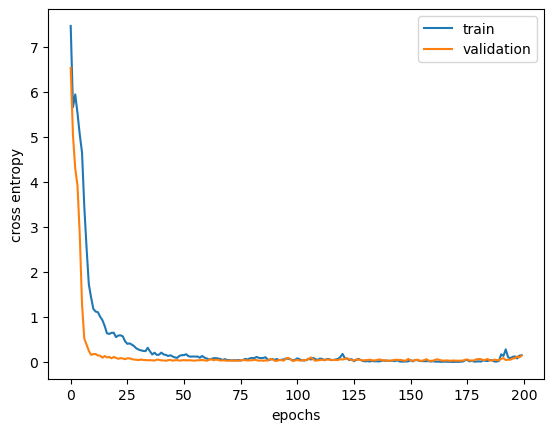

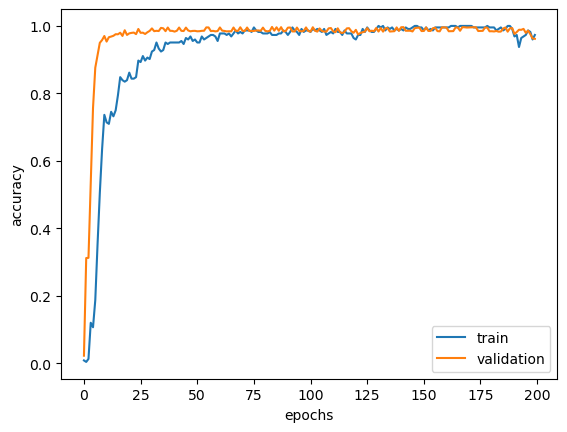

In [15]:
#Use more samples as validation
seq_val_data1 = AlignIO.read(os.path.join(sys.path[0],"Data/Replicates/Validation_extended_align.fasta"),"fasta")
seq_X_val1, seq_y_val1 = speciesDNA_encoder(seq_val_data1, species_id)

seq_model = CNNZ(seq_X_train, seq_y_train, 5) #Note : Apparently, the padding increase the accuracys
seq_test = CNN_train(seq_model, seq_X_train, seq_X_val1, seq_y_train, seq_y_val1, 32, 0.005, "cpu") #Remember that the data is already one shot encoded

torch.Size([224, 5, 2793])
batches_per_epoch 7


Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  6.50batch/s, acc=0, loss=9.69]


Epoch 0 validation: Cross-entropy=6.88, Accuracy=2.8%


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  5.91batch/s, acc=0, loss=5.84]


Epoch 1 validation: Cross-entropy=5.71, Accuracy=0.1%


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  6.02batch/s, acc=0, loss=5.04]


Epoch 2 validation: Cross-entropy=5.15, Accuracy=5.7%


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  6.10batch/s, acc=0, loss=6.06]    


Epoch 3 validation: Cross-entropy=5.15, Accuracy=12.3%


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  6.11batch/s, acc=0, loss=5.9]      


Epoch 4 validation: Cross-entropy=4.81, Accuracy=12.3%


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  6.13batch/s, acc=0.0312, loss=5.12]


Epoch 5 validation: Cross-entropy=4.90, Accuracy=7.1%


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  6.14batch/s, acc=0.0625, loss=4.48]


Epoch 6 validation: Cross-entropy=5.57, Accuracy=3.3%


Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.312, loss=3.44] 


Epoch 7 validation: Cross-entropy=5.58, Accuracy=13.7%


Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.25, loss=3.24]  


Epoch 8 validation: Cross-entropy=5.52, Accuracy=12.3%


Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.281, loss=2.66] 


Epoch 9 validation: Cross-entropy=5.61, Accuracy=12.1%


Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.438, loss=2.64] 


Epoch 10 validation: Cross-entropy=5.84, Accuracy=11.9%


Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.281, loss=2.42] 


Epoch 11 validation: Cross-entropy=5.95, Accuracy=0.6%


Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.5, loss=1.99]   


Epoch 12 validation: Cross-entropy=6.09, Accuracy=1.4%


Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.531, loss=2.07] 


Epoch 13 validation: Cross-entropy=6.03, Accuracy=12.3%


Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.531, loss=1.91] 


Epoch 14 validation: Cross-entropy=5.95, Accuracy=8.8%


Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.656, loss=1.63] 


Epoch 15 validation: Cross-entropy=6.05, Accuracy=11.9%


Epoch 16: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.625, loss=1.29] 


Epoch 16 validation: Cross-entropy=6.23, Accuracy=11.9%


Epoch 17: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.656, loss=1.02] 


Epoch 17 validation: Cross-entropy=6.27, Accuracy=1.3%


Epoch 18: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.781, loss=1.08] 


Epoch 18 validation: Cross-entropy=6.33, Accuracy=2.3%


Epoch 19: 100%|██████████| 7/7 [00:01<00:00,  6.17batch/s, acc=0.812, loss=0.747]


Epoch 19 validation: Cross-entropy=6.42, Accuracy=5.3%


Epoch 20: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.656, loss=1.34] 


Epoch 20 validation: Cross-entropy=6.35, Accuracy=12.0%


Epoch 21: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.656, loss=1.19] 


Epoch 21 validation: Cross-entropy=6.30, Accuracy=11.8%


Epoch 22: 100%|██████████| 7/7 [00:01<00:00,  6.17batch/s, acc=0.719, loss=1.25] 


Epoch 22 validation: Cross-entropy=6.28, Accuracy=5.6%


Epoch 23: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.75, loss=1.04]  


Epoch 23 validation: Cross-entropy=6.28, Accuracy=11.3%


Epoch 24: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.719, loss=1]    


Epoch 24 validation: Cross-entropy=6.25, Accuracy=11.8%


Epoch 25: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.781, loss=0.95] 


Epoch 25 validation: Cross-entropy=6.29, Accuracy=11.3%


Epoch 26: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.781, loss=0.652]


Epoch 26 validation: Cross-entropy=6.44, Accuracy=11.2%


Epoch 27: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.719, loss=0.888]


Epoch 27 validation: Cross-entropy=6.49, Accuracy=11.0%


Epoch 28: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.812, loss=0.71] 


Epoch 28 validation: Cross-entropy=6.56, Accuracy=5.2%


Epoch 29: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.844, loss=0.671]


Epoch 29 validation: Cross-entropy=6.62, Accuracy=11.0%


Epoch 30: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.875, loss=0.503] 


Epoch 30 validation: Cross-entropy=6.67, Accuracy=11.1%


Epoch 31: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.812, loss=0.511] 


Epoch 31 validation: Cross-entropy=6.65, Accuracy=11.5%


Epoch 32: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.844, loss=0.518]


Epoch 32 validation: Cross-entropy=6.56, Accuracy=11.9%


Epoch 33: 100%|██████████| 7/7 [00:01<00:00,  6.05batch/s, acc=0.906, loss=0.319] 


Epoch 33 validation: Cross-entropy=6.42, Accuracy=12.0%


Epoch 34: 100%|██████████| 7/7 [00:01<00:00,  6.17batch/s, acc=0.812, loss=0.394] 


Epoch 34 validation: Cross-entropy=6.35, Accuracy=12.0%


Epoch 35: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.938, loss=0.352]


Epoch 35 validation: Cross-entropy=6.33, Accuracy=11.9%


Epoch 36: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.906, loss=0.472]


Epoch 36 validation: Cross-entropy=6.41, Accuracy=11.3%


Epoch 37: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.906, loss=0.257]


Epoch 37 validation: Cross-entropy=6.53, Accuracy=0.6%


Epoch 38: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.969, loss=0.278]


Epoch 38 validation: Cross-entropy=6.62, Accuracy=0.5%


Epoch 39: 100%|██████████| 7/7 [00:01<00:00,  5.95batch/s, acc=0.938, loss=0.214]


Epoch 39 validation: Cross-entropy=6.68, Accuracy=0.5%


Epoch 40: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.969, loss=0.145]


Epoch 40 validation: Cross-entropy=6.64, Accuracy=0.6%


Epoch 41: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.969, loss=0.124] 


Epoch 41 validation: Cross-entropy=6.63, Accuracy=0.5%


Epoch 42: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=1, loss=0.0944]   


Epoch 42 validation: Cross-entropy=6.62, Accuracy=0.6%


Epoch 43: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=1, loss=0.0186]   


Epoch 43 validation: Cross-entropy=6.57, Accuracy=1.6%


Epoch 44: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.969, loss=0.0619]


Epoch 44 validation: Cross-entropy=6.55, Accuracy=0.6%


Epoch 45: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.969, loss=0.0805]


Epoch 45 validation: Cross-entropy=6.57, Accuracy=0.6%


Epoch 46: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=1, loss=0.0578]   


Epoch 46 validation: Cross-entropy=6.56, Accuracy=0.6%


Epoch 47: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=1, loss=0.0447]   


Epoch 47 validation: Cross-entropy=6.54, Accuracy=0.6%


Epoch 48: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=1, loss=0.0338]   


Epoch 48 validation: Cross-entropy=6.53, Accuracy=0.6%


Epoch 49: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=1, loss=0.0231]   


Epoch 49 validation: Cross-entropy=6.55, Accuracy=0.7%


Epoch 50: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=1, loss=0.00822]  


Epoch 50 validation: Cross-entropy=6.59, Accuracy=0.6%


Epoch 51: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=1, loss=0.00804]  


Epoch 51 validation: Cross-entropy=6.61, Accuracy=0.5%


Epoch 52: 100%|██████████| 7/7 [00:01<00:00,  6.14batch/s, acc=1, loss=0.012]     


Epoch 52 validation: Cross-entropy=6.58, Accuracy=0.6%


Epoch 53: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=1, loss=0.00846]  


Epoch 53 validation: Cross-entropy=6.62, Accuracy=0.6%


Epoch 54: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=1, loss=0.00622]  


Epoch 54 validation: Cross-entropy=6.66, Accuracy=0.6%


Epoch 55: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=1, loss=0.00999]  


Epoch 55 validation: Cross-entropy=6.69, Accuracy=0.5%


Epoch 56: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=1, loss=0.00807]  


Epoch 56 validation: Cross-entropy=6.67, Accuracy=0.6%


Epoch 57: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=1, loss=0.0039]   


Epoch 57 validation: Cross-entropy=6.62, Accuracy=0.6%


Epoch 58: 100%|██████████| 7/7 [00:01<00:00,  6.14batch/s, acc=1, loss=0.0246]   


Epoch 58 validation: Cross-entropy=6.61, Accuracy=0.6%


Epoch 59: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=1, loss=0.00616]  


Epoch 59 validation: Cross-entropy=6.61, Accuracy=0.6%


Epoch 60: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.969, loss=0.0892]


Epoch 60 validation: Cross-entropy=6.63, Accuracy=0.6%


Epoch 61: 100%|██████████| 7/7 [00:01<00:00,  6.14batch/s, acc=0.969, loss=0.117]


Epoch 61 validation: Cross-entropy=6.68, Accuracy=0.6%


Epoch 62: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.969, loss=0.0771]


Epoch 62 validation: Cross-entropy=6.71, Accuracy=0.5%


Epoch 63: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.969, loss=0.0766]


Epoch 63 validation: Cross-entropy=6.72, Accuracy=0.5%


Epoch 64: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=1, loss=0.0528]   


Epoch 64 validation: Cross-entropy=6.72, Accuracy=0.6%


Epoch 65: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.969, loss=0.0682]


Epoch 65 validation: Cross-entropy=6.74, Accuracy=0.6%


Epoch 66: 100%|██████████| 7/7 [00:01<00:00,  6.14batch/s, acc=1, loss=0.054]    


Epoch 66 validation: Cross-entropy=6.73, Accuracy=0.6%


Epoch 67: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s, acc=0.969, loss=0.115]


Epoch 67 validation: Cross-entropy=6.68, Accuracy=0.7%


Epoch 68: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.875, loss=0.402]


Epoch 68 validation: Cross-entropy=6.67, Accuracy=0.7%


Epoch 69: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.969, loss=0.4]  


Epoch 69 validation: Cross-entropy=6.78, Accuracy=0.6%


Epoch 70: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.906, loss=0.325]


Epoch 70 validation: Cross-entropy=6.74, Accuracy=0.6%


Epoch 71: 100%|██████████| 7/7 [00:01<00:00,  6.14batch/s, acc=0.969, loss=0.146]


Epoch 71 validation: Cross-entropy=6.75, Accuracy=1.5%


Epoch 72: 100%|██████████| 7/7 [00:01<00:00,  6.17batch/s, acc=0.906, loss=0.367]


Epoch 72 validation: Cross-entropy=6.77, Accuracy=2.8%


Epoch 73: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.875, loss=0.31] 


Epoch 73 validation: Cross-entropy=6.72, Accuracy=1.4%


Epoch 74: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.938, loss=0.157]


Epoch 74 validation: Cross-entropy=6.67, Accuracy=1.3%


Epoch 75: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.969, loss=0.102]


Epoch 75 validation: Cross-entropy=6.63, Accuracy=2.3%


Epoch 76: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=0.969, loss=0.0681]


Epoch 76 validation: Cross-entropy=6.58, Accuracy=10.9%


Epoch 77: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=1, loss=0.0229]  


Epoch 77 validation: Cross-entropy=6.55, Accuracy=11.4%


Epoch 78: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=1, loss=0.00911]  


Epoch 78 validation: Cross-entropy=6.55, Accuracy=10.5%


Epoch 79: 100%|██████████| 7/7 [00:01<00:00,  6.17batch/s, acc=1, loss=0.0175]   


Epoch 79 validation: Cross-entropy=6.61, Accuracy=11.8%


Epoch 80: 100%|██████████| 7/7 [00:01<00:00,  6.17batch/s, acc=1, loss=0.0176]   


Epoch 80 validation: Cross-entropy=6.73, Accuracy=5.2%


Epoch 81: 100%|██████████| 7/7 [00:01<00:00,  6.17batch/s, acc=1, loss=0.00288]  


Epoch 81 validation: Cross-entropy=6.80, Accuracy=1.2%


Epoch 82: 100%|██████████| 7/7 [00:01<00:00,  6.17batch/s, acc=1, loss=0.0225]   


Epoch 82 validation: Cross-entropy=6.81, Accuracy=0.8%


Epoch 83: 100%|██████████| 7/7 [00:01<00:00,  6.17batch/s, acc=1, loss=0.00943]  


Epoch 83 validation: Cross-entropy=6.76, Accuracy=0.7%


Epoch 84: 100%|██████████| 7/7 [00:01<00:00,  6.18batch/s, acc=1, loss=0.00975]  


Epoch 84 validation: Cross-entropy=6.65, Accuracy=0.6%


Epoch 85: 100%|██████████| 7/7 [00:01<00:00,  6.18batch/s, acc=1, loss=0.0141]   


Epoch 85 validation: Cross-entropy=6.56, Accuracy=0.6%


Epoch 86: 100%|██████████| 7/7 [00:01<00:00,  6.17batch/s, acc=1, loss=0.0172]    


Epoch 86 validation: Cross-entropy=6.53, Accuracy=0.7%


Epoch 87: 100%|██████████| 7/7 [00:01<00:00,  6.17batch/s, acc=1, loss=0.00325]   


Epoch 87 validation: Cross-entropy=6.54, Accuracy=0.8%


Epoch 88: 100%|██████████| 7/7 [00:01<00:00,  6.03batch/s, acc=1, loss=0.0179]   


Epoch 88 validation: Cross-entropy=6.56, Accuracy=0.9%


Epoch 89: 100%|██████████| 7/7 [00:01<00:00,  6.12batch/s, acc=0.969, loss=0.0603]


Epoch 89 validation: Cross-entropy=6.58, Accuracy=0.9%


Epoch 90: 100%|██████████| 7/7 [00:01<00:00,  6.17batch/s, acc=0.969, loss=0.141]


Epoch 90 validation: Cross-entropy=6.60, Accuracy=1.8%


Epoch 91: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s, acc=1, loss=0.0258]   


Epoch 91 validation: Cross-entropy=6.65, Accuracy=2.7%


Epoch 92: 100%|██████████| 7/7 [00:01<00:00,  6.17batch/s, acc=0.969, loss=0.085]


Epoch 92 validation: Cross-entropy=6.66, Accuracy=4.6%


Epoch 93: 100%|██████████| 7/7 [00:01<00:00,  6.12batch/s, acc=1, loss=0.0175]   


Epoch 93 validation: Cross-entropy=6.68, Accuracy=6.4%


Epoch 94: 100%|██████████| 7/7 [00:01<00:00,  5.86batch/s, acc=0.969, loss=0.0378]


Epoch 94 validation: Cross-entropy=6.71, Accuracy=5.2%


Epoch 95: 100%|██████████| 7/7 [00:01<00:00,  6.12batch/s, acc=1, loss=0.021]    


Epoch 95 validation: Cross-entropy=6.71, Accuracy=4.5%


Epoch 96: 100%|██████████| 7/7 [00:01<00:00,  5.94batch/s, acc=0.969, loss=0.0259]


Epoch 96 validation: Cross-entropy=6.69, Accuracy=2.9%


Epoch 97: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=1, loss=0.0141]   


Epoch 97 validation: Cross-entropy=6.65, Accuracy=2.5%


Epoch 98: 100%|██████████| 7/7 [00:01<00:00,  5.27batch/s, acc=1, loss=0.0168]   


Epoch 98 validation: Cross-entropy=6.61, Accuracy=2.6%


Epoch 99: 100%|██████████| 7/7 [00:01<00:00,  5.01batch/s, acc=1, loss=0.00687]   


Epoch 99 validation: Cross-entropy=6.60, Accuracy=1.5%


Epoch 100: 100%|██████████| 7/7 [00:01<00:00,  4.52batch/s, acc=1, loss=0.00354]  


Epoch 100 validation: Cross-entropy=6.58, Accuracy=1.1%


Epoch 101: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=1, loss=0.00129]  


Epoch 101 validation: Cross-entropy=6.53, Accuracy=1.1%


Epoch 102: 100%|██████████| 7/7 [00:01<00:00,  4.66batch/s, acc=1, loss=0.00401]  


Epoch 102 validation: Cross-entropy=6.54, Accuracy=1.0%


Epoch 103: 100%|██████████| 7/7 [00:01<00:00,  4.63batch/s, acc=1, loss=0.000855] 


Epoch 103 validation: Cross-entropy=6.63, Accuracy=1.0%


Epoch 104: 100%|██████████| 7/7 [00:01<00:00,  4.13batch/s, acc=1, loss=0.00283]  


Epoch 104 validation: Cross-entropy=6.71, Accuracy=1.2%


Epoch 105: 100%|██████████| 7/7 [00:01<00:00,  4.50batch/s, acc=1, loss=0.00152]   


Epoch 105 validation: Cross-entropy=6.74, Accuracy=1.2%


Epoch 106: 100%|██████████| 7/7 [00:01<00:00,  4.35batch/s, acc=1, loss=0.0122]   


Epoch 106 validation: Cross-entropy=6.75, Accuracy=1.3%


Epoch 107: 100%|██████████| 7/7 [00:01<00:00,  4.33batch/s, acc=1, loss=0.00781]  


Epoch 107 validation: Cross-entropy=6.76, Accuracy=1.3%


Epoch 108: 100%|██████████| 7/7 [00:01<00:00,  4.29batch/s, acc=1, loss=0.00248]  


Epoch 108 validation: Cross-entropy=6.76, Accuracy=1.2%


Epoch 109: 100%|██████████| 7/7 [00:01<00:00,  4.28batch/s, acc=1, loss=0.00786]  


Epoch 109 validation: Cross-entropy=6.75, Accuracy=1.2%


Epoch 110: 100%|██████████| 7/7 [00:01<00:00,  4.27batch/s, acc=1, loss=0.00203]  


Epoch 110 validation: Cross-entropy=6.73, Accuracy=1.0%


Epoch 111: 100%|██████████| 7/7 [00:01<00:00,  4.26batch/s, acc=1, loss=0.00188] 


Epoch 111 validation: Cross-entropy=6.73, Accuracy=1.0%


Epoch 112: 100%|██████████| 7/7 [00:01<00:00,  4.13batch/s, acc=1, loss=0.00125]   


Epoch 112 validation: Cross-entropy=6.73, Accuracy=1.1%


Epoch 113: 100%|██████████| 7/7 [00:01<00:00,  4.24batch/s, acc=1, loss=0.015]    


Epoch 113 validation: Cross-entropy=6.75, Accuracy=1.1%


Epoch 114: 100%|██████████| 7/7 [00:01<00:00,  4.23batch/s, acc=1, loss=0.00425]  


Epoch 114 validation: Cross-entropy=6.77, Accuracy=1.0%


Epoch 115: 100%|██████████| 7/7 [00:01<00:00,  4.21batch/s, acc=1, loss=0.00342]  


Epoch 115 validation: Cross-entropy=6.78, Accuracy=1.0%


Epoch 116: 100%|██████████| 7/7 [00:01<00:00,  4.23batch/s, acc=1, loss=0.00269]  


Epoch 116 validation: Cross-entropy=6.82, Accuracy=0.9%


Epoch 117: 100%|██████████| 7/7 [00:01<00:00,  4.22batch/s, acc=1, loss=0.00221]  


Epoch 117 validation: Cross-entropy=6.84, Accuracy=1.0%


Epoch 118: 100%|██████████| 7/7 [00:01<00:00,  4.21batch/s, acc=1, loss=0.00221]  


Epoch 118 validation: Cross-entropy=6.84, Accuracy=1.1%


Epoch 119: 100%|██████████| 7/7 [00:01<00:00,  4.22batch/s, acc=1, loss=0.00154]  


Epoch 119 validation: Cross-entropy=6.82, Accuracy=1.3%


Epoch 120: 100%|██████████| 7/7 [00:01<00:00,  4.21batch/s, acc=1, loss=0.00125]  


Epoch 120 validation: Cross-entropy=6.78, Accuracy=1.3%


Epoch 121: 100%|██████████| 7/7 [00:01<00:00,  4.23batch/s, acc=1, loss=0.0012]    


Epoch 121 validation: Cross-entropy=6.76, Accuracy=1.3%


Epoch 122: 100%|██████████| 7/7 [00:01<00:00,  4.24batch/s, acc=1, loss=0.000988]  


Epoch 122 validation: Cross-entropy=6.76, Accuracy=1.2%


Epoch 123: 100%|██████████| 7/7 [00:01<00:00,  4.30batch/s, acc=1, loss=0.00241]  


Epoch 123 validation: Cross-entropy=6.79, Accuracy=1.0%


Epoch 124: 100%|██████████| 7/7 [00:01<00:00,  4.46batch/s, acc=1, loss=0.00127]  


Epoch 124 validation: Cross-entropy=6.81, Accuracy=1.0%


Epoch 125: 100%|██████████| 7/7 [00:01<00:00,  4.71batch/s, acc=1, loss=0.00404]  


Epoch 125 validation: Cross-entropy=6.79, Accuracy=1.1%


Epoch 126: 100%|██████████| 7/7 [00:01<00:00,  4.86batch/s, acc=1, loss=0.000888] 


Epoch 126 validation: Cross-entropy=6.78, Accuracy=1.2%


Epoch 127: 100%|██████████| 7/7 [00:01<00:00,  4.87batch/s, acc=1, loss=0.00127] 


Epoch 127 validation: Cross-entropy=6.77, Accuracy=1.3%


Epoch 128: 100%|██████████| 7/7 [00:01<00:00,  4.89batch/s, acc=1, loss=0.00146]   


Epoch 128 validation: Cross-entropy=6.77, Accuracy=1.3%


Epoch 129: 100%|██████████| 7/7 [00:01<00:00,  4.87batch/s, acc=1, loss=0.00159] 


Epoch 129 validation: Cross-entropy=6.79, Accuracy=1.3%


Epoch 130: 100%|██████████| 7/7 [00:01<00:00,  4.90batch/s, acc=1, loss=0.00127] 


Epoch 130 validation: Cross-entropy=6.80, Accuracy=1.2%


Epoch 131: 100%|██████████| 7/7 [00:01<00:00,  4.89batch/s, acc=1, loss=0.00058]  


Epoch 131 validation: Cross-entropy=6.79, Accuracy=1.1%


Epoch 132: 100%|██████████| 7/7 [00:01<00:00,  4.89batch/s, acc=1, loss=0.000841] 


Epoch 132 validation: Cross-entropy=6.79, Accuracy=1.1%


Epoch 133: 100%|██████████| 7/7 [00:01<00:00,  4.83batch/s, acc=1, loss=0.000442]


Epoch 133 validation: Cross-entropy=6.79, Accuracy=1.2%


Epoch 134: 100%|██████████| 7/7 [00:01<00:00,  4.86batch/s, acc=1, loss=0.000317] 


Epoch 134 validation: Cross-entropy=6.82, Accuracy=1.2%


Epoch 135: 100%|██████████| 7/7 [00:01<00:00,  4.89batch/s, acc=1, loss=0.000614]


Epoch 135 validation: Cross-entropy=6.83, Accuracy=1.2%


Epoch 136: 100%|██████████| 7/7 [00:01<00:00,  4.88batch/s, acc=1, loss=0.00152]   


Epoch 136 validation: Cross-entropy=6.83, Accuracy=1.2%


Epoch 137: 100%|██████████| 7/7 [00:01<00:00,  4.89batch/s, acc=1, loss=0.00039] 


Epoch 137 validation: Cross-entropy=6.85, Accuracy=1.2%


Epoch 138: 100%|██████████| 7/7 [00:01<00:00,  4.90batch/s, acc=1, loss=0.000593] 


Epoch 138 validation: Cross-entropy=6.87, Accuracy=1.1%


Epoch 139: 100%|██████████| 7/7 [00:01<00:00,  4.90batch/s, acc=1, loss=0.00344]  


Epoch 139 validation: Cross-entropy=6.86, Accuracy=1.1%


Epoch 140: 100%|██████████| 7/7 [00:01<00:00,  4.89batch/s, acc=1, loss=0.00451]  


Epoch 140 validation: Cross-entropy=6.85, Accuracy=1.1%


Epoch 141: 100%|██████████| 7/7 [00:01<00:00,  4.90batch/s, acc=1, loss=0.00037]   


Epoch 141 validation: Cross-entropy=6.83, Accuracy=1.1%


Epoch 142: 100%|██████████| 7/7 [00:01<00:00,  4.74batch/s, acc=1, loss=0.00919]   


Epoch 142 validation: Cross-entropy=6.78, Accuracy=1.2%


Epoch 143: 100%|██████████| 7/7 [00:01<00:00,  4.90batch/s, acc=1, loss=0.0156]    


Epoch 143 validation: Cross-entropy=6.69, Accuracy=1.3%


Epoch 144: 100%|██████████| 7/7 [00:01<00:00,  4.89batch/s, acc=1, loss=0.00359]   


Epoch 144 validation: Cross-entropy=6.69, Accuracy=1.3%


Epoch 145: 100%|██████████| 7/7 [00:01<00:00,  4.90batch/s, acc=1, loss=0.0232]   


Epoch 145 validation: Cross-entropy=6.80, Accuracy=1.0%


Epoch 146: 100%|██████████| 7/7 [00:01<00:00,  4.88batch/s, acc=0.906, loss=0.343]


Epoch 146 validation: Cross-entropy=6.85, Accuracy=0.9%


Epoch 147: 100%|██████████| 7/7 [00:01<00:00,  4.86batch/s, acc=0.875, loss=0.837]


Epoch 147 validation: Cross-entropy=6.80, Accuracy=0.8%


Epoch 148: 100%|██████████| 7/7 [00:01<00:00,  4.88batch/s, acc=0.844, loss=0.825] 


Epoch 148 validation: Cross-entropy=6.70, Accuracy=0.8%


Epoch 149: 100%|██████████| 7/7 [00:01<00:00,  4.88batch/s, acc=0.875, loss=0.584]


Epoch 149 validation: Cross-entropy=6.65, Accuracy=0.7%


Epoch 150: 100%|██████████| 7/7 [00:01<00:00,  4.90batch/s, acc=0.938, loss=0.197] 


Epoch 150 validation: Cross-entropy=6.69, Accuracy=0.8%


Epoch 151: 100%|██████████| 7/7 [00:01<00:00,  4.90batch/s, acc=0.875, loss=0.354] 


Epoch 151 validation: Cross-entropy=6.70, Accuracy=1.4%


Epoch 152: 100%|██████████| 7/7 [00:01<00:00,  4.91batch/s, acc=0.875, loss=0.516]


Epoch 152 validation: Cross-entropy=6.64, Accuracy=3.8%


Epoch 153: 100%|██████████| 7/7 [00:01<00:00,  4.91batch/s, acc=0.875, loss=0.394] 


Epoch 153 validation: Cross-entropy=6.78, Accuracy=1.3%


Epoch 154: 100%|██████████| 7/7 [00:01<00:00,  4.92batch/s, acc=0.875, loss=0.55] 


Epoch 154 validation: Cross-entropy=6.77, Accuracy=1.2%


Epoch 155: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=0.875, loss=0.33]  


Epoch 155 validation: Cross-entropy=6.65, Accuracy=1.3%


Epoch 156: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=0.875, loss=0.686] 


Epoch 156 validation: Cross-entropy=6.81, Accuracy=1.9%


Epoch 157: 100%|██████████| 7/7 [00:01<00:00,  4.92batch/s, acc=0.875, loss=0.297]


Epoch 157 validation: Cross-entropy=6.76, Accuracy=1.0%


Epoch 158: 100%|██████████| 7/7 [00:01<00:00,  4.94batch/s, acc=0.938, loss=0.155]


Epoch 158 validation: Cross-entropy=6.88, Accuracy=0.8%


Epoch 159: 100%|██████████| 7/7 [00:01<00:00,  4.92batch/s, acc=1, loss=0.0166]    


Epoch 159 validation: Cross-entropy=6.96, Accuracy=0.9%


Epoch 160: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=0.938, loss=0.184]


Epoch 160 validation: Cross-entropy=6.98, Accuracy=0.8%


Epoch 161: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=0.969, loss=0.103]


Epoch 161 validation: Cross-entropy=6.96, Accuracy=1.1%


Epoch 162: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=0.906, loss=0.203]


Epoch 162 validation: Cross-entropy=7.05, Accuracy=1.0%


Epoch 163: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.0145]    


Epoch 163 validation: Cross-entropy=7.12, Accuracy=1.1%


Epoch 164: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=0.969, loss=0.0767]


Epoch 164 validation: Cross-entropy=7.16, Accuracy=1.1%


Epoch 165: 100%|██████████| 7/7 [00:01<00:00,  4.92batch/s, acc=1, loss=0.0185]   


Epoch 165 validation: Cross-entropy=7.17, Accuracy=1.0%


Epoch 166: 100%|██████████| 7/7 [00:01<00:00,  4.91batch/s, acc=0.906, loss=0.214] 


Epoch 166 validation: Cross-entropy=7.16, Accuracy=1.1%


Epoch 167: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.0107]   


Epoch 167 validation: Cross-entropy=7.18, Accuracy=0.9%


Epoch 168: 100%|██████████| 7/7 [00:01<00:00,  4.92batch/s, acc=0.938, loss=0.205]


Epoch 168 validation: Cross-entropy=7.22, Accuracy=0.8%


Epoch 169: 100%|██████████| 7/7 [00:01<00:00,  4.84batch/s, acc=1, loss=0.0042]    


Epoch 169 validation: Cross-entropy=7.23, Accuracy=0.7%


Epoch 170: 100%|██████████| 7/7 [00:01<00:00,  4.88batch/s, acc=0.938, loss=0.0863]


Epoch 170 validation: Cross-entropy=7.21, Accuracy=0.7%


Epoch 171: 100%|██████████| 7/7 [00:01<00:00,  4.94batch/s, acc=0.969, loss=0.0632]


Epoch 171 validation: Cross-entropy=7.19, Accuracy=0.7%


Epoch 172: 100%|██████████| 7/7 [00:01<00:00,  4.94batch/s, acc=0.969, loss=0.0713]


Epoch 172 validation: Cross-entropy=7.21, Accuracy=1.0%


Epoch 173: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=0.969, loss=0.0586]


Epoch 173 validation: Cross-entropy=7.25, Accuracy=1.0%


Epoch 174: 100%|██████████| 7/7 [00:01<00:00,  4.94batch/s, acc=1, loss=0.00858]  


Epoch 174 validation: Cross-entropy=7.27, Accuracy=1.0%


Epoch 175: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.01]     


Epoch 175 validation: Cross-entropy=7.23, Accuracy=0.9%


Epoch 176: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.0233]    


Epoch 176 validation: Cross-entropy=7.22, Accuracy=0.8%


Epoch 177: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.0047]    


Epoch 177 validation: Cross-entropy=7.27, Accuracy=0.8%


Epoch 178: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=0.969, loss=0.0341]


Epoch 178 validation: Cross-entropy=7.31, Accuracy=0.8%


Epoch 179: 100%|██████████| 7/7 [00:01<00:00,  4.94batch/s, acc=1, loss=0.00741]   


Epoch 179 validation: Cross-entropy=7.32, Accuracy=0.9%


Epoch 180: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.00705]   


Epoch 180 validation: Cross-entropy=7.31, Accuracy=0.9%


Epoch 181: 100%|██████████| 7/7 [00:01<00:00,  4.92batch/s, acc=1, loss=0.00107]   


Epoch 181 validation: Cross-entropy=7.32, Accuracy=0.9%


Epoch 182: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.0211]    


Epoch 182 validation: Cross-entropy=7.33, Accuracy=0.9%


Epoch 183: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.000736]


Epoch 183 validation: Cross-entropy=7.34, Accuracy=0.9%


Epoch 184: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.00297]   


Epoch 184 validation: Cross-entropy=7.34, Accuracy=0.9%


Epoch 185: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.00107] 


Epoch 185 validation: Cross-entropy=7.36, Accuracy=0.9%


Epoch 186: 100%|██████████| 7/7 [00:01<00:00,  4.78batch/s, acc=1, loss=0.00158] 


Epoch 186 validation: Cross-entropy=7.37, Accuracy=0.9%


Epoch 187: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.00189]   


Epoch 187 validation: Cross-entropy=7.37, Accuracy=0.9%


Epoch 188: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.00565]   


Epoch 188 validation: Cross-entropy=7.35, Accuracy=0.9%


Epoch 189: 100%|██████████| 7/7 [00:01<00:00,  4.92batch/s, acc=1, loss=0.00247]   


Epoch 189 validation: Cross-entropy=7.33, Accuracy=0.9%


Epoch 190: 100%|██████████| 7/7 [00:01<00:00,  4.92batch/s, acc=1, loss=0.00205]  


Epoch 190 validation: Cross-entropy=7.32, Accuracy=0.9%


Epoch 191: 100%|██████████| 7/7 [00:01<00:00,  4.92batch/s, acc=1, loss=0.000694]  


Epoch 191 validation: Cross-entropy=7.30, Accuracy=0.9%


Epoch 192: 100%|██████████| 7/7 [00:01<00:00,  4.92batch/s, acc=1, loss=0.000919] 


Epoch 192 validation: Cross-entropy=7.28, Accuracy=1.0%


Epoch 193: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.002]     


Epoch 193 validation: Cross-entropy=7.26, Accuracy=1.0%


Epoch 194: 100%|██████████| 7/7 [00:01<00:00,  4.94batch/s, acc=1, loss=0.00496] 


Epoch 194 validation: Cross-entropy=7.27, Accuracy=1.0%


Epoch 195: 100%|██████████| 7/7 [00:01<00:00,  4.92batch/s, acc=1, loss=0.00066]  


Epoch 195 validation: Cross-entropy=7.27, Accuracy=1.0%


Epoch 196: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.00056]  


Epoch 196 validation: Cross-entropy=7.28, Accuracy=1.0%


Epoch 197: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.000294] 


Epoch 197 validation: Cross-entropy=7.27, Accuracy=1.0%


Epoch 198: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.00168]   


Epoch 198 validation: Cross-entropy=7.25, Accuracy=1.0%


Epoch 199: 100%|██████████| 7/7 [00:01<00:00,  4.93batch/s, acc=1, loss=0.00185]  


Epoch 199 validation: Cross-entropy=7.23, Accuracy=1.1%


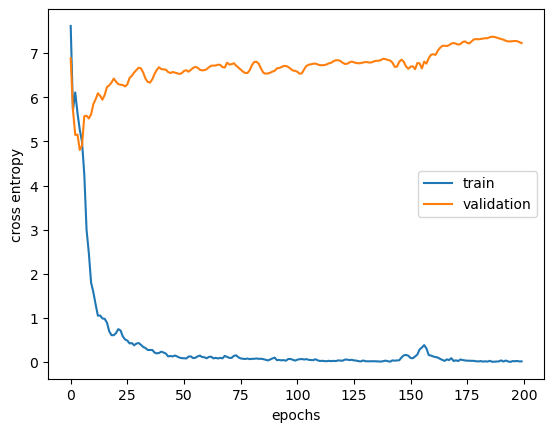

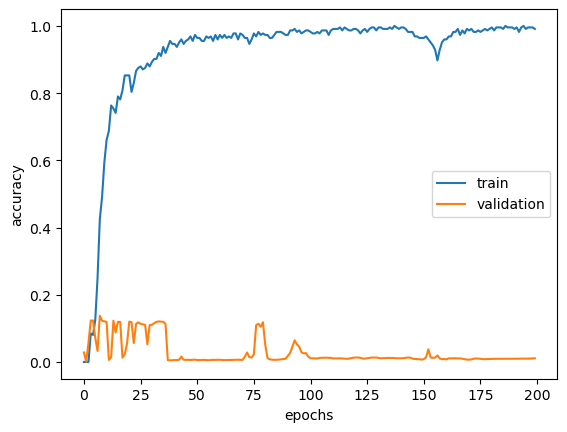

In [57]:
#Try training the data with other validations sets (right)
seq_val_data1 = AlignIO.read(os.path.join(sys.path[0],"Data/Replicates/Validation_extended_right.fasta"),"fasta")
seq_X_val1, seq_y_val1 = speciesDNA_encoder(seq_val_data1, species_id)

seq_model = CNNZ(seq_X_train, seq_y_train, 5) #Note : Apparently, the padding increase the accuracys
seq_test = CNN_train(seq_model, seq_X_train, seq_X_val1, seq_y_train, seq_y_val1, 32, 0.005, "cpu") #Remember that the data is already one shot encoded

torch.Size([224, 5, 2793])
batches_per_epoch 7


Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  6.21batch/s, acc=0, loss=9.55]


Epoch 0 validation: Cross-entropy=6.76, Accuracy=0.5%


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  5.61batch/s, acc=0, loss=5.71]


Epoch 1 validation: Cross-entropy=5.75, Accuracy=0.2%


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  5.61batch/s, acc=0, loss=5.24]     


Epoch 2 validation: Cross-entropy=5.08, Accuracy=3.3%


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  5.61batch/s, acc=0, loss=6.18]    


Epoch 3 validation: Cross-entropy=4.94, Accuracy=12.7%


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  5.49batch/s, acc=0, loss=5.86]     


Epoch 4 validation: Cross-entropy=4.69, Accuracy=12.7%


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  5.62batch/s, acc=0.0312, loss=5.04]


Epoch 5 validation: Cross-entropy=4.95, Accuracy=12.7%


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  5.63batch/s, acc=0.125, loss=4.48] 


Epoch 6 validation: Cross-entropy=5.55, Accuracy=12.7%


Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  5.61batch/s, acc=0.25, loss=3.73]  


Epoch 7 validation: Cross-entropy=5.43, Accuracy=1.7%


Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=0.375, loss=2.77]


Epoch 8 validation: Cross-entropy=5.47, Accuracy=12.7%


Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=0.406, loss=2.41] 


Epoch 9 validation: Cross-entropy=5.42, Accuracy=1.2%


Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  4.63batch/s, acc=0.5, loss=2.09]   


Epoch 10 validation: Cross-entropy=5.45, Accuracy=1.1%


Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  4.50batch/s, acc=0.625, loss=1.68] 


Epoch 11 validation: Cross-entropy=5.46, Accuracy=1.8%


Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  5.57batch/s, acc=0.625, loss=1.56] 


Epoch 12 validation: Cross-entropy=5.64, Accuracy=2.1%


Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=0.5, loss=1.66]   


Epoch 13 validation: Cross-entropy=5.74, Accuracy=2.1%


Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=0.656, loss=1.37] 


Epoch 14 validation: Cross-entropy=5.64, Accuracy=2.1%


Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  5.46batch/s, acc=0.656, loss=1.52] 


Epoch 15 validation: Cross-entropy=5.59, Accuracy=0.7%


Epoch 16: 100%|██████████| 7/7 [00:01<00:00,  5.54batch/s, acc=0.594, loss=1.68] 


Epoch 16 validation: Cross-entropy=5.60, Accuracy=1.5%


Epoch 17: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=0.594, loss=1.77] 


Epoch 17 validation: Cross-entropy=5.64, Accuracy=1.4%


Epoch 18: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=0.594, loss=1.78] 


Epoch 18 validation: Cross-entropy=5.71, Accuracy=1.3%


Epoch 19: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=0.781, loss=1.22] 


Epoch 19 validation: Cross-entropy=5.79, Accuracy=1.4%


Epoch 20: 100%|██████████| 7/7 [00:01<00:00,  5.38batch/s, acc=0.719, loss=1.02] 


Epoch 20 validation: Cross-entropy=5.85, Accuracy=1.4%


Epoch 21: 100%|██████████| 7/7 [00:01<00:00,  5.52batch/s, acc=0.719, loss=0.879] 


Epoch 21 validation: Cross-entropy=5.93, Accuracy=1.4%


Epoch 22: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=0.75, loss=0.742] 


Epoch 22 validation: Cross-entropy=5.82, Accuracy=1.6%


Epoch 23: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=0.844, loss=0.573]


Epoch 23 validation: Cross-entropy=5.78, Accuracy=0.8%


Epoch 24: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=0.812, loss=0.661]


Epoch 24 validation: Cross-entropy=5.76, Accuracy=1.3%


Epoch 25: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=0.844, loss=0.504]


Epoch 25 validation: Cross-entropy=5.74, Accuracy=1.3%


Epoch 26: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=0.906, loss=0.471] 


Epoch 26 validation: Cross-entropy=5.75, Accuracy=1.3%


Epoch 27: 100%|██████████| 7/7 [00:01<00:00,  5.56batch/s, acc=0.844, loss=0.478]


Epoch 27 validation: Cross-entropy=5.84, Accuracy=1.4%


Epoch 28: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=0.844, loss=0.312]


Epoch 28 validation: Cross-entropy=5.90, Accuracy=1.7%


Epoch 29: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=0.938, loss=0.182]


Epoch 29 validation: Cross-entropy=5.92, Accuracy=2.2%


Epoch 30: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=0.906, loss=0.201]


Epoch 30 validation: Cross-entropy=5.89, Accuracy=1.2%


Epoch 31: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=0.906, loss=0.29] 


Epoch 31 validation: Cross-entropy=5.83, Accuracy=1.5%


Epoch 32: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=0.906, loss=0.253]


Epoch 32 validation: Cross-entropy=5.83, Accuracy=4.7%


Epoch 33: 100%|██████████| 7/7 [00:01<00:00,  5.59batch/s, acc=0.875, loss=0.326]


Epoch 33 validation: Cross-entropy=5.83, Accuracy=12.6%


Epoch 34: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=0.906, loss=0.316] 


Epoch 34 validation: Cross-entropy=5.84, Accuracy=12.6%


Epoch 35: 100%|██████████| 7/7 [00:01<00:00,  5.61batch/s, acc=0.938, loss=0.15] 


Epoch 35 validation: Cross-entropy=5.80, Accuracy=3.3%


Epoch 36: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=1, loss=0.0381]    


Epoch 36 validation: Cross-entropy=5.78, Accuracy=1.4%


Epoch 37: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=0.969, loss=0.0773]


Epoch 37 validation: Cross-entropy=5.77, Accuracy=1.5%


Epoch 38: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=0.969, loss=0.0387]


Epoch 38 validation: Cross-entropy=5.79, Accuracy=1.6%


Epoch 39: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=1, loss=0.0206]   


Epoch 39 validation: Cross-entropy=5.81, Accuracy=2.5%


Epoch 40: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=1, loss=0.0285]   


Epoch 40 validation: Cross-entropy=5.80, Accuracy=12.2%


Epoch 41: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=0.969, loss=0.0556]


Epoch 41 validation: Cross-entropy=5.81, Accuracy=12.6%


Epoch 42: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=0.969, loss=0.0906]


Epoch 42 validation: Cross-entropy=5.81, Accuracy=12.6%


Epoch 43: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=1, loss=0.0112]   


Epoch 43 validation: Cross-entropy=5.80, Accuracy=12.6%


Epoch 44: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=0.969, loss=0.0486]


Epoch 44 validation: Cross-entropy=5.79, Accuracy=12.6%


Epoch 45: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=0.969, loss=0.0705]


Epoch 45 validation: Cross-entropy=5.79, Accuracy=12.6%


Epoch 46: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=0.938, loss=0.183]


Epoch 46 validation: Cross-entropy=5.79, Accuracy=12.6%


Epoch 47: 100%|██████████| 7/7 [00:01<00:00,  5.58batch/s, acc=0.875, loss=0.327]


Epoch 47 validation: Cross-entropy=5.78, Accuracy=12.6%


Epoch 48: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=0.969, loss=0.105]


Epoch 48 validation: Cross-entropy=5.80, Accuracy=8.2%


Epoch 49: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=0.906, loss=0.136]


Epoch 49 validation: Cross-entropy=5.82, Accuracy=12.4%


Epoch 50: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=0.969, loss=0.149]


Epoch 50 validation: Cross-entropy=5.85, Accuracy=12.5%


Epoch 51: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=1, loss=0.0766]    


Epoch 51 validation: Cross-entropy=5.87, Accuracy=12.6%


Epoch 52: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=1, loss=0.0144]   


Epoch 52 validation: Cross-entropy=5.85, Accuracy=12.6%


Epoch 53: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=1, loss=0.0288]    


Epoch 53 validation: Cross-entropy=5.80, Accuracy=12.5%


Epoch 54: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=1, loss=0.0157]   


Epoch 54 validation: Cross-entropy=5.77, Accuracy=12.6%


Epoch 55: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=1, loss=0.0084]   


Epoch 55 validation: Cross-entropy=5.75, Accuracy=12.6%


Epoch 56: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=1, loss=0.00913]  


Epoch 56 validation: Cross-entropy=5.75, Accuracy=12.6%


Epoch 57: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=1, loss=0.00611]  


Epoch 57 validation: Cross-entropy=5.76, Accuracy=12.6%


Epoch 58: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=1, loss=0.0107]   


Epoch 58 validation: Cross-entropy=5.76, Accuracy=12.6%


Epoch 59: 100%|██████████| 7/7 [00:01<00:00,  5.63batch/s, acc=1, loss=0.00268]   


Epoch 59 validation: Cross-entropy=5.77, Accuracy=12.6%


Epoch 60: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=1, loss=0.00581]   


Epoch 60 validation: Cross-entropy=5.78, Accuracy=12.6%


Epoch 61: 100%|██████████| 7/7 [00:01<00:00,  5.55batch/s, acc=1, loss=0.00195]   


Epoch 61 validation: Cross-entropy=5.80, Accuracy=12.6%


Epoch 62: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=1, loss=0.0117]   


Epoch 62 validation: Cross-entropy=5.82, Accuracy=12.6%


Epoch 63: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=1, loss=0.00202]   


Epoch 63 validation: Cross-entropy=5.81, Accuracy=12.6%


Epoch 64: 100%|██████████| 7/7 [00:01<00:00,  5.63batch/s, acc=1, loss=0.00875]  


Epoch 64 validation: Cross-entropy=5.78, Accuracy=12.6%


Epoch 65: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=1, loss=0.00638]  


Epoch 65 validation: Cross-entropy=5.78, Accuracy=12.6%


Epoch 66: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=1, loss=0.00374]   


Epoch 66 validation: Cross-entropy=5.79, Accuracy=12.6%


Epoch 67: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=1, loss=0.00288]   


Epoch 67 validation: Cross-entropy=5.80, Accuracy=12.6%


Epoch 68: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=1, loss=0.00318]  


Epoch 68 validation: Cross-entropy=5.84, Accuracy=12.6%


Epoch 69: 100%|██████████| 7/7 [00:01<00:00,  5.51batch/s, acc=1, loss=0.00793]  


Epoch 69 validation: Cross-entropy=5.84, Accuracy=12.7%


Epoch 70: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=1, loss=0.0102]   


Epoch 70 validation: Cross-entropy=5.82, Accuracy=12.6%


Epoch 71: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=1, loss=0.00437]  


Epoch 71 validation: Cross-entropy=5.79, Accuracy=12.6%


Epoch 72: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=0.969, loss=0.0479]


Epoch 72 validation: Cross-entropy=5.78, Accuracy=12.6%


Epoch 73: 100%|██████████| 7/7 [00:01<00:00,  5.50batch/s, acc=0.875, loss=0.447]


Epoch 73 validation: Cross-entropy=5.79, Accuracy=12.6%


Epoch 74: 100%|██████████| 7/7 [00:01<00:00,  5.63batch/s, acc=0.906, loss=0.525]


Epoch 74 validation: Cross-entropy=5.89, Accuracy=12.7%


Epoch 75: 100%|██████████| 7/7 [00:01<00:00,  5.63batch/s, acc=0.844, loss=0.54]  


Epoch 75 validation: Cross-entropy=5.92, Accuracy=12.7%


Epoch 76: 100%|██████████| 7/7 [00:01<00:00,  5.51batch/s, acc=0.938, loss=0.182]


Epoch 76 validation: Cross-entropy=5.96, Accuracy=12.6%


Epoch 77: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=0.906, loss=0.165]


Epoch 77 validation: Cross-entropy=5.94, Accuracy=12.6%


Epoch 78: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=0.969, loss=0.154]


Epoch 78 validation: Cross-entropy=5.91, Accuracy=11.3%


Epoch 79: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=1, loss=0.0282]    


Epoch 79 validation: Cross-entropy=5.88, Accuracy=6.6%


Epoch 80: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=1, loss=0.0202]   


Epoch 80 validation: Cross-entropy=5.84, Accuracy=12.4%


Epoch 81: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=1, loss=0.0132]    


Epoch 81 validation: Cross-entropy=5.84, Accuracy=12.5%


Epoch 82: 100%|██████████| 7/7 [00:01<00:00,  5.67batch/s, acc=1, loss=0.011]    


Epoch 82 validation: Cross-entropy=5.89, Accuracy=12.6%


Epoch 83: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=1, loss=0.00799]  


Epoch 83 validation: Cross-entropy=5.93, Accuracy=12.8%


Epoch 84: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=1, loss=0.00566] 


Epoch 84 validation: Cross-entropy=5.93, Accuracy=12.6%


Epoch 85: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=1, loss=0.00598]  


Epoch 85 validation: Cross-entropy=5.92, Accuracy=12.6%


Epoch 86: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=1, loss=0.00764]  


Epoch 86 validation: Cross-entropy=5.90, Accuracy=12.6%


Epoch 87: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=1, loss=0.00397]  


Epoch 87 validation: Cross-entropy=5.90, Accuracy=12.5%


Epoch 88: 100%|██████████| 7/7 [00:01<00:00,  5.64batch/s, acc=1, loss=0.00162]  


Epoch 88 validation: Cross-entropy=5.89, Accuracy=12.4%


Epoch 89: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=1, loss=0.00456]  


Epoch 89 validation: Cross-entropy=5.88, Accuracy=11.1%


Epoch 90: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=1, loss=0.00642]  


Epoch 90 validation: Cross-entropy=5.86, Accuracy=7.0%


Epoch 91: 100%|██████████| 7/7 [00:01<00:00,  5.66batch/s, acc=1, loss=0.00236]  


Epoch 91 validation: Cross-entropy=5.85, Accuracy=12.5%


Epoch 92: 100%|██████████| 7/7 [00:01<00:00,  5.67batch/s, acc=1, loss=0.00359]  


Epoch 92 validation: Cross-entropy=5.87, Accuracy=12.7%


Epoch 93: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=1, loss=0.0109]   


Epoch 93 validation: Cross-entropy=5.87, Accuracy=12.7%


Epoch 94: 100%|██████████| 7/7 [00:01<00:00,  5.65batch/s, acc=1, loss=0.0034]    


Epoch 94 validation: Cross-entropy=5.86, Accuracy=12.7%


Epoch 95: 100%|██████████| 7/7 [00:01<00:00,  5.61batch/s, acc=1, loss=0.00241]   


Epoch 95 validation: Cross-entropy=5.85, Accuracy=12.6%


Epoch 96: 100%|██████████| 7/7 [00:01<00:00,  5.43batch/s, acc=1, loss=0.00205]  


Epoch 96 validation: Cross-entropy=5.83, Accuracy=12.6%


Epoch 97: 100%|██████████| 7/7 [00:01<00:00,  5.15batch/s, acc=1, loss=0.00368]  


Epoch 97 validation: Cross-entropy=5.82, Accuracy=12.6%


Epoch 98: 100%|██████████| 7/7 [00:01<00:00,  4.80batch/s, acc=1, loss=0.00166]   


Epoch 98 validation: Cross-entropy=5.81, Accuracy=12.6%


Epoch 99: 100%|██████████| 7/7 [00:01<00:00,  4.50batch/s, acc=1, loss=0.00102]  


Epoch 99 validation: Cross-entropy=5.82, Accuracy=12.6%


Epoch 100: 100%|██████████| 7/7 [00:01<00:00,  4.32batch/s, acc=1, loss=0.00178]   


Epoch 100 validation: Cross-entropy=5.91, Accuracy=12.3%


Epoch 101: 100%|██████████| 7/7 [00:01<00:00,  4.25batch/s, acc=1, loss=0.00309]  


Epoch 101 validation: Cross-entropy=5.97, Accuracy=12.1%


Epoch 102: 100%|██████████| 7/7 [00:01<00:00,  4.23batch/s, acc=1, loss=0.00517]  


Epoch 102 validation: Cross-entropy=5.92, Accuracy=12.7%


Epoch 103: 100%|██████████| 7/7 [00:01<00:00,  4.21batch/s, acc=1, loss=0.0021]   


Epoch 103 validation: Cross-entropy=5.85, Accuracy=12.4%


Epoch 104: 100%|██████████| 7/7 [00:01<00:00,  4.17batch/s, acc=1, loss=0.00187]  


Epoch 104 validation: Cross-entropy=5.79, Accuracy=12.4%


Epoch 105: 100%|██████████| 7/7 [00:01<00:00,  4.06batch/s, acc=1, loss=0.0116]   


Epoch 105 validation: Cross-entropy=5.78, Accuracy=6.3%


Epoch 106: 100%|██████████| 7/7 [00:01<00:00,  3.96batch/s, acc=1, loss=0.00571]  


Epoch 106 validation: Cross-entropy=5.78, Accuracy=3.2%


Epoch 107: 100%|██████████| 7/7 [00:01<00:00,  3.89batch/s, acc=1, loss=0.00414]  


Epoch 107 validation: Cross-entropy=5.76, Accuracy=6.1%


Epoch 108: 100%|██████████| 7/7 [00:01<00:00,  3.85batch/s, acc=1, loss=0.00174]   


Epoch 108 validation: Cross-entropy=5.74, Accuracy=12.3%


Epoch 109: 100%|██████████| 7/7 [00:01<00:00,  3.85batch/s, acc=1, loss=0.00173]   


Epoch 109 validation: Cross-entropy=5.76, Accuracy=12.4%


Epoch 110: 100%|██████████| 7/7 [00:01<00:00,  3.83batch/s, acc=1, loss=0.00253]  


Epoch 110 validation: Cross-entropy=5.79, Accuracy=12.6%


Epoch 111: 100%|██████████| 7/7 [00:01<00:00,  3.83batch/s, acc=1, loss=0.00251]  


Epoch 111 validation: Cross-entropy=5.80, Accuracy=12.6%


Epoch 112: 100%|██████████| 7/7 [00:01<00:00,  3.83batch/s, acc=1, loss=0.00213]  


Epoch 112 validation: Cross-entropy=5.82, Accuracy=12.6%


Epoch 113: 100%|██████████| 7/7 [00:01<00:00,  3.83batch/s, acc=1, loss=0.00153]  


Epoch 113 validation: Cross-entropy=5.81, Accuracy=12.6%


Epoch 114: 100%|██████████| 7/7 [00:01<00:00,  3.82batch/s, acc=1, loss=0.00284]  


Epoch 114 validation: Cross-entropy=5.79, Accuracy=12.6%


Epoch 115: 100%|██████████| 7/7 [00:01<00:00,  3.82batch/s, acc=1, loss=0.00246]  


Epoch 115 validation: Cross-entropy=5.76, Accuracy=12.6%


Epoch 116: 100%|██████████| 7/7 [00:01<00:00,  3.82batch/s, acc=1, loss=0.0015]   


Epoch 116 validation: Cross-entropy=5.75, Accuracy=12.5%


Epoch 117: 100%|██████████| 7/7 [00:01<00:00,  3.82batch/s, acc=1, loss=0.00267]  


Epoch 117 validation: Cross-entropy=5.75, Accuracy=12.5%


Epoch 118: 100%|██████████| 7/7 [00:01<00:00,  3.82batch/s, acc=1, loss=0.00203]  


Epoch 118 validation: Cross-entropy=5.75, Accuracy=12.5%


Epoch 119: 100%|██████████| 7/7 [00:01<00:00,  3.80batch/s, acc=1, loss=0.002]     


Epoch 119 validation: Cross-entropy=5.76, Accuracy=12.6%


Epoch 120: 100%|██████████| 7/7 [00:01<00:00,  3.81batch/s, acc=1, loss=0.00111] 


Epoch 120 validation: Cross-entropy=5.77, Accuracy=12.6%


Epoch 121: 100%|██████████| 7/7 [00:01<00:00,  3.81batch/s, acc=1, loss=0.00148]  


Epoch 121 validation: Cross-entropy=5.78, Accuracy=12.5%


Epoch 122: 100%|██████████| 7/7 [00:01<00:00,  3.82batch/s, acc=1, loss=0.000941] 


Epoch 122 validation: Cross-entropy=5.78, Accuracy=12.6%


Epoch 123: 100%|██████████| 7/7 [00:01<00:00,  3.87batch/s, acc=1, loss=0.00228] 


Epoch 123 validation: Cross-entropy=5.79, Accuracy=12.6%


Epoch 124: 100%|██████████| 7/7 [00:01<00:00,  4.00batch/s, acc=1, loss=0.000573] 


Epoch 124 validation: Cross-entropy=5.79, Accuracy=12.6%


Epoch 125: 100%|██████████| 7/7 [00:01<00:00,  4.22batch/s, acc=1, loss=0.00241]   


Epoch 125 validation: Cross-entropy=5.80, Accuracy=12.6%


Epoch 126: 100%|██████████| 7/7 [00:01<00:00,  4.33batch/s, acc=1, loss=0.000739]


Epoch 126 validation: Cross-entropy=5.80, Accuracy=12.8%


Epoch 127: 100%|██████████| 7/7 [00:01<00:00,  4.33batch/s, acc=1, loss=0.00169]   


Epoch 127 validation: Cross-entropy=5.83, Accuracy=12.3%


Epoch 128: 100%|██████████| 7/7 [00:01<00:00,  4.27batch/s, acc=1, loss=0.00176]   


Epoch 128 validation: Cross-entropy=5.78, Accuracy=12.8%


Epoch 129: 100%|██████████| 7/7 [00:01<00:00,  4.35batch/s, acc=1, loss=0.0033]   


Epoch 129 validation: Cross-entropy=5.73, Accuracy=12.8%


Epoch 130: 100%|██████████| 7/7 [00:01<00:00,  4.36batch/s, acc=1, loss=0.00286]  


Epoch 130 validation: Cross-entropy=5.78, Accuracy=5.0%


Epoch 131: 100%|██████████| 7/7 [00:01<00:00,  4.37batch/s, acc=1, loss=0.00976]  


Epoch 131 validation: Cross-entropy=5.88, Accuracy=4.6%


Epoch 132: 100%|██████████| 7/7 [00:01<00:00,  4.23batch/s, acc=1, loss=0.0212]   


Epoch 132 validation: Cross-entropy=5.94, Accuracy=3.7%


Epoch 133: 100%|██████████| 7/7 [00:01<00:00,  4.40batch/s, acc=0.938, loss=0.0628]


Epoch 133 validation: Cross-entropy=5.91, Accuracy=8.6%


Epoch 134: 100%|██████████| 7/7 [00:01<00:00,  4.42batch/s, acc=0.875, loss=0.453]


Epoch 134 validation: Cross-entropy=5.89, Accuracy=1.0%


Epoch 135: 100%|██████████| 7/7 [00:01<00:00,  4.43batch/s, acc=0.938, loss=0.263]


Epoch 135 validation: Cross-entropy=5.85, Accuracy=1.1%


Epoch 136: 100%|██████████| 7/7 [00:01<00:00,  4.46batch/s, acc=0.938, loss=0.184]


Epoch 136 validation: Cross-entropy=5.88, Accuracy=12.0%


Epoch 137: 100%|██████████| 7/7 [00:01<00:00,  4.46batch/s, acc=0.969, loss=0.293]


Epoch 137 validation: Cross-entropy=5.88, Accuracy=12.5%


Epoch 138: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=0.969, loss=0.0942]


Epoch 138 validation: Cross-entropy=5.90, Accuracy=12.5%


Epoch 139: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=0.938, loss=0.138]


Epoch 139 validation: Cross-entropy=5.96, Accuracy=12.4%


Epoch 140: 100%|██████████| 7/7 [00:01<00:00,  4.49batch/s, acc=0.938, loss=0.151] 


Epoch 140 validation: Cross-entropy=6.07, Accuracy=11.9%


Epoch 141: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=1, loss=0.0504]   


Epoch 141 validation: Cross-entropy=6.20, Accuracy=0.8%


Epoch 142: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=1, loss=0.0336]   


Epoch 142 validation: Cross-entropy=6.26, Accuracy=1.2%


Epoch 143: 100%|██████████| 7/7 [00:01<00:00,  4.41batch/s, acc=0.969, loss=0.244]


Epoch 143 validation: Cross-entropy=6.27, Accuracy=1.7%


Epoch 144: 100%|██████████| 7/7 [00:01<00:00,  4.50batch/s, acc=0.938, loss=0.227] 


Epoch 144 validation: Cross-entropy=6.28, Accuracy=1.1%


Epoch 145: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=0.969, loss=0.121]


Epoch 145 validation: Cross-entropy=6.26, Accuracy=0.9%


Epoch 146: 100%|██████████| 7/7 [00:01<00:00,  4.49batch/s, acc=1, loss=0.00439]  


Epoch 146 validation: Cross-entropy=6.27, Accuracy=0.8%


Epoch 147: 100%|██████████| 7/7 [00:01<00:00,  4.49batch/s, acc=0.969, loss=0.088]


Epoch 147 validation: Cross-entropy=6.33, Accuracy=0.8%


Epoch 148: 100%|██████████| 7/7 [00:01<00:00,  4.50batch/s, acc=0.969, loss=0.072] 


Epoch 148 validation: Cross-entropy=6.25, Accuracy=0.8%


Epoch 149: 100%|██████████| 7/7 [00:01<00:00,  4.49batch/s, acc=1, loss=0.0364]   


Epoch 149 validation: Cross-entropy=6.14, Accuracy=1.6%


Epoch 150: 100%|██████████| 7/7 [00:01<00:00,  4.41batch/s, acc=1, loss=0.0333]    


Epoch 150 validation: Cross-entropy=6.11, Accuracy=1.5%


Epoch 151: 100%|██████████| 7/7 [00:01<00:00,  4.39batch/s, acc=1, loss=0.00264]   


Epoch 151 validation: Cross-entropy=6.12, Accuracy=1.5%


Epoch 152: 100%|██████████| 7/7 [00:01<00:00,  4.51batch/s, acc=1, loss=0.0205]    


Epoch 152 validation: Cross-entropy=6.14, Accuracy=1.5%


Epoch 153: 100%|██████████| 7/7 [00:01<00:00,  4.42batch/s, acc=0.969, loss=0.102]


Epoch 153 validation: Cross-entropy=6.13, Accuracy=1.4%


Epoch 154: 100%|██████████| 7/7 [00:01<00:00,  4.51batch/s, acc=0.969, loss=0.0761]


Epoch 154 validation: Cross-entropy=6.17, Accuracy=1.4%


Epoch 155: 100%|██████████| 7/7 [00:01<00:00,  4.51batch/s, acc=0.969, loss=0.0383]


Epoch 155 validation: Cross-entropy=6.21, Accuracy=1.6%


Epoch 156: 100%|██████████| 7/7 [00:01<00:00,  4.50batch/s, acc=0.969, loss=0.0975]


Epoch 156 validation: Cross-entropy=6.24, Accuracy=4.7%


Epoch 157: 100%|██████████| 7/7 [00:01<00:00,  4.49batch/s, acc=1, loss=0.0219]   


Epoch 157 validation: Cross-entropy=6.25, Accuracy=7.6%


Epoch 158: 100%|██████████| 7/7 [00:01<00:00,  4.49batch/s, acc=0.969, loss=0.104] 


Epoch 158 validation: Cross-entropy=6.25, Accuracy=2.8%


Epoch 159: 100%|██████████| 7/7 [00:01<00:00,  4.49batch/s, acc=1, loss=0.0349]  


Epoch 159 validation: Cross-entropy=6.25, Accuracy=1.0%


Epoch 160: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=0.969, loss=0.173]


Epoch 160 validation: Cross-entropy=6.23, Accuracy=1.0%


Epoch 161: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=0.938, loss=0.263]


Epoch 161 validation: Cross-entropy=6.19, Accuracy=1.5%


Epoch 162: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=1, loss=0.0174]    


Epoch 162 validation: Cross-entropy=6.17, Accuracy=1.7%


Epoch 163: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=0.969, loss=0.166]


Epoch 163 validation: Cross-entropy=6.16, Accuracy=1.5%


Epoch 164: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=0.969, loss=0.05] 


Epoch 164 validation: Cross-entropy=6.15, Accuracy=1.5%


Epoch 165: 100%|██████████| 7/7 [00:01<00:00,  4.38batch/s, acc=1, loss=0.00872]   


Epoch 165 validation: Cross-entropy=6.16, Accuracy=1.5%


Epoch 166: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.00775]  


Epoch 166 validation: Cross-entropy=6.16, Accuracy=1.5%


Epoch 167: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.00216] 


Epoch 167 validation: Cross-entropy=6.16, Accuracy=1.4%


Epoch 168: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=1, loss=0.0173]    


Epoch 168 validation: Cross-entropy=6.15, Accuracy=1.4%


Epoch 169: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=1, loss=0.0026]   


Epoch 169 validation: Cross-entropy=6.14, Accuracy=1.4%


Epoch 170: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.00314]  


Epoch 170 validation: Cross-entropy=6.13, Accuracy=1.5%


Epoch 171: 100%|██████████| 7/7 [00:01<00:00,  4.34batch/s, acc=1, loss=0.00576]  


Epoch 171 validation: Cross-entropy=6.11, Accuracy=1.5%


Epoch 172: 100%|██████████| 7/7 [00:01<00:00,  4.45batch/s, acc=1, loss=0.00106] 


Epoch 172 validation: Cross-entropy=6.10, Accuracy=1.5%


Epoch 173: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.0154]   


Epoch 173 validation: Cross-entropy=6.09, Accuracy=1.5%


Epoch 174: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=1, loss=0.00881] 


Epoch 174 validation: Cross-entropy=6.09, Accuracy=1.5%


Epoch 175: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.00095]  


Epoch 175 validation: Cross-entropy=6.08, Accuracy=1.5%


Epoch 176: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=1, loss=0.0029]    


Epoch 176 validation: Cross-entropy=6.09, Accuracy=1.5%


Epoch 177: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=0.969, loss=0.0275]


Epoch 177 validation: Cross-entropy=6.11, Accuracy=1.6%


Epoch 178: 100%|██████████| 7/7 [00:01<00:00,  4.45batch/s, acc=1, loss=0.00385]  


Epoch 178 validation: Cross-entropy=6.13, Accuracy=1.6%


Epoch 179: 100%|██████████| 7/7 [00:01<00:00,  4.44batch/s, acc=1, loss=0.00213]  


Epoch 179 validation: Cross-entropy=6.15, Accuracy=1.4%


Epoch 180: 100%|██████████| 7/7 [00:01<00:00,  4.46batch/s, acc=0.938, loss=0.206] 


Epoch 180 validation: Cross-entropy=6.15, Accuracy=1.3%


Epoch 181: 100%|██████████| 7/7 [00:01<00:00,  4.46batch/s, acc=0.969, loss=0.085]


Epoch 181 validation: Cross-entropy=6.16, Accuracy=1.3%


Epoch 182: 100%|██████████| 7/7 [00:01<00:00,  4.46batch/s, acc=0.969, loss=0.106]


Epoch 182 validation: Cross-entropy=6.15, Accuracy=1.2%


Epoch 183: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.00743]   


Epoch 183 validation: Cross-entropy=6.16, Accuracy=1.2%


Epoch 184: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=0.938, loss=0.237]


Epoch 184 validation: Cross-entropy=6.16, Accuracy=1.2%


Epoch 185: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=0.969, loss=0.0407]


Epoch 185 validation: Cross-entropy=6.17, Accuracy=1.5%


Epoch 186: 100%|██████████| 7/7 [00:01<00:00,  4.37batch/s, acc=1, loss=0.000665] 


Epoch 186 validation: Cross-entropy=6.16, Accuracy=1.7%


Epoch 187: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.0056]   


Epoch 187 validation: Cross-entropy=6.14, Accuracy=1.8%


Epoch 188: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.00153]   


Epoch 188 validation: Cross-entropy=6.13, Accuracy=1.6%


Epoch 189: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.0012]    


Epoch 189 validation: Cross-entropy=6.13, Accuracy=1.5%


Epoch 190: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.000859] 


Epoch 190 validation: Cross-entropy=6.14, Accuracy=1.5%


Epoch 191: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.00126]  


Epoch 191 validation: Cross-entropy=6.14, Accuracy=1.5%


Epoch 192: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.003]     


Epoch 192 validation: Cross-entropy=6.14, Accuracy=1.5%


Epoch 193: 100%|██████████| 7/7 [00:01<00:00,  4.45batch/s, acc=1, loss=0.000631]  


Epoch 193 validation: Cross-entropy=6.14, Accuracy=1.5%


Epoch 194: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=1, loss=0.00135] 


Epoch 194 validation: Cross-entropy=6.15, Accuracy=1.5%


Epoch 195: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=1, loss=0.000619]  


Epoch 195 validation: Cross-entropy=6.15, Accuracy=1.5%


Epoch 196: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.000219] 


Epoch 196 validation: Cross-entropy=6.15, Accuracy=1.5%


Epoch 197: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, acc=1, loss=0.000484] 


Epoch 197 validation: Cross-entropy=6.14, Accuracy=1.5%


Epoch 198: 100%|██████████| 7/7 [00:01<00:00,  4.42batch/s, acc=1, loss=0.00124]  


Epoch 198 validation: Cross-entropy=6.13, Accuracy=1.4%


Epoch 199: 100%|██████████| 7/7 [00:01<00:00,  4.17batch/s, acc=1, loss=0.00148]  


Epoch 199 validation: Cross-entropy=6.11, Accuracy=1.4%


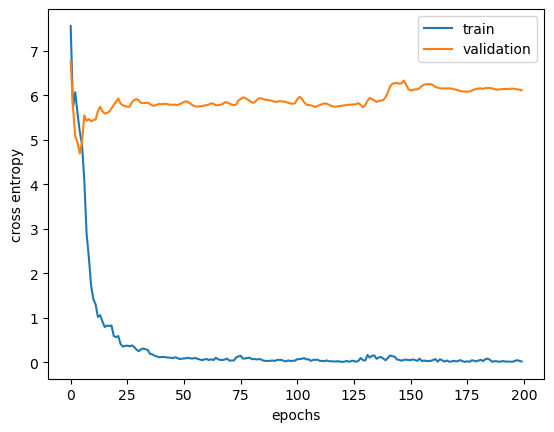

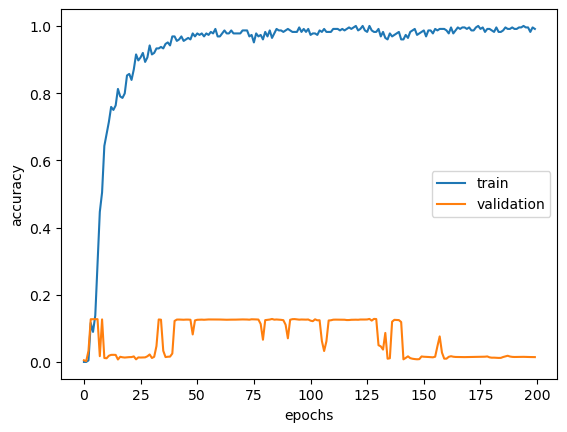

In [51]:
#Try training the data with other validations sets (left)
seq_val_data1 = AlignIO.read(os.path.join(sys.path[0],"Data/Replicates/Validation_extended_left.fasta"),"fasta")
seq_X_val1, seq_y_val1 = speciesDNA_encoder(seq_val_data1, species_id)

seq_model = CNNZ(seq_X_train, seq_y_train, 5) #Note : Apparently, the padding increase the accuracys
seq_test = CNN_train(seq_model, seq_X_train, seq_X_val1, seq_y_train, seq_y_val1, 32, 0.005, "cpu") #Remember that the data is already one shot encoded

Train the CNN with the right/left extension to see its performance.

In [22]:
#Train and validate the data with sequnces extended to the right
seq_train_data1 = AlignIO.read(os.path.join(sys.path[0],"Data/Replicates/General_alignment_extended_right.fasta"),"fasta")
seq_X_train1, seq_y_train1 = [], []
for record in seq_train_data1:
    seq_X_train1.append(DNAonehotencoder(str(record.seq))) # Do the one hot encoding
    bacteria = str(record.id).replace("_consensus_ext_R","").replace("_"," ")
    seq_y_train1.append(species_id[bacteria])

seq_X_train1 = np.array(seq_X_train1)
seq_y_train1 = np.array(seq_y_train1)

seq_val_data1 = AlignIO.read(os.path.join(sys.path[0],"Data/Replicates/Validation_extended_right.fasta"),"fasta")
seq_X_val1, seq_y_val1 = speciesDNA_encoder(seq_val_data1, species_id)

In [23]:
seq_X_train1.shape, seq_y_train1.shape

((224, 5, 2793), (224,))

torch.Size([224, 5, 2793])
batches_per_epoch 7


Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  6.05batch/s, acc=0, loss=9.52]


Epoch 0 validation: Cross-entropy=6.95, Accuracy=0.8%


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  5.90batch/s, acc=0, loss=5.8] 


Epoch 1 validation: Cross-entropy=5.91, Accuracy=0.1%


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  5.90batch/s, acc=0, loss=5.11]    


Epoch 2 validation: Cross-entropy=5.47, Accuracy=0.2%


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  5.91batch/s, acc=0, loss=5.96]


Epoch 3 validation: Cross-entropy=5.89, Accuracy=0.5%


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  5.93batch/s, acc=0.0625, loss=5]   


Epoch 4 validation: Cross-entropy=6.81, Accuracy=0.6%


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.781, loss=1.74]


Epoch 5 validation: Cross-entropy=8.12, Accuracy=0.8%


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.812, loss=0.606]


Epoch 6 validation: Cross-entropy=8.27, Accuracy=1.1%


Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  5.95batch/s, acc=0.875, loss=0.527]


Epoch 7 validation: Cross-entropy=8.50, Accuracy=0.6%


Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=0.844, loss=0.528]


Epoch 8 validation: Cross-entropy=8.79, Accuracy=0.7%


Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.844, loss=0.504]


Epoch 9 validation: Cross-entropy=9.40, Accuracy=0.5%


Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.875, loss=0.562]


Epoch 10 validation: Cross-entropy=9.65, Accuracy=0.4%


Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  5.84batch/s, acc=0.875, loss=0.343] 


Epoch 11 validation: Cross-entropy=9.61, Accuracy=0.9%


Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  5.94batch/s, acc=0.875, loss=0.588]


Epoch 12 validation: Cross-entropy=9.90, Accuracy=0.7%


Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  5.95batch/s, acc=0.906, loss=0.246] 


Epoch 13 validation: Cross-entropy=10.21, Accuracy=0.6%


Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  5.95batch/s, acc=0.906, loss=0.394]


Epoch 14 validation: Cross-entropy=10.41, Accuracy=0.5%


Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  5.94batch/s, acc=0.875, loss=0.323] 


Epoch 15 validation: Cross-entropy=10.53, Accuracy=0.6%


Epoch 16: 100%|██████████| 7/7 [00:01<00:00,  5.94batch/s, acc=0.906, loss=0.356] 


Epoch 16 validation: Cross-entropy=10.62, Accuracy=0.7%


Epoch 17: 100%|██████████| 7/7 [00:01<00:00,  5.94batch/s, acc=0.875, loss=0.383]


Epoch 17 validation: Cross-entropy=10.50, Accuracy=0.7%


Epoch 18: 100%|██████████| 7/7 [00:01<00:00,  5.94batch/s, acc=0.875, loss=0.535] 


Epoch 18 validation: Cross-entropy=10.44, Accuracy=0.5%


Epoch 19: 100%|██████████| 7/7 [00:01<00:00,  5.95batch/s, acc=0.906, loss=0.286] 


Epoch 19 validation: Cross-entropy=10.51, Accuracy=0.6%


Epoch 20: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.844, loss=0.292] 


Epoch 20 validation: Cross-entropy=10.60, Accuracy=0.6%


Epoch 21: 100%|██████████| 7/7 [00:01<00:00,  5.95batch/s, acc=0.906, loss=0.347] 


Epoch 21 validation: Cross-entropy=10.78, Accuracy=0.6%


Epoch 22: 100%|██████████| 7/7 [00:01<00:00,  5.95batch/s, acc=0.906, loss=0.352]


Epoch 22 validation: Cross-entropy=10.95, Accuracy=0.6%


Epoch 23: 100%|██████████| 7/7 [00:01<00:00,  5.94batch/s, acc=0.938, loss=0.338]


Epoch 23 validation: Cross-entropy=11.08, Accuracy=0.8%


Epoch 24: 100%|██████████| 7/7 [00:01<00:00,  5.94batch/s, acc=0.875, loss=0.357] 


Epoch 24 validation: Cross-entropy=10.68, Accuracy=0.9%


Epoch 25: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.844, loss=0.33] 


Epoch 25 validation: Cross-entropy=10.61, Accuracy=0.9%


Epoch 26: 100%|██████████| 7/7 [00:01<00:00,  5.95batch/s, acc=0.906, loss=0.329]


Epoch 26 validation: Cross-entropy=10.51, Accuracy=0.9%


Epoch 27: 100%|██████████| 7/7 [00:01<00:00,  5.95batch/s, acc=0.906, loss=0.312] 


Epoch 27 validation: Cross-entropy=10.57, Accuracy=0.5%


Epoch 28: 100%|██████████| 7/7 [00:01<00:00,  5.87batch/s, acc=0.906, loss=0.263] 


Epoch 28 validation: Cross-entropy=10.40, Accuracy=0.5%


Epoch 29: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.875, loss=0.319]


Epoch 29 validation: Cross-entropy=10.46, Accuracy=0.5%


Epoch 30: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.875, loss=0.265]


Epoch 30 validation: Cross-entropy=10.30, Accuracy=0.6%


Epoch 31: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=0.875, loss=0.294]


Epoch 31 validation: Cross-entropy=10.35, Accuracy=0.5%


Epoch 32: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.938, loss=0.19] 


Epoch 32 validation: Cross-entropy=10.43, Accuracy=0.6%


Epoch 33: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.906, loss=0.252] 


Epoch 33 validation: Cross-entropy=10.68, Accuracy=0.6%


Epoch 34: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.875, loss=0.316] 


Epoch 34 validation: Cross-entropy=10.52, Accuracy=0.6%


Epoch 35: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.906, loss=0.332]


Epoch 35 validation: Cross-entropy=10.50, Accuracy=0.6%


Epoch 36: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=0.906, loss=0.241]


Epoch 36 validation: Cross-entropy=10.67, Accuracy=0.6%


Epoch 37: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=0.875, loss=0.423]


Epoch 37 validation: Cross-entropy=10.49, Accuracy=0.6%


Epoch 38: 100%|██████████| 7/7 [00:01<00:00,  5.98batch/s, acc=0.906, loss=0.233]


Epoch 38 validation: Cross-entropy=10.83, Accuracy=0.6%


Epoch 39: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.906, loss=0.236]


Epoch 39 validation: Cross-entropy=10.20, Accuracy=0.7%


Epoch 40: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.0575]   


Epoch 40 validation: Cross-entropy=10.38, Accuracy=0.6%


Epoch 41: 100%|██████████| 7/7 [00:01<00:00,  5.95batch/s, acc=0.969, loss=0.0618]


Epoch 41 validation: Cross-entropy=10.43, Accuracy=0.6%


Epoch 42: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=1, loss=0.0461]   


Epoch 42 validation: Cross-entropy=10.35, Accuracy=0.8%


Epoch 43: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=0.969, loss=0.0897]


Epoch 43 validation: Cross-entropy=10.26, Accuracy=0.7%


Epoch 44: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.969, loss=0.156] 


Epoch 44 validation: Cross-entropy=10.75, Accuracy=0.6%


Epoch 45: 100%|██████████| 7/7 [00:01<00:00,  5.93batch/s, acc=1, loss=0.0274]   


Epoch 45 validation: Cross-entropy=10.77, Accuracy=0.7%


Epoch 46: 100%|██████████| 7/7 [00:01<00:00,  5.93batch/s, acc=0.969, loss=0.0521]


Epoch 46 validation: Cross-entropy=10.96, Accuracy=0.6%


Epoch 47: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.016]     


Epoch 47 validation: Cross-entropy=10.45, Accuracy=0.7%


Epoch 48: 100%|██████████| 7/7 [00:01<00:00,  5.92batch/s, acc=1, loss=0.00807]  


Epoch 48 validation: Cross-entropy=10.54, Accuracy=0.8%


Epoch 49: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.013]     


Epoch 49 validation: Cross-entropy=10.59, Accuracy=0.6%


Epoch 50: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.0116]    


Epoch 50 validation: Cross-entropy=10.64, Accuracy=0.7%


Epoch 51: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.00792]   


Epoch 51 validation: Cross-entropy=10.64, Accuracy=0.7%


Epoch 52: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.00689]


Epoch 52 validation: Cross-entropy=10.73, Accuracy=0.7%


Epoch 53: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=1, loss=0.00626]   


Epoch 53 validation: Cross-entropy=10.88, Accuracy=0.7%


Epoch 54: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.00247]   


Epoch 54 validation: Cross-entropy=10.98, Accuracy=0.6%


Epoch 55: 100%|██████████| 7/7 [00:01<00:00,  5.94batch/s, acc=1, loss=0.0204]   


Epoch 55 validation: Cross-entropy=10.80, Accuracy=0.7%


Epoch 56: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=0.969, loss=0.0781]


Epoch 56 validation: Cross-entropy=10.64, Accuracy=1.0%


Epoch 57: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.969, loss=0.148]


Epoch 57 validation: Cross-entropy=11.10, Accuracy=0.9%


Epoch 58: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=1, loss=0.00216]   


Epoch 58 validation: Cross-entropy=10.50, Accuracy=1.0%


Epoch 59: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.00141]   


Epoch 59 validation: Cross-entropy=10.65, Accuracy=1.0%


Epoch 60: 100%|██████████| 7/7 [00:01<00:00,  5.77batch/s, acc=1, loss=0.0123]   


Epoch 60 validation: Cross-entropy=10.73, Accuracy=0.9%


Epoch 61: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=1, loss=0.00636]  


Epoch 61 validation: Cross-entropy=10.64, Accuracy=0.9%


Epoch 62: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.00106]  


Epoch 62 validation: Cross-entropy=10.62, Accuracy=0.9%


Epoch 63: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.00485]   


Epoch 63 validation: Cross-entropy=10.63, Accuracy=0.9%


Epoch 64: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.000805] 


Epoch 64 validation: Cross-entropy=10.56, Accuracy=0.9%


Epoch 65: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=1, loss=0.000822] 


Epoch 65 validation: Cross-entropy=10.53, Accuracy=0.9%


Epoch 66: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=1, loss=0.00256]  


Epoch 66 validation: Cross-entropy=10.49, Accuracy=1.0%


Epoch 67: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.000979] 


Epoch 67 validation: Cross-entropy=10.51, Accuracy=1.0%


Epoch 68: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.00195]  


Epoch 68 validation: Cross-entropy=10.50, Accuracy=0.9%


Epoch 69: 100%|██████████| 7/7 [00:01<00:00,  5.98batch/s, acc=1, loss=0.00493]   


Epoch 69 validation: Cross-entropy=10.57, Accuracy=0.9%


Epoch 70: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=1, loss=0.00183]   


Epoch 70 validation: Cross-entropy=10.77, Accuracy=1.0%


Epoch 71: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.00187]  


Epoch 71 validation: Cross-entropy=10.81, Accuracy=1.0%


Epoch 72: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.00361]   


Epoch 72 validation: Cross-entropy=10.61, Accuracy=1.0%


Epoch 73: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=1, loss=0.00502]  


Epoch 73 validation: Cross-entropy=10.72, Accuracy=1.0%


Epoch 74: 100%|██████████| 7/7 [00:01<00:00,  5.95batch/s, acc=1, loss=0.0146]   


Epoch 74 validation: Cross-entropy=10.43, Accuracy=1.0%


Epoch 75: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.969, loss=0.043] 


Epoch 75 validation: Cross-entropy=10.74, Accuracy=1.0%


Epoch 76: 100%|██████████| 7/7 [00:01<00:00,  5.77batch/s, acc=0.906, loss=0.568] 


Epoch 76 validation: Cross-entropy=10.91, Accuracy=0.9%


Epoch 77: 100%|██████████| 7/7 [00:01<00:00,  5.86batch/s, acc=0.938, loss=0.275]


Epoch 77 validation: Cross-entropy=10.93, Accuracy=0.8%


Epoch 78: 100%|██████████| 7/7 [00:01<00:00,  5.69batch/s, acc=0.969, loss=0.0592]


Epoch 78 validation: Cross-entropy=10.23, Accuracy=0.7%


Epoch 79: 100%|██████████| 7/7 [00:01<00:00,  5.95batch/s, acc=1, loss=0.0103]   


Epoch 79 validation: Cross-entropy=10.24, Accuracy=0.9%


Epoch 80: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=1, loss=0.00165]  


Epoch 80 validation: Cross-entropy=10.32, Accuracy=0.9%


Epoch 81: 100%|██████████| 7/7 [00:01<00:00,  5.81batch/s, acc=1, loss=0.00395]  


Epoch 81 validation: Cross-entropy=10.38, Accuracy=0.9%


Epoch 82: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.00191]  


Epoch 82 validation: Cross-entropy=10.30, Accuracy=1.0%


Epoch 83: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=1, loss=0.00155]  


Epoch 83 validation: Cross-entropy=10.11, Accuracy=1.0%


Epoch 84: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.00769]  


Epoch 84 validation: Cross-entropy=10.14, Accuracy=1.0%


Epoch 85: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.00105] 


Epoch 85 validation: Cross-entropy=10.38, Accuracy=1.0%


Epoch 86: 100%|██████████| 7/7 [00:01<00:00,  5.88batch/s, acc=1, loss=0.014]     


Epoch 86 validation: Cross-entropy=10.51, Accuracy=1.0%


Epoch 87: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=1, loss=0.00188]   


Epoch 87 validation: Cross-entropy=10.60, Accuracy=1.0%


Epoch 88: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=1, loss=0.0035]  


Epoch 88 validation: Cross-entropy=10.76, Accuracy=1.0%


Epoch 89: 100%|██████████| 7/7 [00:01<00:00,  5.95batch/s, acc=1, loss=0.00167]   


Epoch 89 validation: Cross-entropy=10.76, Accuracy=1.0%


Epoch 90: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=1, loss=0.0098]    


Epoch 90 validation: Cross-entropy=10.39, Accuracy=1.0%


Epoch 91: 100%|██████████| 7/7 [00:01<00:00,  5.79batch/s, acc=1, loss=0.000709]  


Epoch 91 validation: Cross-entropy=10.23, Accuracy=0.9%


Epoch 92: 100%|██████████| 7/7 [00:01<00:00,  5.82batch/s, acc=1, loss=0.00105]  


Epoch 92 validation: Cross-entropy=10.30, Accuracy=0.9%


Epoch 93: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=1, loss=0.00508]   


Epoch 93 validation: Cross-entropy=10.20, Accuracy=0.9%


Epoch 94: 100%|██████████| 7/7 [00:01<00:00,  5.94batch/s, acc=1, loss=0.00471]  


Epoch 94 validation: Cross-entropy=10.53, Accuracy=0.9%


Epoch 95: 100%|██████████| 7/7 [00:01<00:00,  5.87batch/s, acc=1, loss=0.000744]  


Epoch 95 validation: Cross-entropy=10.74, Accuracy=0.9%


Epoch 96: 100%|██████████| 7/7 [00:01<00:00,  5.91batch/s, acc=1, loss=0.000433]


Epoch 96 validation: Cross-entropy=10.75, Accuracy=0.9%


Epoch 97: 100%|██████████| 7/7 [00:01<00:00,  5.85batch/s, acc=1, loss=0.00219]   


Epoch 97 validation: Cross-entropy=10.82, Accuracy=0.9%


Epoch 98: 100%|██████████| 7/7 [00:01<00:00,  5.61batch/s, acc=1, loss=0.000369]  


Epoch 98 validation: Cross-entropy=10.89, Accuracy=1.0%


Epoch 99: 100%|██████████| 7/7 [00:01<00:00,  5.60batch/s, acc=1, loss=0.000444] 


Epoch 99 validation: Cross-entropy=10.95, Accuracy=0.9%


Epoch 100: 100%|██████████| 7/7 [00:01<00:00,  5.46batch/s, acc=1, loss=0.000589]


Epoch 100 validation: Cross-entropy=10.74, Accuracy=0.9%


Epoch 101: 100%|██████████| 7/7 [00:01<00:00,  5.31batch/s, acc=1, loss=0.000582] 


Epoch 101 validation: Cross-entropy=10.61, Accuracy=1.0%


Epoch 102: 100%|██████████| 7/7 [00:01<00:00,  5.26batch/s, acc=1, loss=0.000528]  


Epoch 102 validation: Cross-entropy=10.50, Accuracy=1.0%


Epoch 103: 100%|██████████| 7/7 [00:01<00:00,  5.24batch/s, acc=1, loss=0.00129] 


Epoch 103 validation: Cross-entropy=10.43, Accuracy=1.0%


Epoch 104: 100%|██████████| 7/7 [00:01<00:00,  5.19batch/s, acc=1, loss=0.000804]


Epoch 104 validation: Cross-entropy=10.53, Accuracy=1.0%


Epoch 105: 100%|██████████| 7/7 [00:01<00:00,  5.21batch/s, acc=1, loss=0.000427]


Epoch 105 validation: Cross-entropy=10.60, Accuracy=1.0%


Epoch 106: 100%|██████████| 7/7 [00:01<00:00,  5.19batch/s, acc=1, loss=0.000925]


Epoch 106 validation: Cross-entropy=10.66, Accuracy=1.0%


Epoch 107: 100%|██████████| 7/7 [00:01<00:00,  5.02batch/s, acc=1, loss=0.00038] 


Epoch 107 validation: Cross-entropy=10.61, Accuracy=0.9%


Epoch 108: 100%|██████████| 7/7 [00:01<00:00,  5.06batch/s, acc=1, loss=0.000382]  


Epoch 108 validation: Cross-entropy=10.56, Accuracy=1.0%


Epoch 109: 100%|██████████| 7/7 [00:01<00:00,  5.08batch/s, acc=1, loss=0.00081] 


Epoch 109 validation: Cross-entropy=10.60, Accuracy=1.0%


Epoch 110: 100%|██████████| 7/7 [00:01<00:00,  5.06batch/s, acc=1, loss=0.000422]  


Epoch 110 validation: Cross-entropy=10.64, Accuracy=0.9%


Epoch 111: 100%|██████████| 7/7 [00:01<00:00,  5.05batch/s, acc=1, loss=0.00141] 


Epoch 111 validation: Cross-entropy=10.67, Accuracy=0.9%


Epoch 112: 100%|██████████| 7/7 [00:01<00:00,  5.06batch/s, acc=1, loss=0.000465]


Epoch 112 validation: Cross-entropy=10.82, Accuracy=0.9%


Epoch 113: 100%|██████████| 7/7 [00:01<00:00,  5.04batch/s, acc=1, loss=0.00875] 


Epoch 113 validation: Cross-entropy=10.82, Accuracy=0.9%


Epoch 114: 100%|██████████| 7/7 [00:01<00:00,  5.02batch/s, acc=0.969, loss=0.0303]


Epoch 114 validation: Cross-entropy=10.68, Accuracy=0.9%


Epoch 115: 100%|██████████| 7/7 [00:01<00:00,  5.02batch/s, acc=0.969, loss=0.0253]


Epoch 115 validation: Cross-entropy=11.62, Accuracy=1.0%


Epoch 116: 100%|██████████| 7/7 [00:01<00:00,  5.01batch/s, acc=1, loss=0.00186] 


Epoch 116 validation: Cross-entropy=10.97, Accuracy=1.0%


Epoch 117: 100%|██████████| 7/7 [00:01<00:00,  5.00batch/s, acc=1, loss=0.000662]


Epoch 117 validation: Cross-entropy=10.87, Accuracy=1.0%


Epoch 118: 100%|██████████| 7/7 [00:01<00:00,  5.00batch/s, acc=0.969, loss=0.0663]


Epoch 118 validation: Cross-entropy=10.74, Accuracy=1.0%


Epoch 119: 100%|██████████| 7/7 [00:01<00:00,  5.01batch/s, acc=1, loss=0.00919] 


Epoch 119 validation: Cross-entropy=11.41, Accuracy=0.9%


Epoch 120: 100%|██████████| 7/7 [00:01<00:00,  5.00batch/s, acc=0.969, loss=0.147] 


Epoch 120 validation: Cross-entropy=10.98, Accuracy=0.9%


Epoch 121: 100%|██████████| 7/7 [00:01<00:00,  5.00batch/s, acc=0.969, loss=0.0822]


Epoch 121 validation: Cross-entropy=10.58, Accuracy=0.9%


Epoch 122: 100%|██████████| 7/7 [00:01<00:00,  5.06batch/s, acc=1, loss=0.0131]  


Epoch 122 validation: Cross-entropy=10.36, Accuracy=0.9%


Epoch 123: 100%|██████████| 7/7 [00:01<00:00,  5.04batch/s, acc=1, loss=0.0109]  


Epoch 123 validation: Cross-entropy=10.40, Accuracy=1.0%


Epoch 124: 100%|██████████| 7/7 [00:01<00:00,  5.12batch/s, acc=1, loss=0.00076] 


Epoch 124 validation: Cross-entropy=10.53, Accuracy=1.0%


Epoch 125: 100%|██████████| 7/7 [00:01<00:00,  5.21batch/s, acc=1, loss=0.00571] 


Epoch 125 validation: Cross-entropy=10.58, Accuracy=1.0%


Epoch 126: 100%|██████████| 7/7 [00:01<00:00,  5.26batch/s, acc=1, loss=0.000542]


Epoch 126 validation: Cross-entropy=10.46, Accuracy=1.0%


Epoch 127: 100%|██████████| 7/7 [00:01<00:00,  5.27batch/s, acc=1, loss=0.00219] 


Epoch 127 validation: Cross-entropy=10.45, Accuracy=1.0%


Epoch 128: 100%|██████████| 7/7 [00:01<00:00,  5.23batch/s, acc=1, loss=0.000456]


Epoch 128 validation: Cross-entropy=10.53, Accuracy=1.0%


Epoch 129: 100%|██████████| 7/7 [00:01<00:00,  5.23batch/s, acc=1, loss=0.000348]  


Epoch 129 validation: Cross-entropy=10.54, Accuracy=1.0%


Epoch 130: 100%|██████████| 7/7 [00:01<00:00,  5.20batch/s, acc=1, loss=0.0026]  


Epoch 130 validation: Cross-entropy=10.57, Accuracy=1.0%


Epoch 131: 100%|██████████| 7/7 [00:01<00:00,  5.18batch/s, acc=1, loss=0.00193] 


Epoch 131 validation: Cross-entropy=10.56, Accuracy=1.0%


Epoch 132: 100%|██████████| 7/7 [00:01<00:00,  5.15batch/s, acc=1, loss=0.000783]


Epoch 132 validation: Cross-entropy=10.70, Accuracy=1.0%


Epoch 133: 100%|██████████| 7/7 [00:01<00:00,  5.14batch/s, acc=1, loss=0.00114]  


Epoch 133 validation: Cross-entropy=10.75, Accuracy=1.0%


Epoch 134: 100%|██████████| 7/7 [00:01<00:00,  5.02batch/s, acc=1, loss=0.000549]  


Epoch 134 validation: Cross-entropy=10.84, Accuracy=1.0%


Epoch 135: 100%|██████████| 7/7 [00:01<00:00,  5.12batch/s, acc=1, loss=0.00101]   


Epoch 135 validation: Cross-entropy=10.97, Accuracy=1.0%


Epoch 136: 100%|██████████| 7/7 [00:01<00:00,  5.10batch/s, acc=1, loss=0.0017]    


Epoch 136 validation: Cross-entropy=11.06, Accuracy=1.0%


Epoch 137: 100%|██████████| 7/7 [00:01<00:00,  5.08batch/s, acc=1, loss=0.000304]


Epoch 137 validation: Cross-entropy=11.08, Accuracy=1.0%


Epoch 138: 100%|██████████| 7/7 [00:01<00:00,  5.08batch/s, acc=1, loss=0.00102]   


Epoch 138 validation: Cross-entropy=10.96, Accuracy=1.0%


Epoch 139: 100%|██████████| 7/7 [00:01<00:00,  5.06batch/s, acc=1, loss=0.00875]  


Epoch 139 validation: Cross-entropy=10.53, Accuracy=1.0%


Epoch 140: 100%|██████████| 7/7 [00:01<00:00,  5.01batch/s, acc=1, loss=0.0012]    


Epoch 140 validation: Cross-entropy=10.23, Accuracy=0.9%


Epoch 141: 100%|██████████| 7/7 [00:01<00:00,  4.89batch/s, acc=0.969, loss=0.164] 


Epoch 141 validation: Cross-entropy=10.92, Accuracy=0.9%


Epoch 142: 100%|██████████| 7/7 [00:01<00:00,  5.05batch/s, acc=0.969, loss=0.12]


Epoch 142 validation: Cross-entropy=12.10, Accuracy=0.9%


Epoch 143: 100%|██████████| 7/7 [00:01<00:00,  5.03batch/s, acc=1, loss=0.0181]  


Epoch 143 validation: Cross-entropy=12.03, Accuracy=0.9%


Epoch 144: 100%|██████████| 7/7 [00:01<00:00,  5.03batch/s, acc=1, loss=0.0306]  


Epoch 144 validation: Cross-entropy=12.24, Accuracy=0.9%


Epoch 145: 100%|██████████| 7/7 [00:01<00:00,  4.97batch/s, acc=1, loss=0.00129]   


Epoch 145 validation: Cross-entropy=11.59, Accuracy=0.9%


Epoch 146: 100%|██████████| 7/7 [00:01<00:00,  4.99batch/s, acc=1, loss=0.00149]   


Epoch 146 validation: Cross-entropy=11.82, Accuracy=0.9%


Epoch 147: 100%|██████████| 7/7 [00:01<00:00,  5.05batch/s, acc=1, loss=0.0188]    


Epoch 147 validation: Cross-entropy=11.48, Accuracy=0.9%


Epoch 148: 100%|██████████| 7/7 [00:01<00:00,  5.06batch/s, acc=1, loss=0.000326] 


Epoch 148 validation: Cross-entropy=10.95, Accuracy=1.0%


Epoch 149: 100%|██████████| 7/7 [00:01<00:00,  5.06batch/s, acc=1, loss=0.0142]  


Epoch 149 validation: Cross-entropy=11.16, Accuracy=0.9%


Epoch 150: 100%|██████████| 7/7 [00:01<00:00,  5.09batch/s, acc=1, loss=0.000394]


Epoch 150 validation: Cross-entropy=10.78, Accuracy=1.0%


Epoch 151: 100%|██████████| 7/7 [00:01<00:00,  5.10batch/s, acc=1, loss=0.00133] 


Epoch 151 validation: Cross-entropy=10.87, Accuracy=1.0%


Epoch 152: 100%|██████████| 7/7 [00:01<00:00,  5.11batch/s, acc=1, loss=0.000459]


Epoch 152 validation: Cross-entropy=10.78, Accuracy=1.1%


Epoch 153: 100%|██████████| 7/7 [00:01<00:00,  5.11batch/s, acc=1, loss=0.000517]


Epoch 153 validation: Cross-entropy=10.76, Accuracy=1.1%


Epoch 154: 100%|██████████| 7/7 [00:01<00:00,  5.13batch/s, acc=1, loss=0.0206]   


Epoch 154 validation: Cross-entropy=11.00, Accuracy=1.0%


Epoch 155: 100%|██████████| 7/7 [00:01<00:00,  5.11batch/s, acc=0.969, loss=0.0383]


Epoch 155 validation: Cross-entropy=11.80, Accuracy=0.9%


Epoch 156: 100%|██████████| 7/7 [00:01<00:00,  5.11batch/s, acc=1, loss=0.000494]


Epoch 156 validation: Cross-entropy=11.00, Accuracy=0.9%


Epoch 157: 100%|██████████| 7/7 [00:01<00:00,  5.08batch/s, acc=1, loss=0.000481]


Epoch 157 validation: Cross-entropy=10.78, Accuracy=0.9%


Epoch 158: 100%|██████████| 7/7 [00:01<00:00,  5.07batch/s, acc=1, loss=0.00332] 


Epoch 158 validation: Cross-entropy=10.70, Accuracy=0.9%


Epoch 159: 100%|██████████| 7/7 [00:01<00:00,  5.08batch/s, acc=1, loss=0.000903]


Epoch 159 validation: Cross-entropy=10.71, Accuracy=0.9%


Epoch 160: 100%|██████████| 7/7 [00:01<00:00,  5.06batch/s, acc=1, loss=0.00053]   


Epoch 160 validation: Cross-entropy=10.88, Accuracy=0.7%


Epoch 161: 100%|██████████| 7/7 [00:01<00:00,  5.06batch/s, acc=1, loss=0.00128]   


Epoch 161 validation: Cross-entropy=11.04, Accuracy=0.6%


Epoch 162: 100%|██████████| 7/7 [00:01<00:00,  5.07batch/s, acc=1, loss=0.00271] 


Epoch 162 validation: Cross-entropy=10.74, Accuracy=0.9%


Epoch 163: 100%|██████████| 7/7 [00:01<00:00,  5.06batch/s, acc=1, loss=0.00192] 


Epoch 163 validation: Cross-entropy=10.92, Accuracy=0.9%


Epoch 164: 100%|██████████| 7/7 [00:01<00:00,  5.07batch/s, acc=1, loss=0.000448]


Epoch 164 validation: Cross-entropy=11.13, Accuracy=0.9%


Epoch 165: 100%|██████████| 7/7 [00:01<00:00,  5.05batch/s, acc=1, loss=0.000392]  


Epoch 165 validation: Cross-entropy=11.40, Accuracy=0.9%


Epoch 166: 100%|██████████| 7/7 [00:01<00:00,  5.05batch/s, acc=1, loss=0.000377]  


Epoch 166 validation: Cross-entropy=11.45, Accuracy=0.9%


Epoch 167: 100%|██████████| 7/7 [00:01<00:00,  5.06batch/s, acc=1, loss=0.00295] 


Epoch 167 validation: Cross-entropy=11.56, Accuracy=0.9%


Epoch 168: 100%|██████████| 7/7 [00:01<00:00,  5.05batch/s, acc=1, loss=0.000596]


Epoch 168 validation: Cross-entropy=11.84, Accuracy=0.9%


Epoch 169: 100%|██████████| 7/7 [00:01<00:00,  5.05batch/s, acc=1, loss=0.000151]


Epoch 169 validation: Cross-entropy=11.93, Accuracy=0.9%


Epoch 170: 100%|██████████| 7/7 [00:01<00:00,  5.05batch/s, acc=1, loss=0.000239]


Epoch 170 validation: Cross-entropy=11.97, Accuracy=0.9%


Epoch 171: 100%|██████████| 7/7 [00:01<00:00,  4.89batch/s, acc=1, loss=0.000266]  


Epoch 171 validation: Cross-entropy=11.87, Accuracy=0.9%


Epoch 172: 100%|██████████| 7/7 [00:01<00:00,  5.03batch/s, acc=1, loss=0.000214] 


Epoch 172 validation: Cross-entropy=11.80, Accuracy=0.9%


Epoch 173: 100%|██████████| 7/7 [00:01<00:00,  5.03batch/s, acc=0.969, loss=0.035] 


Epoch 173 validation: Cross-entropy=11.51, Accuracy=0.9%


Epoch 174: 100%|██████████| 7/7 [00:01<00:00,  5.03batch/s, acc=0.938, loss=0.0946]


Epoch 174 validation: Cross-entropy=12.49, Accuracy=0.9%


Epoch 175: 100%|██████████| 7/7 [00:01<00:00,  5.03batch/s, acc=1, loss=0.00487] 


Epoch 175 validation: Cross-entropy=11.77, Accuracy=0.9%


Epoch 176: 100%|██████████| 7/7 [00:01<00:00,  5.05batch/s, acc=0.969, loss=0.0418]


Epoch 176 validation: Cross-entropy=11.77, Accuracy=0.9%


Epoch 177: 100%|██████████| 7/7 [00:01<00:00,  5.04batch/s, acc=1, loss=0.00102] 


Epoch 177 validation: Cross-entropy=11.54, Accuracy=0.9%


Epoch 178: 100%|██████████| 7/7 [00:01<00:00,  5.05batch/s, acc=1, loss=0.0121]  


Epoch 178 validation: Cross-entropy=11.46, Accuracy=0.9%


Epoch 179: 100%|██████████| 7/7 [00:01<00:00,  5.04batch/s, acc=1, loss=0.000549]


Epoch 179 validation: Cross-entropy=11.58, Accuracy=0.9%


Epoch 180: 100%|██████████| 7/7 [00:01<00:00,  4.85batch/s, acc=1, loss=0.000381]


Epoch 180 validation: Cross-entropy=11.67, Accuracy=0.9%


Epoch 181: 100%|██████████| 7/7 [00:01<00:00,  4.99batch/s, acc=1, loss=0.000966]


Epoch 181 validation: Cross-entropy=11.82, Accuracy=0.9%


Epoch 182: 100%|██████████| 7/7 [00:01<00:00,  5.07batch/s, acc=1, loss=0.000148]


Epoch 182 validation: Cross-entropy=11.97, Accuracy=0.9%


Epoch 183: 100%|██████████| 7/7 [00:01<00:00,  5.07batch/s, acc=1, loss=0.000232]  


Epoch 183 validation: Cross-entropy=12.05, Accuracy=0.9%


Epoch 184: 100%|██████████| 7/7 [00:01<00:00,  5.08batch/s, acc=1, loss=0.000255] 


Epoch 184 validation: Cross-entropy=12.04, Accuracy=0.9%


Epoch 185: 100%|██████████| 7/7 [00:01<00:00,  5.09batch/s, acc=1, loss=0.00048] 


Epoch 185 validation: Cross-entropy=12.00, Accuracy=0.9%


Epoch 186: 100%|██████████| 7/7 [00:01<00:00,  5.10batch/s, acc=1, loss=0.000168]


Epoch 186 validation: Cross-entropy=11.98, Accuracy=0.9%


Epoch 187: 100%|██████████| 7/7 [00:01<00:00,  5.12batch/s, acc=1, loss=0.00109] 


Epoch 187 validation: Cross-entropy=12.08, Accuracy=0.9%


Epoch 188: 100%|██████████| 7/7 [00:01<00:00,  5.14batch/s, acc=1, loss=0.000197]


Epoch 188 validation: Cross-entropy=12.15, Accuracy=0.9%


Epoch 189: 100%|██████████| 7/7 [00:01<00:00,  5.14batch/s, acc=1, loss=0.000169]


Epoch 189 validation: Cross-entropy=12.19, Accuracy=0.9%


Epoch 190: 100%|██████████| 7/7 [00:01<00:00,  5.13batch/s, acc=1, loss=0.000351]


Epoch 190 validation: Cross-entropy=12.21, Accuracy=0.9%


Epoch 191: 100%|██████████| 7/7 [00:01<00:00,  5.15batch/s, acc=1, loss=0.00017]  


Epoch 191 validation: Cross-entropy=12.26, Accuracy=0.9%


Epoch 192: 100%|██████████| 7/7 [00:01<00:00,  5.15batch/s, acc=1, loss=0.000325]


Epoch 192 validation: Cross-entropy=12.36, Accuracy=0.9%


Epoch 193: 100%|██████████| 7/7 [00:01<00:00,  5.16batch/s, acc=1, loss=0.000337] 


Epoch 193 validation: Cross-entropy=12.39, Accuracy=0.9%


Epoch 194: 100%|██████████| 7/7 [00:01<00:00,  5.14batch/s, acc=1, loss=0.000488]


Epoch 194 validation: Cross-entropy=12.40, Accuracy=0.9%


Epoch 195: 100%|██████████| 7/7 [00:01<00:00,  5.16batch/s, acc=1, loss=0.000108]


Epoch 195 validation: Cross-entropy=12.38, Accuracy=0.9%


Epoch 196: 100%|██████████| 7/7 [00:01<00:00,  5.17batch/s, acc=1, loss=0.000258]  


Epoch 196 validation: Cross-entropy=12.39, Accuracy=0.9%


Epoch 197: 100%|██████████| 7/7 [00:01<00:00,  5.17batch/s, acc=1, loss=0.0019]  


Epoch 197 validation: Cross-entropy=12.40, Accuracy=0.9%


Epoch 198: 100%|██████████| 7/7 [00:01<00:00,  5.12batch/s, acc=1, loss=0.00022] 


Epoch 198 validation: Cross-entropy=12.31, Accuracy=0.9%


Epoch 199: 100%|██████████| 7/7 [00:01<00:00,  5.05batch/s, acc=1, loss=0.000535]


Epoch 199 validation: Cross-entropy=12.28, Accuracy=0.9%


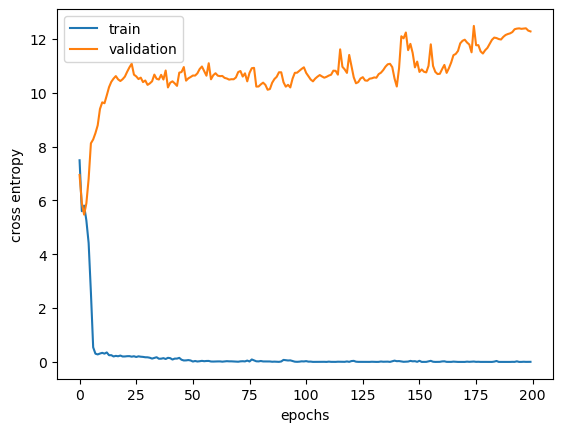

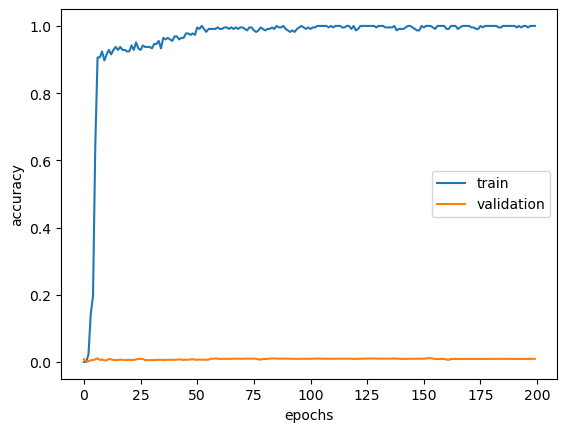

In [24]:
seq_model1 = CNNZ(seq_X_train1, seq_y_train1, 5) #Note : Apparently, the padding increase the accuracys
seq_test = CNN_train(seq_model1, seq_X_train1, seq_X_val1, seq_y_train, seq_y_val1, 32, 0.005, "cpu") #Remember that the data is already one shot encoded

torch.Size([224, 5, 2793])
batches_per_epoch 7


Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  6.69batch/s, acc=0, loss=9.67]


Epoch 0 validation: Cross-entropy=6.96, Accuracy=0.1%


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  6.08batch/s, acc=0, loss=5.71]


Epoch 1 validation: Cross-entropy=5.93, Accuracy=2.1%


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  5.75batch/s, acc=0, loss=5.09]    


Epoch 2 validation: Cross-entropy=5.53, Accuracy=0.2%


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  5.99batch/s, acc=0, loss=5.84]     


Epoch 3 validation: Cross-entropy=5.82, Accuracy=0.5%


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  6.00batch/s, acc=0, loss=4.85]     


Epoch 4 validation: Cross-entropy=7.17, Accuracy=0.3%


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  6.00batch/s, acc=0.688, loss=2.67] 


Epoch 5 validation: Cross-entropy=7.06, Accuracy=0.8%


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  6.01batch/s, acc=0.844, loss=0.522]


Epoch 6 validation: Cross-entropy=7.53, Accuracy=0.7%


Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  6.00batch/s, acc=0.812, loss=0.48]  


Epoch 7 validation: Cross-entropy=8.30, Accuracy=0.7%


Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  5.88batch/s, acc=0.844, loss=0.638]


Epoch 8 validation: Cross-entropy=9.02, Accuracy=0.3%


Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  6.01batch/s, acc=0.875, loss=0.367]


Epoch 9 validation: Cross-entropy=9.21, Accuracy=0.8%


Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  6.01batch/s, acc=0.875, loss=0.709] 


Epoch 10 validation: Cross-entropy=9.30, Accuracy=0.8%


Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  6.00batch/s, acc=0.844, loss=0.482] 


Epoch 11 validation: Cross-entropy=9.49, Accuracy=0.6%


Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  5.84batch/s, acc=0.844, loss=0.576] 


Epoch 12 validation: Cross-entropy=9.66, Accuracy=0.5%


Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  4.99batch/s, acc=0.844, loss=0.429] 


Epoch 13 validation: Cross-entropy=9.91, Accuracy=0.9%


Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  5.29batch/s, acc=0.844, loss=0.458]


Epoch 14 validation: Cross-entropy=9.91, Accuracy=0.8%


Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  5.91batch/s, acc=0.844, loss=0.614] 


Epoch 15 validation: Cross-entropy=9.90, Accuracy=0.6%


Epoch 16: 100%|██████████| 7/7 [00:01<00:00,  6.00batch/s, acc=0.844, loss=0.431] 


Epoch 16 validation: Cross-entropy=9.67, Accuracy=0.6%


Epoch 17: 100%|██████████| 7/7 [00:01<00:00,  5.91batch/s, acc=0.844, loss=0.344] 


Epoch 17 validation: Cross-entropy=9.40, Accuracy=0.6%


Epoch 18: 100%|██████████| 7/7 [00:01<00:00,  5.89batch/s, acc=0.875, loss=0.381] 


Epoch 18 validation: Cross-entropy=9.49, Accuracy=0.6%


Epoch 19: 100%|██████████| 7/7 [00:01<00:00,  6.01batch/s, acc=0.875, loss=0.346] 


Epoch 19 validation: Cross-entropy=9.37, Accuracy=0.6%


Epoch 20: 100%|██████████| 7/7 [00:01<00:00,  5.84batch/s, acc=0.906, loss=0.248]


Epoch 20 validation: Cross-entropy=8.13, Accuracy=1.1%


Epoch 21: 100%|██████████| 7/7 [00:01<00:00,  6.01batch/s, acc=0.875, loss=0.336]


Epoch 21 validation: Cross-entropy=9.65, Accuracy=0.5%


Epoch 22: 100%|██████████| 7/7 [00:01<00:00,  4.78batch/s, acc=0.875, loss=0.3]  


Epoch 22 validation: Cross-entropy=9.80, Accuracy=0.6%


Epoch 23: 100%|██████████| 7/7 [00:01<00:00,  5.76batch/s, acc=0.875, loss=0.335] 


Epoch 23 validation: Cross-entropy=9.83, Accuracy=0.5%


Epoch 24: 100%|██████████| 7/7 [00:01<00:00,  6.01batch/s, acc=0.938, loss=0.18]  


Epoch 24 validation: Cross-entropy=9.80, Accuracy=0.5%


Epoch 25: 100%|██████████| 7/7 [00:01<00:00,  6.01batch/s, acc=0.875, loss=0.197] 


Epoch 25 validation: Cross-entropy=9.73, Accuracy=0.6%


Epoch 26: 100%|██████████| 7/7 [00:01<00:00,  5.91batch/s, acc=0.906, loss=0.222]


Epoch 26 validation: Cross-entropy=10.04, Accuracy=0.6%


Epoch 27: 100%|██████████| 7/7 [00:01<00:00,  4.77batch/s, acc=0.875, loss=0.33]  


Epoch 27 validation: Cross-entropy=10.01, Accuracy=0.6%


Epoch 28: 100%|██████████| 7/7 [00:01<00:00,  5.53batch/s, acc=0.875, loss=0.239]


Epoch 28 validation: Cross-entropy=10.07, Accuracy=0.6%


Epoch 29: 100%|██████████| 7/7 [00:01<00:00,  5.63batch/s, acc=0.969, loss=0.147] 


Epoch 29 validation: Cross-entropy=10.38, Accuracy=0.6%


Epoch 30: 100%|██████████| 7/7 [00:01<00:00,  5.18batch/s, acc=0.906, loss=0.236]


Epoch 30 validation: Cross-entropy=10.00, Accuracy=0.5%


Epoch 31: 100%|██████████| 7/7 [00:01<00:00,  5.63batch/s, acc=0.938, loss=0.211]


Epoch 31 validation: Cross-entropy=9.82, Accuracy=0.6%


Epoch 32: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=0.906, loss=0.2]   


Epoch 32 validation: Cross-entropy=10.43, Accuracy=0.6%


Epoch 33: 100%|██████████| 7/7 [00:01<00:00,  5.95batch/s, acc=0.969, loss=0.178]


Epoch 33 validation: Cross-entropy=10.27, Accuracy=0.6%


Epoch 34: 100%|██████████| 7/7 [00:01<00:00,  5.91batch/s, acc=0.969, loss=0.17] 


Epoch 34 validation: Cross-entropy=9.87, Accuracy=0.6%


Epoch 35: 100%|██████████| 7/7 [00:01<00:00,  4.99batch/s, acc=0.969, loss=0.182]


Epoch 35 validation: Cross-entropy=10.26, Accuracy=0.6%


Epoch 36: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.938, loss=0.1]  


Epoch 36 validation: Cross-entropy=9.87, Accuracy=0.7%


Epoch 37: 100%|██████████| 7/7 [00:01<00:00,  5.74batch/s, acc=0.969, loss=0.178]


Epoch 37 validation: Cross-entropy=10.05, Accuracy=0.7%


Epoch 38: 100%|██████████| 7/7 [00:01<00:00,  5.98batch/s, acc=0.969, loss=0.0755]


Epoch 38 validation: Cross-entropy=9.60, Accuracy=0.7%


Epoch 39: 100%|██████████| 7/7 [00:01<00:00,  5.91batch/s, acc=1, loss=0.0449]   


Epoch 39 validation: Cross-entropy=9.65, Accuracy=0.7%


Epoch 40: 100%|██████████| 7/7 [00:01<00:00,  5.52batch/s, acc=1, loss=0.0102]   


Epoch 40 validation: Cross-entropy=9.91, Accuracy=0.6%


Epoch 41: 100%|██████████| 7/7 [00:01<00:00,  5.91batch/s, acc=1, loss=0.013]    


Epoch 41 validation: Cross-entropy=9.82, Accuracy=0.7%


Epoch 42: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.0328]   


Epoch 42 validation: Cross-entropy=9.78, Accuracy=0.7%


Epoch 43: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=1, loss=0.0112]    


Epoch 43 validation: Cross-entropy=9.78, Accuracy=0.8%


Epoch 44: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=1, loss=0.0141]   


Epoch 44 validation: Cross-entropy=9.96, Accuracy=0.8%


Epoch 45: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.969, loss=0.0436]


Epoch 45 validation: Cross-entropy=10.16, Accuracy=0.7%


Epoch 46: 100%|██████████| 7/7 [00:01<00:00,  5.96batch/s, acc=0.969, loss=0.076] 


Epoch 46 validation: Cross-entropy=10.43, Accuracy=0.7%


Epoch 47: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=0.969, loss=0.0809]


Epoch 47 validation: Cross-entropy=10.48, Accuracy=0.8%


Epoch 48: 100%|██████████| 7/7 [00:01<00:00,  5.97batch/s, acc=0.969, loss=0.249]


Epoch 48 validation: Cross-entropy=7.07, Accuracy=2.9%


Epoch 49: 100%|██████████| 7/7 [00:01<00:00,  5.77batch/s, acc=1, loss=0.011]    


Epoch 49 validation: Cross-entropy=10.91, Accuracy=0.9%


Epoch 50: 100%|██████████| 7/7 [00:01<00:00,  5.87batch/s, acc=1, loss=0.0384]   


Epoch 50 validation: Cross-entropy=10.98, Accuracy=0.8%


Epoch 51: 100%|██████████| 7/7 [00:01<00:00,  5.67batch/s, acc=0.969, loss=0.0585]


Epoch 51 validation: Cross-entropy=11.34, Accuracy=0.8%


Epoch 52: 100%|██████████| 7/7 [00:01<00:00,  5.87batch/s, acc=0.938, loss=0.161]


Epoch 52 validation: Cross-entropy=11.74, Accuracy=0.8%


Epoch 53: 100%|██████████| 7/7 [00:01<00:00,  5.91batch/s, acc=0.938, loss=0.404]


Epoch 53 validation: Cross-entropy=11.99, Accuracy=0.7%


Epoch 54: 100%|██████████| 7/7 [00:01<00:00,  5.92batch/s, acc=0.938, loss=0.29] 


Epoch 54 validation: Cross-entropy=11.05, Accuracy=0.9%


Epoch 55: 100%|██████████| 7/7 [00:01<00:00,  5.87batch/s, acc=1, loss=0.0237]   


Epoch 55 validation: Cross-entropy=10.95, Accuracy=0.8%


Epoch 56: 100%|██████████| 7/7 [00:01<00:00,  5.92batch/s, acc=1, loss=0.0335]   


Epoch 56 validation: Cross-entropy=11.49, Accuracy=0.9%


Epoch 57: 100%|██████████| 7/7 [00:01<00:00,  5.92batch/s, acc=1, loss=0.0201]   


Epoch 57 validation: Cross-entropy=11.97, Accuracy=0.9%


Epoch 58: 100%|██████████| 7/7 [00:01<00:00,  5.83batch/s, acc=1, loss=0.0236]    


Epoch 58 validation: Cross-entropy=11.96, Accuracy=0.9%


Epoch 59: 100%|██████████| 7/7 [00:01<00:00,  5.91batch/s, acc=1, loss=0.00628]  


Epoch 59 validation: Cross-entropy=11.62, Accuracy=0.9%


Epoch 60: 100%|██████████| 7/7 [00:01<00:00,  5.92batch/s, acc=1, loss=0.0242]    


Epoch 60 validation: Cross-entropy=11.55, Accuracy=1.0%


Epoch 61: 100%|██████████| 7/7 [00:01<00:00,  5.86batch/s, acc=1, loss=0.00244]   


Epoch 61 validation: Cross-entropy=11.85, Accuracy=0.9%


Epoch 62: 100%|██████████| 7/7 [00:01<00:00,  5.91batch/s, acc=1, loss=0.00795] 


Epoch 62 validation: Cross-entropy=12.06, Accuracy=0.9%


Epoch 63: 100%|██████████| 7/7 [00:01<00:00,  5.63batch/s, acc=1, loss=0.00212]   


Epoch 63 validation: Cross-entropy=11.94, Accuracy=0.9%


Epoch 64: 100%|██████████| 7/7 [00:01<00:00,  4.65batch/s, acc=1, loss=0.00108]   


Epoch 64 validation: Cross-entropy=11.92, Accuracy=0.9%


Epoch 65: 100%|██████████| 7/7 [00:01<00:00,  4.63batch/s, acc=1, loss=0.00365] 


Epoch 65 validation: Cross-entropy=11.96, Accuracy=0.9%


Epoch 66: 100%|██████████| 7/7 [00:01<00:00,  4.55batch/s, acc=1, loss=0.00121]   


Epoch 66 validation: Cross-entropy=11.95, Accuracy=0.9%


Epoch 67: 100%|██████████| 7/7 [00:01<00:00,  4.73batch/s, acc=1, loss=0.00252]   


Epoch 67 validation: Cross-entropy=11.94, Accuracy=0.9%


Epoch 68: 100%|██████████| 7/7 [00:01<00:00,  4.64batch/s, acc=1, loss=0.00218]  


Epoch 68 validation: Cross-entropy=12.06, Accuracy=0.9%


Epoch 69: 100%|██████████| 7/7 [00:01<00:00,  4.72batch/s, acc=1, loss=0.00143]  


Epoch 69 validation: Cross-entropy=12.07, Accuracy=0.9%


Epoch 70: 100%|██████████| 7/7 [00:01<00:00,  4.59batch/s, acc=1, loss=0.00238]  


Epoch 70 validation: Cross-entropy=12.01, Accuracy=1.0%


Epoch 71: 100%|██████████| 7/7 [00:01<00:00,  4.57batch/s, acc=1, loss=0.0021]   


Epoch 71 validation: Cross-entropy=12.08, Accuracy=0.9%


Epoch 72: 100%|██████████| 7/7 [00:01<00:00,  4.60batch/s, acc=1, loss=0.000796] 


Epoch 72 validation: Cross-entropy=12.10, Accuracy=0.9%


Epoch 73: 100%|██████████| 7/7 [00:01<00:00,  4.53batch/s, acc=1, loss=0.000792] 


Epoch 73 validation: Cross-entropy=12.07, Accuracy=0.9%


Epoch 74: 100%|██████████| 7/7 [00:01<00:00,  4.61batch/s, acc=1, loss=0.00288]   


Epoch 74 validation: Cross-entropy=12.01, Accuracy=0.9%


Epoch 75: 100%|██████████| 7/7 [00:01<00:00,  4.60batch/s, acc=1, loss=0.00455]   


Epoch 75 validation: Cross-entropy=12.21, Accuracy=0.9%


Epoch 76: 100%|██████████| 7/7 [00:01<00:00,  4.50batch/s, acc=1, loss=0.00234]  


Epoch 76 validation: Cross-entropy=12.29, Accuracy=0.9%


Epoch 77: 100%|██████████| 7/7 [00:01<00:00,  4.44batch/s, acc=1, loss=0.00262]   


Epoch 77 validation: Cross-entropy=12.22, Accuracy=0.9%


Epoch 78: 100%|██████████| 7/7 [00:01<00:00,  4.62batch/s, acc=1, loss=0.00265]  


Epoch 78 validation: Cross-entropy=12.19, Accuracy=0.9%


Epoch 79: 100%|██████████| 7/7 [00:01<00:00,  4.65batch/s, acc=1, loss=0.00131]   


Epoch 79 validation: Cross-entropy=12.10, Accuracy=0.9%


Epoch 80: 100%|██████████| 7/7 [00:01<00:00,  4.62batch/s, acc=1, loss=0.00182]   


Epoch 80 validation: Cross-entropy=12.06, Accuracy=0.9%


Epoch 81: 100%|██████████| 7/7 [00:02<00:00,  3.08batch/s, acc=1, loss=0.000475]  


Epoch 81 validation: Cross-entropy=12.08, Accuracy=0.9%


Epoch 82: 100%|██████████| 7/7 [00:02<00:00,  2.56batch/s, acc=1, loss=0.00247]  


Epoch 82 validation: Cross-entropy=12.07, Accuracy=0.9%


Epoch 83: 100%|██████████| 7/7 [00:03<00:00,  2.10batch/s, acc=1, loss=0.00183]   


Epoch 83 validation: Cross-entropy=12.04, Accuracy=0.9%


Epoch 84: 100%|██████████| 7/7 [00:02<00:00,  2.67batch/s, acc=1, loss=0.000841]


Epoch 84 validation: Cross-entropy=12.01, Accuracy=0.9%


Epoch 85: 100%|██████████| 7/7 [00:01<00:00,  3.99batch/s, acc=1, loss=0.000693]  


Epoch 85 validation: Cross-entropy=12.10, Accuracy=0.9%


Epoch 86: 100%|██████████| 7/7 [00:01<00:00,  4.56batch/s, acc=1, loss=0.000505] 


Epoch 86 validation: Cross-entropy=12.13, Accuracy=0.9%


Epoch 87: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, acc=1, loss=0.000411] 


Epoch 87 validation: Cross-entropy=12.10, Accuracy=0.9%


Epoch 88: 100%|██████████| 7/7 [00:01<00:00,  4.49batch/s, acc=1, loss=0.000758] 


Epoch 88 validation: Cross-entropy=12.05, Accuracy=0.9%


Epoch 89: 100%|██████████| 7/7 [00:01<00:00,  4.49batch/s, acc=1, loss=0.0011]    


Epoch 89 validation: Cross-entropy=11.99, Accuracy=0.9%


Epoch 90: 100%|██████████| 7/7 [00:01<00:00,  4.51batch/s, acc=1, loss=0.00168]   


Epoch 90 validation: Cross-entropy=11.91, Accuracy=0.9%


Epoch 91: 100%|██████████| 7/7 [00:01<00:00,  4.59batch/s, acc=1, loss=0.000897]


Epoch 91 validation: Cross-entropy=11.91, Accuracy=0.9%


Epoch 92: 100%|██████████| 7/7 [00:01<00:00,  4.53batch/s, acc=1, loss=0.00121] 


Epoch 92 validation: Cross-entropy=11.93, Accuracy=0.9%


Epoch 93: 100%|██████████| 7/7 [00:01<00:00,  4.55batch/s, acc=1, loss=0.000426]  


Epoch 93 validation: Cross-entropy=11.98, Accuracy=0.9%


Epoch 94: 100%|██████████| 7/7 [00:01<00:00,  4.57batch/s, acc=1, loss=0.00102] 


Epoch 94 validation: Cross-entropy=12.03, Accuracy=0.9%


Epoch 95: 100%|██████████| 7/7 [00:01<00:00,  4.51batch/s, acc=1, loss=0.000369]


Epoch 95 validation: Cross-entropy=11.99, Accuracy=0.9%


Epoch 96: 100%|██████████| 7/7 [00:01<00:00,  4.49batch/s, acc=1, loss=0.00121]   


Epoch 96 validation: Cross-entropy=11.98, Accuracy=0.9%


Epoch 97: 100%|██████████| 7/7 [00:01<00:00,  4.80batch/s, acc=1, loss=0.00142] 


Epoch 97 validation: Cross-entropy=11.98, Accuracy=0.9%


Epoch 98: 100%|██████████| 7/7 [00:01<00:00,  4.40batch/s, acc=1, loss=0.000426]


Epoch 98 validation: Cross-entropy=11.95, Accuracy=0.9%


Epoch 99: 100%|██████████| 7/7 [00:01<00:00,  4.32batch/s, acc=1, loss=0.000707]


Epoch 99 validation: Cross-entropy=11.91, Accuracy=0.9%


Epoch 100: 100%|██████████| 7/7 [00:01<00:00,  4.27batch/s, acc=1, loss=0.00184]   


Epoch 100 validation: Cross-entropy=11.91, Accuracy=0.9%


Epoch 101: 100%|██████████| 7/7 [00:01<00:00,  4.21batch/s, acc=1, loss=0.000794]  


Epoch 101 validation: Cross-entropy=11.90, Accuracy=1.0%


Epoch 102: 100%|██████████| 7/7 [00:01<00:00,  4.18batch/s, acc=1, loss=0.00129]   


Epoch 102 validation: Cross-entropy=11.64, Accuracy=0.9%


Epoch 103: 100%|██████████| 7/7 [00:01<00:00,  4.12batch/s, acc=0.969, loss=0.0306]


Epoch 103 validation: Cross-entropy=11.45, Accuracy=0.9%


Epoch 104: 100%|██████████| 7/7 [00:01<00:00,  4.11batch/s, acc=0.969, loss=0.542]


Epoch 104 validation: Cross-entropy=13.05, Accuracy=0.9%


Epoch 105: 100%|██████████| 7/7 [00:01<00:00,  4.10batch/s, acc=1, loss=0.0112]    


Epoch 105 validation: Cross-entropy=11.38, Accuracy=0.8%


Epoch 106: 100%|██████████| 7/7 [00:01<00:00,  4.00batch/s, acc=0.969, loss=0.0419]


Epoch 106 validation: Cross-entropy=11.68, Accuracy=0.6%


Epoch 107: 100%|██████████| 7/7 [00:01<00:00,  4.14batch/s, acc=1, loss=0.0137]    


Epoch 107 validation: Cross-entropy=11.33, Accuracy=0.9%


Epoch 108: 100%|██████████| 7/7 [00:01<00:00,  4.28batch/s, acc=1, loss=0.00194] 


Epoch 108 validation: Cross-entropy=10.98, Accuracy=1.0%


Epoch 109: 100%|██████████| 7/7 [00:01<00:00,  3.81batch/s, acc=1, loss=0.00464]  


Epoch 109 validation: Cross-entropy=11.27, Accuracy=0.9%


Epoch 110: 100%|██████████| 7/7 [00:01<00:00,  3.99batch/s, acc=1, loss=0.00455] 


Epoch 110 validation: Cross-entropy=11.22, Accuracy=0.9%


Epoch 111: 100%|██████████| 7/7 [00:01<00:00,  3.96batch/s, acc=1, loss=0.00161]   


Epoch 111 validation: Cross-entropy=11.19, Accuracy=0.9%


Epoch 112: 100%|██████████| 7/7 [00:01<00:00,  3.97batch/s, acc=1, loss=0.000818]


Epoch 112 validation: Cross-entropy=11.23, Accuracy=0.9%


Epoch 113: 100%|██████████| 7/7 [00:01<00:00,  3.77batch/s, acc=1, loss=0.00275]   


Epoch 113 validation: Cross-entropy=11.35, Accuracy=1.0%


Epoch 114: 100%|██████████| 7/7 [00:01<00:00,  3.95batch/s, acc=1, loss=0.00224]  


Epoch 114 validation: Cross-entropy=11.28, Accuracy=0.9%


Epoch 115: 100%|██████████| 7/7 [00:01<00:00,  3.97batch/s, acc=1, loss=0.00216]   


Epoch 115 validation: Cross-entropy=11.21, Accuracy=0.9%


Epoch 116: 100%|██████████| 7/7 [00:01<00:00,  3.95batch/s, acc=1, loss=0.00283]   


Epoch 116 validation: Cross-entropy=11.31, Accuracy=0.9%


Epoch 117: 100%|██████████| 7/7 [00:01<00:00,  3.89batch/s, acc=1, loss=0.0055]  


Epoch 117 validation: Cross-entropy=11.42, Accuracy=1.0%


Epoch 118: 100%|██████████| 7/7 [00:01<00:00,  3.97batch/s, acc=0.969, loss=0.0302]


Epoch 118 validation: Cross-entropy=11.60, Accuracy=0.9%


Epoch 119: 100%|██████████| 7/7 [00:01<00:00,  4.07batch/s, acc=0.969, loss=0.0489]


Epoch 119 validation: Cross-entropy=12.18, Accuracy=0.9%


Epoch 120: 100%|██████████| 7/7 [00:01<00:00,  3.84batch/s, acc=1, loss=0.00146]  


Epoch 120 validation: Cross-entropy=11.73, Accuracy=0.9%


Epoch 121: 100%|██████████| 7/7 [00:01<00:00,  3.80batch/s, acc=0.969, loss=0.0436]


Epoch 121 validation: Cross-entropy=11.06, Accuracy=0.9%


Epoch 122: 100%|██████████| 7/7 [00:01<00:00,  3.98batch/s, acc=0.969, loss=0.224]


Epoch 122 validation: Cross-entropy=11.69, Accuracy=0.9%


Epoch 123: 100%|██████████| 7/7 [00:01<00:00,  3.93batch/s, acc=1, loss=0.00841]   


Epoch 123 validation: Cross-entropy=12.28, Accuracy=0.9%


Epoch 124: 100%|██████████| 7/7 [00:01<00:00,  3.99batch/s, acc=0.969, loss=0.05]


Epoch 124 validation: Cross-entropy=12.19, Accuracy=0.9%


Epoch 125: 100%|██████████| 7/7 [00:01<00:00,  4.40batch/s, acc=0.938, loss=0.478] 


Epoch 125 validation: Cross-entropy=12.08, Accuracy=0.9%


Epoch 126: 100%|██████████| 7/7 [00:01<00:00,  4.14batch/s, acc=0.969, loss=0.0619]


Epoch 126 validation: Cross-entropy=12.18, Accuracy=0.9%


Epoch 127: 100%|██████████| 7/7 [00:01<00:00,  4.03batch/s, acc=0.969, loss=0.13]


Epoch 127 validation: Cross-entropy=12.37, Accuracy=0.9%


Epoch 128: 100%|██████████| 7/7 [00:01<00:00,  4.09batch/s, acc=1, loss=0.00882] 


Epoch 128 validation: Cross-entropy=12.01, Accuracy=0.9%


Epoch 129: 100%|██████████| 7/7 [00:01<00:00,  3.93batch/s, acc=0.969, loss=0.0515]


Epoch 129 validation: Cross-entropy=11.84, Accuracy=0.9%


Epoch 130: 100%|██████████| 7/7 [00:01<00:00,  4.05batch/s, acc=1, loss=0.000745] 


Epoch 130 validation: Cross-entropy=12.05, Accuracy=0.9%


Epoch 131: 100%|██████████| 7/7 [00:01<00:00,  4.06batch/s, acc=1, loss=0.00239] 


Epoch 131 validation: Cross-entropy=12.22, Accuracy=0.9%


Epoch 132: 100%|██████████| 7/7 [00:01<00:00,  4.11batch/s, acc=1, loss=0.00574] 


Epoch 132 validation: Cross-entropy=12.31, Accuracy=0.9%


Epoch 133: 100%|██████████| 7/7 [00:01<00:00,  4.13batch/s, acc=1, loss=0.00265] 


Epoch 133 validation: Cross-entropy=12.19, Accuracy=0.9%


Epoch 134: 100%|██████████| 7/7 [00:01<00:00,  4.24batch/s, acc=1, loss=0.000703]


Epoch 134 validation: Cross-entropy=12.16, Accuracy=0.9%


Epoch 135: 100%|██████████| 7/7 [00:01<00:00,  4.09batch/s, acc=1, loss=0.00107] 


Epoch 135 validation: Cross-entropy=12.18, Accuracy=1.0%


Epoch 136: 100%|██████████| 7/7 [00:01<00:00,  4.12batch/s, acc=0.969, loss=0.0329]


Epoch 136 validation: Cross-entropy=12.20, Accuracy=0.9%


Epoch 137: 100%|██████████| 7/7 [00:01<00:00,  4.13batch/s, acc=1, loss=0.00637]   


Epoch 137 validation: Cross-entropy=11.66, Accuracy=0.9%


Epoch 138: 100%|██████████| 7/7 [00:01<00:00,  4.06batch/s, acc=1, loss=0.00133] 


Epoch 138 validation: Cross-entropy=11.61, Accuracy=1.0%


Epoch 139: 100%|██████████| 7/7 [00:01<00:00,  4.07batch/s, acc=1, loss=0.000868]


Epoch 139 validation: Cross-entropy=11.71, Accuracy=1.0%


Epoch 140: 100%|██████████| 7/7 [00:01<00:00,  4.14batch/s, acc=1, loss=0.00125]   


Epoch 140 validation: Cross-entropy=11.64, Accuracy=1.0%


Epoch 141: 100%|██████████| 7/7 [00:01<00:00,  3.97batch/s, acc=1, loss=0.0012]  


Epoch 141 validation: Cross-entropy=11.61, Accuracy=0.9%


Epoch 142: 100%|██████████| 7/7 [00:01<00:00,  4.12batch/s, acc=1, loss=0.00137] 


Epoch 142 validation: Cross-entropy=11.70, Accuracy=0.9%


Epoch 143: 100%|██████████| 7/7 [00:01<00:00,  3.99batch/s, acc=1, loss=0.000426]


Epoch 143 validation: Cross-entropy=11.72, Accuracy=0.9%


Epoch 144: 100%|██████████| 7/7 [00:01<00:00,  4.06batch/s, acc=1, loss=0.00026] 


Epoch 144 validation: Cross-entropy=12.05, Accuracy=0.9%


Epoch 145: 100%|██████████| 7/7 [00:01<00:00,  4.07batch/s, acc=1, loss=0.000179] 


Epoch 145 validation: Cross-entropy=12.21, Accuracy=1.0%


Epoch 146: 100%|██████████| 7/7 [00:01<00:00,  4.07batch/s, acc=1, loss=0.000236]  


Epoch 146 validation: Cross-entropy=12.30, Accuracy=0.9%


Epoch 147: 100%|██████████| 7/7 [00:01<00:00,  4.10batch/s, acc=1, loss=0.00102]   


Epoch 147 validation: Cross-entropy=12.28, Accuracy=0.9%


Epoch 148: 100%|██████████| 7/7 [00:01<00:00,  4.09batch/s, acc=1, loss=0.000283]  


Epoch 148 validation: Cross-entropy=12.26, Accuracy=1.0%


Epoch 149: 100%|██████████| 7/7 [00:01<00:00,  4.07batch/s, acc=1, loss=0.00177]  


Epoch 149 validation: Cross-entropy=12.14, Accuracy=1.0%


Epoch 150: 100%|██████████| 7/7 [00:01<00:00,  4.10batch/s, acc=1, loss=0.00581]  


Epoch 150 validation: Cross-entropy=12.10, Accuracy=0.9%


Epoch 151: 100%|██████████| 7/7 [00:01<00:00,  4.01batch/s, acc=1, loss=0.00192] 


Epoch 151 validation: Cross-entropy=12.29, Accuracy=1.0%


Epoch 152: 100%|██████████| 7/7 [00:01<00:00,  4.03batch/s, acc=1, loss=0.000193]  


Epoch 152 validation: Cross-entropy=12.35, Accuracy=0.9%


Epoch 153: 100%|██████████| 7/7 [00:01<00:00,  4.09batch/s, acc=1, loss=0.000196] 


Epoch 153 validation: Cross-entropy=12.27, Accuracy=0.9%


Epoch 154: 100%|██████████| 7/7 [00:01<00:00,  4.07batch/s, acc=1, loss=0.000877]  


Epoch 154 validation: Cross-entropy=12.28, Accuracy=0.9%


Epoch 155: 100%|██████████| 7/7 [00:01<00:00,  4.06batch/s, acc=1, loss=0.00159]  


Epoch 155 validation: Cross-entropy=12.08, Accuracy=0.9%


Epoch 156: 100%|██████████| 7/7 [00:01<00:00,  3.99batch/s, acc=1, loss=0.00173]   


Epoch 156 validation: Cross-entropy=11.86, Accuracy=0.9%


Epoch 157: 100%|██████████| 7/7 [00:01<00:00,  4.08batch/s, acc=1, loss=0.000469]


Epoch 157 validation: Cross-entropy=11.94, Accuracy=0.9%


Epoch 158: 100%|██████████| 7/7 [00:01<00:00,  3.99batch/s, acc=1, loss=0.00274] 


Epoch 158 validation: Cross-entropy=12.06, Accuracy=0.9%


Epoch 159: 100%|██████████| 7/7 [00:01<00:00,  3.93batch/s, acc=1, loss=0.000352]


Epoch 159 validation: Cross-entropy=12.10, Accuracy=0.9%


Epoch 160: 100%|██████████| 7/7 [00:01<00:00,  4.15batch/s, acc=1, loss=0.000201]


Epoch 160 validation: Cross-entropy=12.23, Accuracy=0.9%


Epoch 161: 100%|██████████| 7/7 [00:01<00:00,  4.10batch/s, acc=1, loss=0.000949] 


Epoch 161 validation: Cross-entropy=12.25, Accuracy=0.9%


Epoch 162: 100%|██████████| 7/7 [00:01<00:00,  4.09batch/s, acc=1, loss=0.00503]   


Epoch 162 validation: Cross-entropy=11.90, Accuracy=0.9%


Epoch 163: 100%|██████████| 7/7 [00:01<00:00,  4.09batch/s, acc=1, loss=0.00088] 


Epoch 163 validation: Cross-entropy=11.58, Accuracy=0.9%


Epoch 164: 100%|██████████| 7/7 [00:01<00:00,  4.03batch/s, acc=1, loss=0.00088]   


Epoch 164 validation: Cross-entropy=11.52, Accuracy=0.9%


Epoch 165: 100%|██████████| 7/7 [00:01<00:00,  4.00batch/s, acc=1, loss=0.000497]  


Epoch 165 validation: Cross-entropy=11.49, Accuracy=0.9%


Epoch 166: 100%|██████████| 7/7 [00:01<00:00,  3.96batch/s, acc=1, loss=0.000223]


Epoch 166 validation: Cross-entropy=11.54, Accuracy=0.9%


Epoch 167: 100%|██████████| 7/7 [00:01<00:00,  4.04batch/s, acc=1, loss=0.00307] 


Epoch 167 validation: Cross-entropy=11.66, Accuracy=1.0%


Epoch 168: 100%|██████████| 7/7 [00:01<00:00,  4.19batch/s, acc=1, loss=0.000532]  


Epoch 168 validation: Cross-entropy=11.71, Accuracy=1.0%


Epoch 169: 100%|██████████| 7/7 [00:01<00:00,  4.08batch/s, acc=1, loss=0.00463] 


Epoch 169 validation: Cross-entropy=11.73, Accuracy=0.9%


Epoch 170: 100%|██████████| 7/7 [00:01<00:00,  4.16batch/s, acc=1, loss=0.00153]  


Epoch 170 validation: Cross-entropy=11.64, Accuracy=0.9%


Epoch 171: 100%|██████████| 7/7 [00:01<00:00,  4.04batch/s, acc=1, loss=0.000454]  


Epoch 171 validation: Cross-entropy=11.67, Accuracy=0.9%


Epoch 172: 100%|██████████| 7/7 [00:01<00:00,  4.12batch/s, acc=1, loss=0.00037]   


Epoch 172 validation: Cross-entropy=12.17, Accuracy=0.9%


Epoch 173: 100%|██████████| 7/7 [00:01<00:00,  4.19batch/s, acc=1, loss=0.000673]


Epoch 173 validation: Cross-entropy=12.61, Accuracy=1.0%


Epoch 174: 100%|██████████| 7/7 [00:01<00:00,  4.09batch/s, acc=1, loss=0.00282] 


Epoch 174 validation: Cross-entropy=12.88, Accuracy=1.0%


Epoch 175: 100%|██████████| 7/7 [00:01<00:00,  4.14batch/s, acc=1, loss=0.000161]


Epoch 175 validation: Cross-entropy=13.11, Accuracy=1.0%


Epoch 176: 100%|██████████| 7/7 [00:01<00:00,  4.10batch/s, acc=0.969, loss=0.0661]


Epoch 176 validation: Cross-entropy=13.13, Accuracy=1.0%


Epoch 177: 100%|██████████| 7/7 [00:01<00:00,  4.10batch/s, acc=0.969, loss=0.441]


Epoch 177 validation: Cross-entropy=14.53, Accuracy=0.9%


Epoch 178: 100%|██████████| 7/7 [00:01<00:00,  4.12batch/s, acc=0.969, loss=0.3]  


Epoch 178 validation: Cross-entropy=12.98, Accuracy=0.9%


Epoch 179: 100%|██████████| 7/7 [00:01<00:00,  4.12batch/s, acc=0.969, loss=0.434]


Epoch 179 validation: Cross-entropy=12.70, Accuracy=0.9%


Epoch 180: 100%|██████████| 7/7 [00:01<00:00,  4.03batch/s, acc=1, loss=0.018]     


Epoch 180 validation: Cross-entropy=12.40, Accuracy=0.9%


Epoch 181: 100%|██████████| 7/7 [00:01<00:00,  4.11batch/s, acc=1, loss=0.00872]  


Epoch 181 validation: Cross-entropy=12.38, Accuracy=0.9%


Epoch 182: 100%|██████████| 7/7 [00:01<00:00,  4.15batch/s, acc=1, loss=0.000854]


Epoch 182 validation: Cross-entropy=12.61, Accuracy=0.9%


Epoch 183: 100%|██████████| 7/7 [00:01<00:00,  3.91batch/s, acc=1, loss=0.0138]  


Epoch 183 validation: Cross-entropy=12.68, Accuracy=0.9%


Epoch 184: 100%|██████████| 7/7 [00:01<00:00,  4.16batch/s, acc=1, loss=0.0217]    


Epoch 184 validation: Cross-entropy=12.71, Accuracy=0.9%


Epoch 185: 100%|██████████| 7/7 [00:01<00:00,  4.04batch/s, acc=1, loss=0.000641]


Epoch 185 validation: Cross-entropy=12.48, Accuracy=0.9%


Epoch 186: 100%|██████████| 7/7 [00:01<00:00,  4.06batch/s, acc=1, loss=0.00329] 


Epoch 186 validation: Cross-entropy=11.87, Accuracy=0.9%


Epoch 187: 100%|██████████| 7/7 [00:01<00:00,  4.05batch/s, acc=1, loss=0.000585]


Epoch 187 validation: Cross-entropy=12.00, Accuracy=0.9%


Epoch 188: 100%|██████████| 7/7 [00:01<00:00,  4.04batch/s, acc=1, loss=0.00129] 


Epoch 188 validation: Cross-entropy=12.21, Accuracy=0.9%


Epoch 189: 100%|██████████| 7/7 [00:01<00:00,  4.04batch/s, acc=1, loss=0.00553]   


Epoch 189 validation: Cross-entropy=12.42, Accuracy=0.9%


Epoch 190: 100%|██████████| 7/7 [00:01<00:00,  4.04batch/s, acc=1, loss=0.000183]


Epoch 190 validation: Cross-entropy=12.72, Accuracy=0.9%


Epoch 191: 100%|██████████| 7/7 [00:01<00:00,  3.89batch/s, acc=1, loss=0.00017] 


Epoch 191 validation: Cross-entropy=12.93, Accuracy=0.9%


Epoch 192: 100%|██████████| 7/7 [00:01<00:00,  4.01batch/s, acc=1, loss=0.00664] 


Epoch 192 validation: Cross-entropy=13.10, Accuracy=0.9%


Epoch 193: 100%|██████████| 7/7 [00:01<00:00,  3.93batch/s, acc=1, loss=0.000104]


Epoch 193 validation: Cross-entropy=13.32, Accuracy=1.0%


Epoch 194: 100%|██████████| 7/7 [00:01<00:00,  3.89batch/s, acc=1, loss=0.000199]


Epoch 194 validation: Cross-entropy=13.84, Accuracy=0.9%


Epoch 195: 100%|██████████| 7/7 [00:01<00:00,  4.01batch/s, acc=1, loss=0.00202]  


Epoch 195 validation: Cross-entropy=13.55, Accuracy=0.9%


Epoch 196: 100%|██████████| 7/7 [00:01<00:00,  3.88batch/s, acc=1, loss=0.000498]  


Epoch 196 validation: Cross-entropy=13.36, Accuracy=0.9%


Epoch 197: 100%|██████████| 7/7 [00:01<00:00,  3.97batch/s, acc=1, loss=0.000142]  


Epoch 197 validation: Cross-entropy=13.82, Accuracy=0.9%


Epoch 198: 100%|██████████| 7/7 [00:01<00:00,  3.92batch/s, acc=1, loss=9.13e-5]   


Epoch 198 validation: Cross-entropy=13.71, Accuracy=0.9%


Epoch 199: 100%|██████████| 7/7 [00:01<00:00,  3.88batch/s, acc=1, loss=0.00014] 


Epoch 199 validation: Cross-entropy=13.44, Accuracy=0.9%


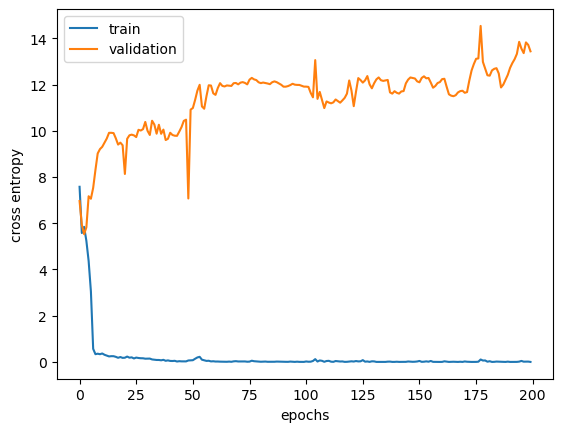

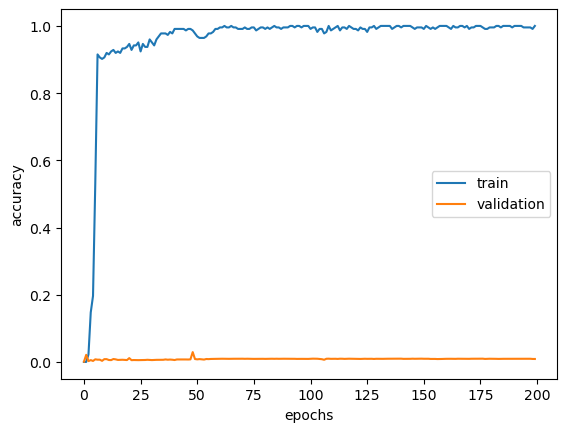

In [26]:
#Train and validate the data with sequnces extended to the right
seq_train_data2 = AlignIO.read(os.path.join(sys.path[0],"Data/Replicates/General_alignment_extended_left.fasta"),"fasta")
seq_X_train2, seq_y_train2 = [], []
for record in seq_train_data2:
    seq_X_train2.append(DNAonehotencoder(str(record.seq))) # Do the one hot encoding
    bacteria = str(record.id).replace("_consensus_ext_L","").replace("_"," ")
    seq_y_train2.append(species_id[bacteria])

seq_X_train2 = np.array(seq_X_train2)
seq_y_train2 = np.array(seq_y_train2)

seq_val_data2 = AlignIO.read(os.path.join(sys.path[0],"Data/Replicates/Validation_extended_left.fasta"),"fasta")
seq_X_val2, seq_y_val2 = speciesDNA_encoder(seq_val_data1, species_id)

seq_model1 = CNNZ(seq_X_train1, seq_y_train1, 5) #Note : Apparently, the padding increase the accuracys
seq_test = CNN_train(seq_model1, seq_X_train1, seq_X_val1, seq_y_train, seq_y_val1, 32, 0.005, "cpu") #Remember that the data is already one shot encoded